In [ ]:
import jax
import jax.numpy as jnp
import numpy as np
from jax import grad, jit, vmap
from jax import random
from functools import partial

from numba import vectorize, float64, guvectorize, njit

import time
import math
from tqdm import tqdm
import sklearn.mixture
import pandas as pd
import matplotlib.pyplot as plt

from jax.scipy.stats import multivariate_normal, norm
from scipy.stats import multivariate_normal as ss_multivariate_normal
import scipy
from sklearn.neighbors import KernelDensity
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import LeaveOneOut
from google.colab import files

In [ ]:
key = random.PRNGKey(68)
key1 = random.PRNGKey(6898)
key2 = random.PRNGKey(681998)
subkeys = random.split(key, 5000)
subkeys1 = random.split(key1, 5000)

In [ ]:
# Generate data from stable distribution
@partial(jit, static_argnames=['dataset_size','num_datasets'])
def alpha_stable(alpha, beta, gamma, delta, dataset_size, num_datasets):
    # V = jnp.pi / 2 * (2 * random.uniform(key, shape = (num_datasets, dataset_size)) - 1)
    # W = - jnp.log(random.uniform(key1, shape = (num_datasets, dataset_size)))

    V = jnp.pi / 2 * (2 * jnp.array(np.random.rand(num_datasets, dataset_size)) - 1)
    W = - jnp.log(jnp.array(np.random.rand(num_datasets, dataset_size)))

    const = beta * jnp.tan(jnp.pi * alpha / 2)
    r1 = gamma * (((1 + const * const)**(1 / (2 * alpha))) * jnp.sin(alpha * V + jnp.arctan(const)) / ((jnp.cos(V)) ** (1/alpha)) * (( jnp.cos( (1-alpha) * V - jnp.arctan(const)) / W )**((1-alpha)/alpha))) + delta

    r_immi = 2 / jnp.pi * ((jnp.pi / 2 + beta * V) * jnp.tan(V) - beta * jnp.log( (jnp.pi / 2 * W * jnp.cos(V) ) / (jnp.pi / 2 + beta * V) ))
    r2 = gamma * r_immi + (2 / jnp.pi) * beta * gamma * jnp.log(gamma) + delta
    return jnp.where(alpha !=1, r1, r2)

In [ ]:
true_theta = jnp.array([1.8, 0.5, 1, 0])

In [ ]:
actual_data = alpha_stable(true_theta[0], true_theta[1], true_theta[2], true_theta[3], 200, 1)
actual_data

Array([[-0.9994848 , -2.8999217 ,  0.31997016,  1.4593827 , -1.1671073 ,
        -0.33297178, -2.5015786 ,  0.23129147, -1.4423249 , -0.7351586 ,
         0.7737031 ,  0.7600781 , -1.9006582 , -0.2567277 , -0.2559021 ,
         3.5897994 , -0.12205172, -1.008141  , -2.4296215 , -0.60396194,
        -0.18045366,  0.2887079 ,  1.94673   , -0.10907705, -0.181604  ,
         0.41824916,  0.5413587 , -1.070129  ,  0.8022436 ,  0.30826032,
         1.033443  , -0.29956868, -0.23277798, -1.5358688 ,  1.4659512 ,
         0.24421266, -2.49694   , -3.0870469 ,  1.2492282 , -1.9415506 ,
        -2.0473053 , -0.16608885,  0.23990147,  1.9343686 , -0.18304466,
        -0.63450557, -1.0364103 ,  5.0438914 ,  1.3461846 , -1.6109391 ,
        -2.363191  ,  0.09952114, -3.7264082 , -0.11215819, -1.8467627 ,
        -2.310048  , -0.6970817 , -0.11911908, -0.7731697 ,  0.26813498,
        -3.7978916 ,  0.25855464, -0.5556254 ,  0.60402155, -1.1212634 ,
         0.81208384,  1.2323376 , -1.7410207 , -0.6

In [ ]:
# CALCULATE SUMMARY STATS
@jit
def alpha_stable_ss(data):
  # Compute quantile statistics
  v_stability = (jnp.percentile(data, 95) - jnp.percentile(data, 5)) / (jnp.percentile(data, 75) - jnp.percentile(data, 25))
  v_skewness = (jnp.percentile(data, 95) + jnp.percentile(data, 5) - 2 * jnp.percentile(data, 50)) / (jnp.percentile(data, 95) - jnp.percentile(data, 5))
  v_scale = (jnp.percentile(data, 75) - jnp.percentile(data, 25)) / 1
  v_loc = jnp.mean(data)

  # Define interpolation matrices (see [1])
  tv_stability = jnp.array([2.439, 2.5, 2.6, 2.7, 2.8, 3.0, 3.2, 3.5, 4.0, 5.0, 6.0, 8.0, 10.0, 15.0, 25.0])
  tv_skewness = jnp.array([0.0, 0.1, 0.2, 0.3, 0.5, 0.7, 1.0])
  t_stability = jnp.array([2.0, 1.9, 1.8, 1.7, 1.6, 1.5, 1.4, 1.3, 1.2, 1.1, 1.0, 0.9, 0.8, 0.7, 0.6, 0.5])
  t_skewness = jnp.array([0.0, 0.25, 0.5, 0.75, 1.0])

  psi1 = jnp.array([[2.000, 2.000, 2.000, 2.000, 2.000, 2.000, 2.000],
    [1.916, 1.924, 1.924, 1.924, 1.924, 1.924, 1.924],
    [1.808, 1.813, 1.829, 1.829, 1.829, 1.829, 1.829],
    [1.729, 1.730, 1.737, 1.745, 1.745, 1.745, 1.745],
    [1.664, 1.663, 1.663, 1.668, 1.676, 1.676, 1.676],
    [1.563, 1.560, 1.553, 1.548, 1.547, 1.547, 1.547],
    [1.484, 1.480, 1.471, 1.460, 1.448, 1.438, 1.438],
    [1.391, 1.386, 1.378, 1.364, 1.337, 1.318, 1.318],
    [1.279, 1.273, 1.266, 1.250, 1.210, 1.184, 1.150],
    [1.128, 1.121, 1.114, 1.101, 1.067, 1.027, 0.973],
    [1.029, 1.021, 1.014, 1.004, 0.974, 0.935, 0.874],
    [0.896, 0.892, 0.887, 0.883, 0.855, 0.823, 0.769],
    [0.818, 0.812, 0.806, 0.801, 0.780, 0.756, 0.691],
    [0.698, 0.695, 0.692, 0.689, 0.676, 0.656, 0.595],
    [0.593, 0.590, 0.588, 0.586, 0.579, 0.563, 0.513]])

  psi2 = jnp.array([[0.000, 2.160, 1.000, 1.000, 1.000, 1.000, 1.000],
    [0.000, 1.592, 3.390, 1.000, 1.000, 1.000, 1.000],
    [0.000, 0.759, 1.800, 1.000, 1.000, 1.000, 1.000],
    [0.000, 0.482, 1.048, 1.694, 1.000, 1.000, 1.000],
    [0.000, 0.360, 0.760, 1.232, 2.229, 1.000, 1.000],
    [0.000, 0.253, 0.518, 0.823, 1.575, 1.000, 1.000],
    [0.000, 0.203, 0.410, 0.632, 1.244, 1.906, 1.000],
    [0.000, 0.165, 0.332, 0.499, 0.943, 1.560, 1.000],
    [0.000, 0.136, 0.271, 0.404, 0.689, 1.230, 2.195],
    [0.000, 0.109, 0.216, 0.323, 0.539, 0.827, 1.917],
    [0.000, 0.096, 0.190, 0.284, 0.472, 0.693, 1.759],
    [0.000, 0.082, 0.163, 0.243, 0.412, 0.601, 1.596],
    [0.000, 0.074, 0.147, 0.220, 0.377, 0.546, 1.482],
    [0.000, 0.064, 0.128, 0.191, 0.330, 0.478, 1.362],
    [0.000, 0.056, 0.112, 0.167, 0.285, 0.428, 1.274]])

  psi3 = jnp.array([[1.908, 1.908, 1.908, 1.908, 1.908],
    [1.914, 1.915, 1.916, 1.918, 1.921],
    [1.921, 1.922, 1.927, 1.936, 1.947],
    [1.927, 1.930, 1.943, 1.961, 1.987],
    [1.933, 1.940, 1.962, 1.997, 2.043],
    [1.939, 1.952, 1.988, 2.045, 2.116],
    [1.946, 1.967, 2.022, 2.106, 2.211],
    [1.955, 1.984, 2.067, 2.188, 2.333],
    [1.965, 2.007, 2.125, 2.294, 2.491],
    [1.980, 2.040, 2.205, 2.435, 2.696],
    [2.000, 2.085, 2.311, 2.624, 2.973],
    [2.040, 2.149, 2.461, 2.886, 3.356],
    [2.098, 2.244, 2.676, 3.265, 3.912],
    [2.189, 2.392, 3.004, 3.844, 4.775],
    [2.337, 2.635, 3.542, 4.808, 6.247],
    [2.588, 3.073, 4.534, 6.636, 9.144]])


  psi4 = jnp.array([[0.0,    0.0,    0.0,    0.0,  0.0],
    [0.0, -0.017, -0.032, -0.049, -0.064],
    [0.0, -0.030, -0.061, -0.092, -0.123],
    [0.0, -0.043, -0.088, -0.132, -0.179],
    [0.0, -0.056, -0.111, -0.170, -0.232],
    [0.0, -0.066, -0.134, -0.206, -0.283],
    [0.0, -0.075, -0.154, -0.241, -0.335],
    [0.0, -0.084, -0.173, -0.276, -0.390],
    [0.0, -0.090, -0.192, -0.310, -0.447],
    [0.0, -0.095, -0.208, -0.346, -0.508],
    [0.0, -0.098, -0.223, -0.383, -0.576],
    [0.0, -0.099, -0.237, -0.424, -0.652],
    [0.0, -0.096, -0.250, -0.469, -0.742],
    [0.0, -0.089, -0.262, -0.520, -0.853],
    [0.0, -0.078, -0.272, -0.581, -0.997],
    [0.0, -0.061, -0.279, -0.659, -1.198]])

  tv_stability_i1 = jnp.max(jnp.append(0, jnp.argwhere(tv_stability <= v_stability, size=len(tv_stability), fill_value=0)))
  tv_stability_i2 = jnp.min(jnp.append(14, jnp.argwhere(tv_stability >= v_stability, size=len(tv_stability), fill_value=14)))
  tv_skewness_i1 = jnp.max(jnp.append(0, jnp.argwhere(tv_skewness <= jnp.abs(v_skewness), size=len(tv_skewness), fill_value=0)))
  tv_skewness_i2 = jnp.min(jnp.append(6, jnp.argwhere(tv_skewness >= jnp.abs(v_skewness), size=len(tv_skewness), fill_value=6)))

  dist_stability_tv = tv_stability[tv_stability_i2] - tv_stability[tv_stability_i1]

  dist_stability = jnp.where(dist_stability_tv != 0, (v_stability - tv_stability[tv_stability_i1]) / dist_stability_tv, dist_stability_tv)

  dist_skewness_tv = tv_skewness[tv_skewness_i2] - tv_skewness[tv_skewness_i1]

  dist_skewness = jnp.where(dist_skewness_tv != 0, (jnp.abs(v_skewness) - tv_skewness[tv_skewness_i1]) / dist_skewness_tv, dist_skewness_tv)

  psi1b1 = dist_stability*psi1[tv_stability_i2,tv_skewness_i1]+(1-dist_stability)*psi1[tv_stability_i1,tv_skewness_i1]
  psi1b2 = dist_stability*psi1[tv_stability_i2,tv_skewness_i2]+(1-dist_stability)*psi1[tv_stability_i1,tv_skewness_i2]
  alpha = dist_skewness*psi1b2+(1-dist_skewness)*psi1b1
  psi2b1 = dist_stability*psi2[tv_stability_i2,tv_skewness_i1]+(1-dist_stability)*psi2[tv_stability_i1,tv_skewness_i1]
  psi2b2 = dist_stability*psi2[tv_stability_i2,tv_skewness_i2]+(1-dist_stability)*psi2[tv_stability_i1,tv_skewness_i2]
  beta = jnp.sign(v_skewness)*(dist_skewness*psi2b2+(1-dist_skewness)*psi2b1)
  t_stability_i1 = jnp.max(jnp.append(0, jnp.argwhere(t_stability >= alpha, size=len(t_stability), fill_value=0)))
  t_stability_i2 = jnp.min(jnp.append(15, jnp.argwhere(t_stability <= alpha, size=len(t_stability), fill_value=15)))
  t_skewness_i1 = jnp.max(jnp.append(0, jnp.argwhere(t_skewness <= jnp.abs(beta),size=len(t_skewness), fill_value=0)))
  t_skewness_i2 = jnp.min(jnp.append(4, jnp.argwhere(t_skewness >= jnp.abs(beta),size=len(t_skewness), fill_value=4)))

  dist_stability_t = t_stability[t_stability_i2] - t_stability[t_stability_i1]

  dist_stability = jnp.where(dist_stability_t != 0, (alpha - t_stability[t_stability_i1]) / dist_stability_t, dist_stability_t)

  dist_skewness_t = t_skewness[t_skewness_i2] - t_skewness[t_skewness_i1]

  dist_skewness = jnp.where(dist_skewness_t != 0, (jnp.abs(beta) - t_skewness[t_skewness_i1]) / dist_skewness, dist_skewness_t)

  psi3b1 = dist_stability*psi3[t_stability_i2,t_skewness_i1]+(1-dist_stability)*psi3[t_stability_i1,t_skewness_i1]
  psi3b2 = dist_stability*psi3[t_stability_i2,t_skewness_i2]+(1-dist_stability)*psi3[t_stability_i1,t_skewness_i2]
  sigma = v_scale/(dist_skewness*psi3b2+(1-dist_skewness)*psi3b1)
  psi4b1 = dist_stability*psi4[t_stability_i2,t_skewness_i1]+(1-dist_stability)*psi4[t_stability_i1,t_skewness_i1]
  psi4b2 = dist_stability*psi4[t_stability_i2,t_skewness_i2]+(1-dist_stability)*psi4[t_stability_i1,t_skewness_i2]
  zeta = jnp.sign(beta)*sigma*(dist_skewness*psi4b2+(1-dist_skewness)*psi4b1) + jnp.percentile(data, 50)

  mu = jnp.where(jnp.abs(alpha-1) < 0.05, zeta, zeta - beta * sigma * jnp.tan(0.5 * jnp.pi *alpha))

  return jnp.array([alpha, beta, sigma, mu]) #stability, skewness, scale, loc

In [ ]:
actual_summary_statistics = alpha_stable_ss(actual_data)
actual_summary_statistics =  jnp.array([2.        , -0.6959737 ,  1.103275  ,  0.20693694])

In [ ]:
num_coeffs = len(true_theta)
num_latent = len(true_theta)
n_samples = 30
num_datasets = 200
lambda_dim = num_coeffs + int((num_coeffs * (num_coeffs + 1)) / 2)
eps_precision = 1000

tau = 0.01
sigma_theta = 10
sigma_latent = 1

In [ ]:
def my_inv(x):
    return jnp.linalg.inv(x + (jnp.eye(x.shape[0]) * 1e-7))

## Training Wasserstein Gaussianing

In [ ]:
len_ss = jnp.shape(actual_summary_statistics)[0]
wass_num_datasets = 10000
wass_val_num_datasets = 10000
wass_n_samples = 30
d_Lambda = 2 + len_ss
num_layers = 12
# To optimize F
tau = 0.01
stop_f = 10000
learning_rate = 0.005
l_threshold = 10
threshold = stop_f/2
adaptive_lr_1 = 0.9
adaptive_lr_2 = 0.9
t_w_f = 100
Patience_f = 101
batch_size = 5
# To optimize LB
stop = 5000
Patience = 20
t_w = 50

In [ ]:
# Generating data to train the transform
wass_datasets = alpha_stable(1.8, 0.5, 1, 0, wass_n_samples, wass_num_datasets)
wass_n_summary_statistics = jnp.array([alpha_stable_ss(wass_datasets[i,:]) for i in range(wass_num_datasets)])
val_n_summary_statistics = jnp.array([alpha_stable_ss(wass_datasets[i,:]) for i in range(wass_val_num_datasets)])
original_n_summary_statistics = wass_n_summary_statistics

In [ ]:
scaler_mean = jnp.mean(original_n_summary_statistics, axis=0)
scaler_std = jnp.std(original_n_summary_statistics, axis=0)
wass_n_summary_statistics = (wass_n_summary_statistics - scaler_mean) / scaler_std

In [ ]:
def radial_flow(Lambda, x):
    # original_x = x
    d_Lambda = 2 + len_ss
    logdet_jacob_T_x = 0
    for k in range(num_layers):
        # print(k)
        Lambda_k = Lambda[k * d_Lambda : (k + 1) * d_Lambda]
        alpha = jnp.exp(Lambda_k[0])
        beta = -alpha + jnp.exp(Lambda_k[1])
        # beta = tau * beta
        mu = Lambda_k[2:]
        # r_x = jnp.linalg.norm(x - mu)
        r_x = jnp.sqrt(jnp.dot((x - mu).T, (x - mu)))
        x = x + beta / (alpha + r_x) * (x - mu)
        logdet_jacob_T_x += jnp.log(1 + alpha * beta / (alpha + r_x)**2) + (len_ss - 1) * jnp.log(1 + beta / (alpha + r_x))
        # f = - logdet_jacob_T_x + 1/2 * T_x.T @ T_x + 1/(2*0.1) * (jnp.linalg.norm(x - T_x))**2
    return x, logdet_jacob_T_x
def kl(x):
    return 1/2 * x.T @ x
def lb(x):
    return -1/2 * x.T @ x
def f_with_Lambda_(Lambda, x):
    T_x, log_Jacobian = radial_flow(Lambda, x)
    diff = x - T_x
    f = - log_Jacobian + 1/2 * T_x.T @ T_x + 0.5 / 0.1 * jnp.dot(diff.T, diff)
    return f
def mean_f(Lambda, x):
    mean_f = jnp.mean(f_with_Lambda_batched(Lambda, x))
    return mean_f

In [ ]:
transform_auto = vmap(radial_flow, in_axes=(None, 0))
f_with_Lambda_batched = vmap(f_with_Lambda_, in_axes=(None, 0))
kl_auto = vmap(kl)
LB_all = []
LB_Smoothed = []
Lambda_list = []
patience = 0
Lambda = random.normal(subkeys[0], (num_layers * d_Lambda,))
kl_helper = jnp.sum(norm.logpdf(original_n_summary_statistics), axis=1)
# Pre-compute random permutations outside the loop for efficiency
random_permutations = [random.permutation(subkey, wass_num_datasets) for subkey in subkeys1]

for k in tqdm(range(stop)):
    f_all = []
    F_Smoothed = []
    patience_f = 0
    # Lambda = random.uniform(subkeys[k], (num_layers * d_Lambda,), minval=0, maxval=10).reshape(num_layers, d_Lambda)
    for t in range(stop_f):
        # Batch data
        random_row_indices = random_permutations[t][:batch_size]
        # Select the rows from the matrix using the random row indices
        subset_n_summary_statistics = wass_n_summary_statistics[random_row_indices, :]
        grad_lambda = grad(mean_f, argnums=0)(Lambda, subset_n_summary_statistics)
        f_t = mean_f(Lambda, subset_n_summary_statistics)
        if t == 0:
            # Update lambda_q
            g_lambda_init = grad_lambda
            if jnp.linalg.norm(g_lambda_init) > l_threshold:
                g_lambda_init = l_threshold * g_lambda_init / jnp.linalg.norm(g_lambda_init)
            v_lambda_init = g_lambda_init ** 2
        else:
            # Update lambda_q
            g_lambda_t = grad_lambda
            if jnp.linalg.norm(g_lambda_t) > l_threshold:
                g_lambda_t = l_threshold * g_lambda_t / jnp.linalg.norm(g_lambda_t)
            v_lambda_t = g_lambda_t ** 2
            #---- Update lambda
            g_lambda_init = adaptive_lr_1 * g_lambda_init + (1 - adaptive_lr_1) * g_lambda_t
            v_lambda_init = adaptive_lr_2 * v_lambda_init + (1 - adaptive_lr_2) * v_lambda_t
        if t >= threshold:
            update_t = learning_rate * threshold / t
        else:
            update_t = learning_rate
        Lambda = Lambda - update_t * g_lambda_init / (v_lambda_init ** 0.5)
        # Calculate lower bound
        f_all.append(f_t)
        if t >= t_w_f:
            f_smoothed = jnp.mean(jnp.array(f_all[t - t_w_f + 1 : t]))
            print('F Smoothed', f_smoothed)
            F_Smoothed.append(f_smoothed)
            if f_smoothed <= jnp.min(jnp.array(F_Smoothed)):
                patience_f = 0
                lambda_best = Lambda
            else:
                patience_f += 1
                if patience_f > Patience_f:
                    print("Stop at", t)
                    break
    Lambda_list.append(lambda_best)
    wass_n_summary_statistics = transform_auto(lambda_best, wass_n_summary_statistics)[0]
    kl_helper = kl_helper - transform_auto(lambda_best, wass_n_summary_statistics)[1]
    kl_k = jnp.mean(kl_helper + kl_auto(wass_n_summary_statistics))
    lb_k = -kl_k
    LB_all.append(lb_k)
    if k < t_w:
        print('>>>>>>>>>>>>>>>>>>>>>>> LB <<<<<<<<<<<<<<<<<<<<<<<', lb_k)
    if k >= t_w:
        LB_smoothed = jnp.mean(jnp.array(LB_all[k - t_w + 1 : k]))
        print('>>>>>>>>>>>>>>>>>>>>>>> LB Smoothed <<<<<<<<<<<<<<<<<<<<<<<', LB_smoothed)
        LB_Smoothed.append(LB_smoothed)
        if LB_smoothed >= jnp.max(jnp.array(LB_Smoothed)):
            patience = 0
            transformed_n_summary_statistics = wass_n_summary_statistics
        else:
            patience += 1
            if patience > Patience:
                print("Stop at", t)
                break

  0%|          | 0/5000 [00:00<?, ?it/s]

F Smoothed 702.3214
F Smoothed 686.7793
F Smoothed 671.97174
F Smoothed 657.0065
F Smoothed 642.8744
F Smoothed 628.30597
F Smoothed 613.9912
F Smoothed 599.73895
F Smoothed 586.14435
F Smoothed 572.4514
F Smoothed 559.07916
F Smoothed 546.13525
F Smoothed 533.46356
F Smoothed 521.2066
F Smoothed 507.50635
F Smoothed 496.09225
F Smoothed 484.1993
F Smoothed 472.81335
F Smoothed 461.71725
F Smoothed 450.54498
F Smoothed 439.7267
F Smoothed 429.11923
F Smoothed 418.69516
F Smoothed 408.3016
F Smoothed 398.30365
F Smoothed 388.3388
F Smoothed 378.4184
F Smoothed 368.51587
F Smoothed 359.07565
F Smoothed 349.75754
F Smoothed 340.6856
F Smoothed 331.6789
F Smoothed 322.94824
F Smoothed 314.40088
F Smoothed 305.96893
F Smoothed 297.72113
F Smoothed 289.67905
F Smoothed 281.70605
F Smoothed 274.03848
F Smoothed 266.24057
F Smoothed 258.8342
F Smoothed 251.4194
F Smoothed 244.33118
F Smoothed 237.44026
F Smoothed 230.57228
F Smoothed 223.84792
F Smoothed 217.15916
F Smoothed 210.63269
F Smooth

  0%|          | 1/5000 [05:42<475:53:52, 342.72s/it]

>>>>>>>>>>>>>>>>>>>>>>> LB <<<<<<<<<<<<<<<<<<<<<<< 4.5648155
F Smoothed 2.130349
F Smoothed 2.1388347
F Smoothed 2.1444473
F Smoothed 2.1407154
F Smoothed 2.1273403
F Smoothed 2.129328
F Smoothed 2.129258
F Smoothed 2.1277027
F Smoothed 2.1292894
F Smoothed 2.1179419
F Smoothed 2.1395683
F Smoothed 2.1258864
F Smoothed 2.103559
F Smoothed 2.108936
F Smoothed 1.9458082
F Smoothed 1.9631549
F Smoothed 1.9607359
F Smoothed 1.9432893
F Smoothed 1.9553723
F Smoothed 1.9578248
F Smoothed 1.9618782
F Smoothed 1.9666102
F Smoothed 1.9657036
F Smoothed 1.9586654
F Smoothed 1.9551866
F Smoothed 1.9554065
F Smoothed 1.9523078
F Smoothed 1.9404075
F Smoothed 1.9463948
F Smoothed 1.9380604
F Smoothed 1.9439223
F Smoothed 1.9627874
F Smoothed 1.9629498
F Smoothed 1.9522711
F Smoothed 1.9475057
F Smoothed 1.9622326
F Smoothed 1.9589893
F Smoothed 1.969381
F Smoothed 1.9654609
F Smoothed 1.9634147
F Smoothed 1.9652704
F Smoothed 1.9590095
F Smoothed 1.9454567
F Smoothed 1.9803121
F Smoothed 1.9929389


  0%|          | 2/5000 [08:34<336:02:00, 242.04s/it]

>>>>>>>>>>>>>>>>>>>>>>> LB <<<<<<<<<<<<<<<<<<<<<<< 4.6412215
F Smoothed 2.2874067
F Smoothed 2.296871
F Smoothed 2.3037791
F Smoothed 2.301495
F Smoothed 2.287341
F Smoothed 2.289689
F Smoothed 2.2884052
F Smoothed 2.2856674
F Smoothed 2.2886736
F Smoothed 2.2758853
F Smoothed 2.2976959
F Smoothed 2.2835069
F Smoothed 2.2602174
F Smoothed 2.267171
F Smoothed 2.1194856
F Smoothed 2.134734
F Smoothed 2.1329637
F Smoothed 2.115913
F Smoothed 2.1290627
F Smoothed 2.1337688
F Smoothed 2.1380775
F Smoothed 2.1421928
F Smoothed 2.1413248
F Smoothed 2.1340613
F Smoothed 2.129951
F Smoothed 2.129766
F Smoothed 2.1269298
F Smoothed 2.1158655
F Smoothed 2.1224444
F Smoothed 2.1140819
F Smoothed 2.1207936
F Smoothed 2.1412652
F Smoothed 2.1402917
F Smoothed 2.1296105
F Smoothed 2.1253343
F Smoothed 2.1389306
F Smoothed 2.1361096
F Smoothed 2.1472554
F Smoothed 2.1426141
F Smoothed 2.1421275
F Smoothed 2.143537
F Smoothed 2.137101
F Smoothed 2.1252546
F Smoothed 2.1589448
F Smoothed 2.1723335
F Smo

  0%|          | 3/5000 [11:26<291:39:46, 210.12s/it]

>>>>>>>>>>>>>>>>>>>>>>> LB <<<<<<<<<<<<<<<<<<<<<<< 4.665767
F Smoothed 2.490964
F Smoothed 2.5012481
F Smoothed 2.5082607
F Smoothed 2.506199
F Smoothed 2.4910965
F Smoothed 2.4938548
F Smoothed 2.4911914
F Smoothed 2.487965
F Smoothed 2.4901667
F Smoothed 2.4761746
F Smoothed 2.499135
F Smoothed 2.4834647
F Smoothed 2.4585228
F Smoothed 2.4662669
F Smoothed 2.3292022
F Smoothed 2.3443062
F Smoothed 2.3438697
F Smoothed 2.3263772
F Smoothed 2.340452
F Smoothed 2.3463447
F Smoothed 2.3510118
F Smoothed 2.3549101
F Smoothed 2.35399
F Smoothed 2.3471925
F Smoothed 2.3424098
F Smoothed 2.3421538
F Smoothed 2.3380291
F Smoothed 2.3281794
F Smoothed 2.3344958
F Smoothed 2.3253226
F Smoothed 2.3325832
F Smoothed 2.3545578
F Smoothed 2.3525305
F Smoothed 2.3413708
F Smoothed 2.3369563
F Smoothed 2.3502748
F Smoothed 2.3473005
F Smoothed 2.3595653
F Smoothed 2.3548605
F Smoothed 2.3550153
F Smoothed 2.355669
F Smoothed 2.3487399
F Smoothed 2.3385358
F Smoothed 2.3705873
F Smoothed 2.3842628
F S

  0%|          | 4/5000 [14:16<269:53:47, 194.48s/it]

>>>>>>>>>>>>>>>>>>>>>>> LB <<<<<<<<<<<<<<<<<<<<<<< 4.6456804
F Smoothed 2.6780636
F Smoothed 2.689272
F Smoothed 2.6966028
F Smoothed 2.6949592
F Smoothed 2.678568
F Smoothed 2.6822324
F Smoothed 2.67911
F Smoothed 2.6757379
F Smoothed 2.6756332
F Smoothed 2.6603692
F Smoothed 2.6846147
F Smoothed 2.667473
F Smoothed 2.641093
F Smoothed 2.6493666
F Smoothed 2.5209372
F Smoothed 2.5361326
F Smoothed 2.5366673
F Smoothed 2.5186164
F Smoothed 2.5335274
F Smoothed 2.5405524
F Smoothed 2.54597
F Smoothed 2.54975
F Smoothed 2.5488691
F Smoothed 2.5435061
F Smoothed 2.5373764
F Smoothed 2.5370126
F Smoothed 2.53145
F Smoothed 2.522775
F Smoothed 2.528724
F Smoothed 2.5184333
F Smoothed 2.5263228
F Smoothed 2.549788
F Smoothed 2.5470998
F Smoothed 2.5354328
F Smoothed 2.5306807
F Smoothed 2.5445263
F Smoothed 2.5415156
F Smoothed 2.554994
F Smoothed 2.5500395
F Smoothed 2.5506902
F Smoothed 2.5508509
F Smoothed 2.5433156
F Smoothed 2.5342965
F Smoothed 2.5651698
F Smoothed 2.5790212
F Smoothed

  0%|          | 5/5000 [17:06<257:34:52, 185.64s/it]

>>>>>>>>>>>>>>>>>>>>>>> LB <<<<<<<<<<<<<<<<<<<<<<< 4.6024523
F Smoothed 2.8402066
F Smoothed 2.8519516
F Smoothed 2.859582
F Smoothed 2.858007
F Smoothed 2.840189
F Smoothed 2.8445952
F Smoothed 2.8413715
F Smoothed 2.8378367
F Smoothed 2.8356915
F Smoothed 2.8191416
F Smoothed 2.8444073
F Smoothed 2.8262978
F Smoothed 2.798912
F Smoothed 2.8073907
F Smoothed 2.6861522
F Smoothed 2.701271
F Smoothed 2.7025018
F Smoothed 2.6837769
F Smoothed 2.6999967
F Smoothed 2.7081697
F Smoothed 2.7145925
F Smoothed 2.7180283
F Smoothed 2.7174869
F Smoothed 2.7132876
F Smoothed 2.7061212
F Smoothed 2.7056866
F Smoothed 2.6993659
F Smoothed 2.6918051
F Smoothed 2.6975055
F Smoothed 2.6862364
F Smoothed 2.6945148
F Smoothed 2.7192888
F Smoothed 2.7161033
F Smoothed 2.7039406
F Smoothed 2.6989505
F Smoothed 2.7131014
F Smoothed 2.710183
F Smoothed 2.724784
F Smoothed 2.719255
F Smoothed 2.7205157
F Smoothed 2.720522
F Smoothed 2.7122586
F Smoothed 2.7039962
F Smoothed 2.7338362
F Smoothed 2.7477772
F S

  0%|          | 6/5000 [19:01<224:03:51, 161.52s/it]

>>>>>>>>>>>>>>>>>>>>>>> LB <<<<<<<<<<<<<<<<<<<<<<< 4.6466217
F Smoothed 2.7039597
F Smoothed 2.7161348
F Smoothed 2.7230976
F Smoothed 2.7210083
F Smoothed 2.7048352
F Smoothed 2.7080665
F Smoothed 2.7033937
F Smoothed 2.6996124
F Smoothed 2.6949391
F Smoothed 2.678271
F Smoothed 2.7021577
F Smoothed 2.6847236
F Smoothed 2.6579928
F Smoothed 2.6663158
F Smoothed 2.555822
F Smoothed 2.57109
F Smoothed 2.5734503
F Smoothed 2.555376
F Smoothed 2.57239
F Smoothed 2.5812492
F Smoothed 2.5875928
F Smoothed 2.5911717
F Smoothed 2.590779
F Smoothed 2.587115
F Smoothed 2.5825515
F Smoothed 2.5820181
F Smoothed 2.5773697
F Smoothed 2.5706198
F Smoothed 2.576453
F Smoothed 2.5650778
F Smoothed 2.5720057
F Smoothed 2.595917
F Smoothed 2.5925934
F Smoothed 2.5809789
F Smoothed 2.576173
F Smoothed 2.588144
F Smoothed 2.5858538
F Smoothed 2.599506
F Smoothed 2.5932298
F Smoothed 2.5947878
F Smoothed 2.5964174
F Smoothed 2.5874727
F Smoothed 2.5798354
F Smoothed 2.607159
F Smoothed 2.621095
F Smoothed

  0%|          | 7/5000 [21:05<207:04:26, 149.30s/it]

>>>>>>>>>>>>>>>>>>>>>>> LB <<<<<<<<<<<<<<<<<<<<<<< 4.65657
F Smoothed 2.633985
F Smoothed 2.6464655
F Smoothed 2.65346
F Smoothed 2.6528728
F Smoothed 2.6375308
F Smoothed 2.6414165
F Smoothed 2.637252
F Smoothed 2.6342287
F Smoothed 2.6291947
F Smoothed 2.612007
F Smoothed 2.6357355
F Smoothed 2.6180575
F Smoothed 2.590994
F Smoothed 2.5988061
F Smoothed 2.4982567
F Smoothed 2.5128262
F Smoothed 2.5155075
F Smoothed 2.498404
F Smoothed 2.5156
F Smoothed 2.524158
F Smoothed 2.5302815
F Smoothed 2.5337405
F Smoothed 2.5335839
F Smoothed 2.5298378
F Smoothed 2.5259807
F Smoothed 2.525398
F Smoothed 2.5221035
F Smoothed 2.515867
F Smoothed 2.521945
F Smoothed 2.5107627
F Smoothed 2.5169332
F Smoothed 2.5401826
F Smoothed 2.5367138
F Smoothed 2.525585
F Smoothed 2.5207624
F Smoothed 2.5308614
F Smoothed 2.5290852
F Smoothed 2.5420227
F Smoothed 2.5349813
F Smoothed 2.5368934
F Smoothed 2.5400472
F Smoothed 2.5306194
F Smoothed 2.523306
F Smoothed 2.5488458
F Smoothed 2.562886
F Smoothed 2.

  0%|          | 8/5000 [24:16<225:20:37, 162.51s/it]

>>>>>>>>>>>>>>>>>>>>>>> LB <<<<<<<<<<<<<<<<<<<<<<< 4.58828
F Smoothed 2.794796
F Smoothed 2.8081741
F Smoothed 2.8162146
F Smoothed 2.8165178
F Smoothed 2.7960198
F Smoothed 2.8002696
F Smoothed 2.7963877
F Smoothed 2.7931821
F Smoothed 2.7892663
F Smoothed 2.7713704
F Smoothed 2.7958672
F Smoothed 2.7771893
F Smoothed 2.7487648
F Smoothed 2.7554603
F Smoothed 2.6604652
F Smoothed 2.6719298
F Smoothed 2.6744065
F Smoothed 2.6569486
F Smoothed 2.6751301
F Smoothed 2.6840007
F Smoothed 2.690413
F Smoothed 2.69252
F Smoothed 2.6934192
F Smoothed 2.6888428
F Smoothed 2.6818008
F Smoothed 2.6812162
F Smoothed 2.6771135
F Smoothed 2.6712897
F Smoothed 2.6770198
F Smoothed 2.6657639
F Smoothed 2.6730323
F Smoothed 2.6969416
F Smoothed 2.6930318
F Smoothed 2.6814923
F Smoothed 2.6763475
F Smoothed 2.686177
F Smoothed 2.684627
F Smoothed 2.6983907
F Smoothed 2.6906812
F Smoothed 2.6934814
F Smoothed 2.6965487
F Smoothed 2.6879802
F Smoothed 2.6811256
F Smoothed 2.706263
F Smoothed 2.7201457
F S

  0%|          | 9/5000 [27:17<233:21:58, 168.33s/it]

>>>>>>>>>>>>>>>>>>>>>>> LB <<<<<<<<<<<<<<<<<<<<<<< 4.528896
F Smoothed 2.9063118
F Smoothed 2.920404
F Smoothed 2.9288807
F Smoothed 2.9287972
F Smoothed 2.9080725
F Smoothed 2.9126341
F Smoothed 2.908428
F Smoothed 2.9047642
F Smoothed 2.9018173
F Smoothed 2.8842762
F Smoothed 2.9092932
F Smoothed 2.8893661
F Smoothed 2.8595526
F Smoothed 2.866652
F Smoothed 2.775113
F Smoothed 2.785478
F Smoothed 2.787949
F Smoothed 2.7702482
F Smoothed 2.7897189
F Smoothed 2.7985916
F Smoothed 2.8054883
F Smoothed 2.8071933
F Smoothed 2.808806
F Smoothed 2.803348
F Smoothed 2.7950337
F Smoothed 2.794639
F Smoothed 2.79
F Smoothed 2.7843888
F Smoothed 2.789843
F Smoothed 2.778521
F Smoothed 2.7866936
F Smoothed 2.8110511
F Smoothed 2.8068335
F Smoothed 2.7947128
F Smoothed 2.7895658
F Smoothed 2.7992547
F Smoothed 2.7980187
F Smoothed 2.8124716
F Smoothed 2.8040574
F Smoothed 2.8074586
F Smoothed 2.8103743
F Smoothed 2.8029742
F Smoothed 2.7966297
F Smoothed 2.8217015
F Smoothed 2.8356218
F Smoothed 

  0%|          | 10/5000 [30:08<234:36:15, 169.25s/it]

>>>>>>>>>>>>>>>>>>>>>>> LB <<<<<<<<<<<<<<<<<<<<<<< 4.4893684
F Smoothed 2.9810166
F Smoothed 2.995519
F Smoothed 3.0047367
F Smoothed 3.0031898
F Smoothed 2.9824464
F Smoothed 2.9871635
F Smoothed 2.9825532
F Smoothed 2.978645
F Smoothed 2.9767487
F Smoothed 2.9604173
F Smoothed 2.98581
F Smoothed 2.9649134
F Smoothed 2.9340231
F Smoothed 2.9413524
F Smoothed 2.8525267
F Smoothed 2.8622134
F Smoothed 2.864223
F Smoothed 2.8463566
F Smoothed 2.8671389
F Smoothed 2.8756454
F Smoothed 2.8829713
F Smoothed 2.8841984
F Smoothed 2.8867347
F Smoothed 2.880857
F Smoothed 2.872299
F Smoothed 2.8719523
F Smoothed 2.867073
F Smoothed 2.8613179
F Smoothed 2.8665094
F Smoothed 2.8553267
F Smoothed 2.8642287
F Smoothed 2.8885677
F Smoothed 2.8842225
F Smoothed 2.871727
F Smoothed 2.8666542
F Smoothed 2.876251
F Smoothed 2.8753965
F Smoothed 2.89031
F Smoothed 2.8813035
F Smoothed 2.884899
F Smoothed 2.8876336
F Smoothed 2.8807023
F Smoothed 2.8745062
F Smoothed 2.8995814
F Smoothed 2.9136753
F Smoot

  0%|          | 11/5000 [32:59<235:16:35, 169.77s/it]

>>>>>>>>>>>>>>>>>>>>>>> LB <<<<<<<<<<<<<<<<<<<<<<< 4.4729857
F Smoothed 3.0258505
F Smoothed 3.0403244
F Smoothed 3.050298
F Smoothed 3.0474987
F Smoothed 3.0273123
F Smoothed 3.0323005
F Smoothed 3.0274494
F Smoothed 3.0236294
F Smoothed 3.0227728
F Smoothed 3.007762
F Smoothed 3.033399
F Smoothed 3.0117016
F Smoothed 2.979972
F Smoothed 2.9875007
F Smoothed 2.9010115
F Smoothed 2.9105558
F Smoothed 2.9121287
F Smoothed 2.8942895
F Smoothed 2.91639
F Smoothed 2.924445
F Smoothed 2.9319649
F Smoothed 2.9325938
F Smoothed 2.936153
F Smoothed 2.9298918
F Smoothed 2.9215791
F Smoothed 2.9211864
F Smoothed 2.916444
F Smoothed 2.9104342
F Smoothed 2.9153862
F Smoothed 2.9044445
F Smoothed 2.9141142
F Smoothed 2.9380002
F Smoothed 2.9334784
F Smoothed 2.9207911
F Smoothed 2.915848
F Smoothed 2.9251678
F Smoothed 2.9244905
F Smoothed 2.9398234
F Smoothed 2.9302623
F Smoothed 2.9342356
F Smoothed 2.936958
F Smoothed 2.9301708
F Smoothed 2.923941
F Smoothed 2.9488337
F Smoothed 2.9631498
F Smoo

  0%|          | 12/5000 [35:50<235:45:49, 170.16s/it]

>>>>>>>>>>>>>>>>>>>>>>> LB <<<<<<<<<<<<<<<<<<<<<<< 4.4708467
F Smoothed 3.0586305
F Smoothed 3.0728626
F Smoothed 3.0834885
F Smoothed 3.0796258
F Smoothed 3.06049
F Smoothed 3.0658724
F Smoothed 3.0610297
F Smoothed 3.0574327
F Smoothed 3.0577645
F Smoothed 3.0432792
F Smoothed 3.0691516
F Smoothed 3.046687
F Smoothed 3.0143156
F Smoothed 3.021957
F Smoothed 2.937757
F Smoothed 2.9471843
F Smoothed 2.9482267
F Smoothed 2.9304075
F Smoothed 2.9532366
F Smoothed 2.9606578
F Smoothed 2.9681742
F Smoothed 2.9684381
F Smoothed 2.9727795
F Smoothed 2.9659405
F Smoothed 2.9582763
F Smoothed 2.9576988
F Smoothed 2.953311
F Smoothed 2.947008
F Smoothed 2.9515536
F Smoothed 2.940874
F Smoothed 2.9514961
F Smoothed 2.9747956
F Smoothed 2.9698486
F Smoothed 2.9571662
F Smoothed 2.9523308
F Smoothed 2.9612136
F Smoothed 2.9603746
F Smoothed 2.9759662
F Smoothed 2.9660034
F Smoothed 2.9706051
F Smoothed 2.973494
F Smoothed 2.9668117
F Smoothed 2.9604146
F Smoothed 2.9849927
F Smoothed 2.9995794
F S

  0%|          | 13/5000 [38:41<235:59:51, 170.36s/it]

>>>>>>>>>>>>>>>>>>>>>>> LB <<<<<<<<<<<<<<<<<<<<<<< 4.4762826
F Smoothed 3.082183
F Smoothed 3.0961344
F Smoothed 3.107301
F Smoothed 3.102513
F Smoothed 3.0847242
F Smoothed 3.0904405
F Smoothed 3.0857177
F Smoothed 3.082292
F Smoothed 3.0838938
F Smoothed 3.0695276
F Smoothed 3.0956156
F Smoothed 3.0726128
F Smoothed 3.039756
F Smoothed 3.0473497
F Smoothed 2.965551
F Smoothed 2.9747322
F Smoothed 2.9750652
F Smoothed 2.9572713
F Smoothed 2.9804235
F Smoothed 2.9870315
F Smoothed 2.9944384
F Smoothed 2.9945657
F Smoothed 2.9994445
F Smoothed 2.991894
F Smoothed 2.985198
F Smoothed 2.984401
F Smoothed 2.9803712
F Smoothed 2.973721
F Smoothed 2.9777043
F Smoothed 2.9673316
F Smoothed 2.9789827
F Smoothed 3.0016408
F Smoothed 2.9961684
F Smoothed 2.9836328
F Smoothed 2.9788935
F Smoothed 2.9872122
F Smoothed 2.9859438
F Smoothed 3.001587
F Smoothed 2.9914274
F Smoothed 2.9967105
F Smoothed 2.9998558
F Smoothed 2.9933317
F Smoothed 2.9866803
F Smoothed 3.010865
F Smoothed 3.0257537
F Smoo

  0%|          | 14/5000 [41:31<235:35:08, 170.10s/it]

>>>>>>>>>>>>>>>>>>>>>>> LB <<<<<<<<<<<<<<<<<<<<<<< 4.484135
F Smoothed 3.0974152
F Smoothed 3.1110187
F Smoothed 3.1225727
F Smoothed 3.1171443
F Smoothed 3.1008277
F Smoothed 3.10684
F Smoothed 3.1022615
F Smoothed 3.0989034
F Smoothed 3.1016407
F Smoothed 3.0874424
F Smoothed 3.1136992
F Smoothed 3.0903234
F Smoothed 3.057172
F Smoothed 3.0646787
F Smoothed 2.9851573
F Smoothed 2.9940794
F Smoothed 2.9936197
F Smoothed 2.9759436
F Smoothed 2.9992454
F Smoothed 3.0049765
F Smoothed 3.0122042
F Smoothed 3.0123458
F Smoothed 3.017535
F Smoothed 3.0093489
F Smoothed 3.0037718
F Smoothed 3.0028188
F Smoothed 2.9990005
F Smoothed 2.9919853
F Smoothed 2.9953258
F Smoothed 2.9853435
F Smoothed 2.9979765
F Smoothed 3.019943
F Smoothed 3.0140815
F Smoothed 3.001794
F Smoothed 2.997138
F Smoothed 3.004869
F Smoothed 3.003082
F Smoothed 3.01862
F Smoothed 3.008452
F Smoothed 3.0143642
F Smoothed 3.0177405
F Smoothed 3.0114124
F Smoothed 3.00445
F Smoothed 3.0281816
F Smoothed 3.043354
F Smoothed

  0%|          | 15/5000 [44:22<235:49:46, 170.31s/it]

>>>>>>>>>>>>>>>>>>>>>>> LB <<<<<<<<<<<<<<<<<<<<<<< 4.49281
F Smoothed 3.104061
F Smoothed 3.1173236
F Smoothed 3.1291862
F Smoothed 3.1234267
F Smoothed 3.108632
F Smoothed 3.1149619
F Smoothed 3.1105218
F Smoothed 3.107205
F Smoothed 3.110763
F Smoothed 3.09679
F Smoothed 3.1231184
F Smoothed 3.0994897
F Smoothed 3.0662808
F Smoothed 3.0736904
F Smoothed 2.9958873
F Smoothed 3.004561
F Smoothed 3.003378
F Smoothed 2.985967
F Smoothed 3.0092773
F Smoothed 3.0141497
F Smoothed 3.0211642
F Smoothed 3.0213866
F Smoothed 3.0266945
F Smoothed 3.0182533
F Smoothed 3.01373
F Smoothed 3.0126698
F Smoothed 3.0088525
F Smoothed 3.0014536
F Smoothed 3.004145
F Smoothed 2.9946163
F Smoothed 3.0081513
F Smoothed 3.0293715
F Smoothed 3.0233133
F Smoothed 3.0113475
F Smoothed 3.0068161
F Smoothed 3.0140004
F Smoothed 3.011662
F Smoothed 3.0269825
F Smoothed 3.0169837
F Smoothed 3.0234382
F Smoothed 3.0269806
F Smoothed 3.0208468
F Smoothed 3.0135295
F Smoothed 3.036776
F Smoothed 3.052183
F Smoothed 

  0%|          | 16/5000 [47:11<235:24:09, 170.03s/it]

>>>>>>>>>>>>>>>>>>>>>>> LB <<<<<<<<<<<<<<<<<<<<<<< 4.5013804
F Smoothed 3.1044292
F Smoothed 3.1173959
F Smoothed 3.129516
F Smoothed 3.1236906
F Smoothed 3.1103935
F Smoothed 3.1170728
F Smoothed 3.1127522
F Smoothed 3.1094973
F Smoothed 3.113579
F Smoothed 3.0999
F Smoothed 3.126204
F Smoothed 3.1024237
F Smoothed 3.0693655
F Smoothed 3.0766644
F Smoothed 3.0000913
F Smoothed 3.0085092
F Smoothed 3.0067515
F Smoothed 2.9897027
F Smoothed 3.0128882
F Smoothed 3.0169654
F Smoothed 3.0237002
F Smoothed 3.024017
F Smoothed 3.0293424
F Smoothed 3.0210836
F Smoothed 3.0174031
F Smoothed 3.016284
F Smoothed 3.0122814
F Smoothed 3.0044913
F Smoothed 3.0065706
F Smoothed 2.9975166
F Smoothed 3.0118647
F Smoothed 3.0323052
F Smoothed 3.026181
F Smoothed 3.0145695
F Smoothed 3.0102298
F Smoothed 3.0169394
F Smoothed 3.0140235
F Smoothed 3.0290568
F Smoothed 3.0194001
F Smoothed 3.0263007
F Smoothed 3.0299428
F Smoothed 3.023997
F Smoothed 3.0162945
F Smoothed 3.039052
F Smoothed 3.0546317
F Smo

  0%|          | 17/5000 [50:01<235:12:58, 169.93s/it]

>>>>>>>>>>>>>>>>>>>>>>> LB <<<<<<<<<<<<<<<<<<<<<<< 4.5093684
F Smoothed 3.1012404
F Smoothed 3.1139588
F Smoothed 3.1262975
F Smoothed 3.1205413
F Smoothed 3.1086955
F Smoothed 3.1157312
F Smoothed 3.1115046
F Smoothed 3.1083455
F Smoothed 3.1127625
F Smoothed 3.0994508
F Smoothed 3.1256704
F Smoothed 3.101837
F Smoothed 3.0690804
F Smoothed 3.0762458
F Smoothed 3.0006886
F Smoothed 3.0088556
F Smoothed 3.0066862
F Smoothed 2.99004
F Smoothed 3.0130718
F Smoothed 3.0164356
F Smoothed 3.022827
F Smoothed 3.0232427
F Smoothed 3.0285347
F Smoothed 3.0207787
F Smoothed 3.017675
F Smoothed 3.016552
F Smoothed 3.0122428
F Smoothed 3.0040722
F Smoothed 3.0055807
F Smoothed 2.9970012
F Smoothed 3.0120738
F Smoothed 3.031739
F Smoothed 3.025616
F Smoothed 3.0143573
F Smoothed 3.0102646
F Smoothed 3.0166023
F Smoothed 3.0130844
F Smoothed 3.0277877
F Smoothed 3.0186338
F Smoothed 3.025885
F Smoothed 3.029567
F Smoothed 3.0238283
F Smoothed 3.0157285
F Smoothed 3.0379953
F Smoothed 3.0536819
F Sm

  0%|          | 18/5000 [52:51<235:20:21, 170.06s/it]

>>>>>>>>>>>>>>>>>>>>>>> LB <<<<<<<<<<<<<<<<<<<<<<< 4.516805
F Smoothed 3.0963104
F Smoothed 3.1088145
F Smoothed 3.1213462
F Smoothed 3.1156757
F Smoothed 3.105196
F Smoothed 3.1125762
F Smoothed 3.1083941
F Smoothed 3.105346
F Smoothed 3.1099873
F Smoothed 3.0970724
F Smoothed 3.123197
F Smoothed 3.099402
F Smoothed 3.0670443
F Smoothed 3.0740538
F Smoothed 2.9994278
F Smoothed 3.0073507
F Smoothed 3.0049183
F Smoothed 2.9886703
F Smoothed 3.0115864
F Smoothed 3.0143194
F Smoothed 3.0203328
F Smoothed 3.0208554
F Smoothed 3.0260632
F Smoothed 3.018982
F Smoothed 3.016231
F Smoothed 3.0151405
F Smoothed 3.0104423
F Smoothed 3.0019166
F Smoothed 3.0028694
F Smoothed 2.9947383
F Smoothed 3.0104795
F Smoothed 3.0294166
F Smoothed 3.0233283
F Smoothed 3.0124178
F Smoothed 3.0086052
F Smoothed 3.014675
F Smoothed 3.0105424
F Smoothed 3.0248833
F Smoothed 3.0163713
F Smoothed 3.023896
F Smoothed 3.0275595
F Smoothed 3.0220652
F Smoothed 3.0135906
F Smoothed 3.0353658
F Smoothed 3.0510967
F S

  0%|          | 19/5000 [55:42<235:34:25, 170.26s/it]

>>>>>>>>>>>>>>>>>>>>>>> LB <<<<<<<<<<<<<<<<<<<<<<< 4.5239587
F Smoothed 3.0906174
F Smoothed 3.1029434
F Smoothed 3.1156356
F Smoothed 3.1100118
F Smoothed 3.100788
F Smoothed 3.1084871
F Smoothed 3.1042976
F Smoothed 3.1013577
F Smoothed 3.106149
F Smoothed 3.0936193
F Smoothed 3.1196575
F Smoothed 3.09598
F Smoothed 3.0640783
F Smoothed 3.0709248
F Smoothed 2.997185
F Smoothed 3.0048637
F Smoothed 3.0022864
F Smoothed 2.9863951
F Smoothed 3.009172
F Smoothed 3.0113618
F Smoothed 3.0169842
F Smoothed 3.0176167
F Smoothed 3.0226774
F Smoothed 3.0163229
F Smoothed 3.0137901
F Smoothed 3.0127525
F Smoothed 3.0076122
F Smoothed 2.998773
F Smoothed 2.999174
F Smoothed 2.991455
F Smoothed 3.0078297
F Smoothed 3.026125
F Smoothed 3.0200946
F Smoothed 3.009531
F Smoothed 3.006009
F Smoothed 3.0118902
F Smoothed 3.0071602
F Smoothed 3.0211244
F Smoothed 3.0133605
F Smoothed 3.021095
F Smoothed 3.0247037
F Smoothed 3.0194917
F Smoothed 3.0106866
F Smoothed 3.0319731
F Smoothed 3.047707
F Smooth

  0%|          | 20/5000 [58:32<235:41:25, 170.38s/it]

>>>>>>>>>>>>>>>>>>>>>>> LB <<<<<<<<<<<<<<<<<<<<<<< 4.531001
F Smoothed 3.0846422
F Smoothed 3.0968246
F Smoothed 3.10964
F Smoothed 3.104018
F Smoothed 3.0959344
F Smoothed 3.1039157
F Smoothed 3.0996754
F Smoothed 3.0968387
F Smoothed 3.1017323
F Smoothed 3.0895503
F Smoothed 3.1155088
F Smoothed 3.092013
F Smoothed 3.0606012
F Smoothed 3.0672848
F Smoothed 2.9943876
F Smoothed 3.0018153
F Smoothed 2.9991722
F Smoothed 2.9835749
F Smoothed 3.006076
F Smoothed 3.007814
F Smoothed 3.0130408
F Smoothed 3.0137677
F Smoothed 3.0186207
F Smoothed 3.0129752
F Smoothed 3.010602
F Smoothed 3.009628
F Smoothed 3.0040228
F Smoothed 2.9949148
F Smoothed 2.994777
F Smoothed 2.9874313
F Smoothed 3.0044131
F Smoothed 3.0221663
F Smoothed 3.0162108
F Smoothed 3.0059943
F Smoothed 3.0027542
F Smoothed 3.008498
F Smoothed 3.0032172
F Smoothed 3.016805
F Smoothed 3.009856
F Smoothed 3.0177379
F Smoothed 3.021284
F Smoothed 3.0163846
F Smoothed 3.0073023
F Smoothed 3.0281026
F Smoothed 3.0438173
F Smooth

  0%|          | 21/5000 [1:01:25<236:37:12, 171.09s/it]

>>>>>>>>>>>>>>>>>>>>>>> LB <<<<<<<<<<<<<<<<<<<<<<< 4.537887
F Smoothed 3.078681
F Smoothed 3.0907428
F Smoothed 3.1036475
F Smoothed 3.0979948
F Smoothed 3.0909412
F Smoothed 3.0991716
F Smoothed 3.094852
F Smoothed 3.0921206
F Smoothed 3.0970871
F Smoothed 3.0852063
F Smoothed 3.1110833
F Smoothed 3.0878155
F Smoothed 3.056914
F Smoothed 3.063437
F Smoothed 2.9913213
F Smoothed 2.9984987
F Smoothed 2.9958377
F Smoothed 2.9804633
F Smoothed 3.0025675
F Smoothed 3.0039432
F Smoothed 3.008773
F Smoothed 3.0095558
F Smoothed 3.014157
F Smoothed 3.0091753
F Smoothed 3.0069408
F Smoothed 3.0060391
F Smoothed 2.9999685
F Smoothed 2.9906304
F Smoothed 2.9899752
F Smoothed 2.9829638
F Smoothed 3.000523
F Smoothed 3.017819
F Smoothed 3.0119483
F Smoothed 3.0020764
F Smoothed 2.999095
F Smoothed 3.0047405
F Smoothed 2.99897
F Smoothed 3.012191
F Smoothed 3.0060844
F Smoothed 3.0140505
F Smoothed 3.017549
F Smoothed 3.0129824
F Smoothed 3.003672
F Smoothed 3.0239868
F Smoothed 3.0396752
F Smoothe

  0%|          | 22/5000 [1:04:18<237:20:36, 171.64s/it]

>>>>>>>>>>>>>>>>>>>>>>> LB <<<<<<<<<<<<<<<<<<<<<<< 4.5443797
F Smoothed 3.073204
F Smoothed 3.0851612
F Smoothed 3.0981326
F Smoothed 3.0924184
F Smoothed 3.0863018
F Smoothed 3.094755
F Smoothed 3.0903437
F Smoothed 3.0877235
F Smoothed 3.0927415
F Smoothed 3.0811155
F Smoothed 3.1069033
F Smoothed 3.0838919
F Smoothed 3.0535114
F Smoothed 3.0598733
F Smoothed 2.9884527
F Smoothed 2.9953952
F Smoothed 2.992745
F Smoothed 2.97752
F Smoothed 2.999201
F Smoothed 3.0002997
F Smoothed 3.0047467
F Smoothed 3.0055444
F Smoothed 3.0098627
F Smoothed 3.0054975
F Smoothed 3.003395
F Smoothed 3.002572
F Smoothed 2.9960456
F Smoothed 2.98651
F Smoothed 2.9853601
F Smoothed 2.9786432
F Smoothed 2.9967449
F Smoothed 3.013651
F Smoothed 3.0078685
F Smoothed 2.9983296
F Smoothed 2.9955783
F Smoothed 3.0011628
F Smoothed 2.9949632
F Smoothed 3.0078387
F Smoothed 3.0025747
F Smoothed 3.0105605
F Smoothed 3.014037
F Smoothed 3.0098102
F Smoothed 3.0003102
F Smoothed 3.020133
F Smoothed 3.035803
F Smooth

  0%|          | 23/5000 [1:07:10<237:28:53, 171.78s/it]

>>>>>>>>>>>>>>>>>>>>>>> LB <<<<<<<<<<<<<<<<<<<<<<< 4.5501304
F Smoothed 3.06882
F Smoothed 3.0806818
F Smoothed 3.0937142
F Smoothed 3.087933
F Smoothed 3.0826614
F Smoothed 3.0913405
F Smoothed 3.0868418
F Smoothed 3.0843475
F Smoothed 3.089409
F Smoothed 3.0779967
F Smoothed 3.1036947
F Smoothed 3.0809388
F Smoothed 3.051081
F Smoothed 3.0572796
F Smoothed 2.9864376
F Smoothed 2.9931872
F Smoothed 2.9905713
F Smoothed 2.9754272
F Smoothed 2.9967303
F Smoothed 2.997625
F Smoothed 3.001709
F Smoothed 3.0024877
F Smoothed 3.0065098
F Smoothed 3.002719
F Smoothed 3.000759
F Smoothed 3.0000284
F Smoothed 2.9930673
F Smoothed 2.9833543
F Smoothed 2.981735
F Smoothed 2.9752743
F Smoothed 2.9938817
F Smoothed 3.010452
F Smoothed 3.0047576
F Smoothed 2.9955316
F Smoothed 2.992982
F Smoothed 2.9985354
F Smoothed 2.9919562
F Smoothed 3.0045185
F Smoothed 3.000079
F Smoothed 3.008029
F Smoothed 3.0115101
F Smoothed 3.0076168
F Smoothed 2.9979486
F Smoothed 3.0172727
F Smoothed 3.032945
F Smoothe

  0%|          | 24/5000 [1:10:03<237:50:20, 172.07s/it]

>>>>>>>>>>>>>>>>>>>>>>> LB <<<<<<<<<<<<<<<<<<<<<<< 4.5547967
F Smoothed 3.066281
F Smoothed 3.0780554
F Smoothed 3.0911655
F Smoothed 3.0853043
F Smoothed 3.0808
F Smoothed 3.089729
F Smoothed 3.0851533
F Smoothed 3.0828001
F Smoothed 3.0879087
F Smoothed 3.0766675
F Smoothed 3.1022809
F Smoothed 3.079758
F Smoothed 3.0504138
F Smoothed 3.056446
F Smoothed 2.98604
F Smoothed 2.9926581
F Smoothed 2.990105
F Smoothed 2.9749713
F Smoothed 2.9959853
F Smoothed 2.996742
F Smoothed 3.0004818
F Smoothed 3.001209
F Smoothed 3.0049334
F Smoothed 3.0016818
F Smoothed 2.9998758
F Smoothed 2.9992573
F Smoothed 2.9918873
F Smoothed 2.9820075
F Smoothed 2.9799438
F Smoothed 2.9737036
F Smoothed 2.9927874
F Smoothed 3.0090725
F Smoothed 3.0034635
F Smoothed 2.9945204
F Smoothed 2.9921432
F Smoothed 2.9976926
F Smoothed 2.9907725
F Smoothed 3.0030634
F Smoothed 2.9994202
F Smoothed 3.0072892
F Smoothed 3.0108025
F Smoothed 3.0072305
F Smoothed 2.9973989
F Smoothed 3.0162134
F Smoothed 3.031919
F Smoot

  0%|          | 25/5000 [1:12:55<237:53:56, 172.15s/it]

>>>>>>>>>>>>>>>>>>>>>>> LB <<<<<<<<<<<<<<<<<<<<<<< 4.5844812
F Smoothed 2.9986985
F Smoothed 3.0095222
F Smoothed 3.0205495
F Smoothed 3.0161839
F Smoothed 3.0138931
F Smoothed 3.023986
F Smoothed 3.0200047
F Smoothed 3.018059
F Smoothed 3.0233061
F Smoothed 3.0118322
F Smoothed 3.0365841
F Smoothed 3.0129204
F Smoothed 2.9834363
F Smoothed 2.9908834
F Smoothed 2.9198558
F Smoothed 2.927543
F Smoothed 2.9260643
F Smoothed 2.911379
F Smoothed 2.9321187
F Smoothed 2.9326148
F Smoothed 2.935989
F Smoothed 2.9365194
F Smoothed 2.9394448
F Smoothed 2.9367182
F Smoothed 2.9355357
F Smoothed 2.9352558
F Smoothed 2.9283848
F Smoothed 2.9186687
F Smoothed 2.9163022
F Smoothed 2.9103732
F Smoothed 2.92992
F Smoothed 2.9461157
F Smoothed 2.9407237
F Smoothed 2.9324791
F Smoothed 2.9307053
F Smoothed 2.9361918
F Smoothed 2.9291475
F Smoothed 2.9411664
F Smoothed 2.9381754
F Smoothed 2.9458864
F Smoothed 2.9493341
F Smoothed 2.9459124
F Smoothed 2.9365573
F Smoothed 2.9550052
F Smoothed 2.970305
F 

  1%|          | 26/5000 [1:15:48<238:15:16, 172.44s/it]

>>>>>>>>>>>>>>>>>>>>>>> LB <<<<<<<<<<<<<<<<<<<<<<< 4.608235
F Smoothed 2.9494376
F Smoothed 2.960083
F Smoothed 2.9710176
F Smoothed 2.9666443
F Smoothed 2.96467
F Smoothed 2.9746
F Smoothed 2.9704273
F Smoothed 2.968586
F Smoothed 2.9739356
F Smoothed 2.9627504
F Smoothed 2.9870062
F Smoothed 2.9637606
F Smoothed 2.9351099
F Smoothed 2.9422984
F Smoothed 2.8722017
F Smoothed 2.8795936
F Smoothed 2.8783193
F Smoothed 2.863721
F Smoothed 2.8842366
F Smoothed 2.8847446
F Smoothed 2.8877132
F Smoothed 2.8879871
F Smoothed 2.8905787
F Smoothed 2.8883057
F Smoothed 2.8872626
F Smoothed 2.8870933
F Smoothed 2.8800986
F Smoothed 2.870328
F Smoothed 2.8676863
F Smoothed 2.8620322
F Smoothed 2.881769
F Smoothed 2.8975732
F Smoothed 2.8924434
F Smoothed 2.8845077
F Smoothed 2.8829343
F Smoothed 2.8882408
F Smoothed 2.8811436
F Smoothed 2.8928416
F Smoothed 2.890541
F Smoothed 2.8981175
F Smoothed 2.9015384
F Smoothed 2.898353
F Smoothed 2.8890147
F Smoothed 2.9068048
F Smoothed 2.921955
F Smooth

  1%|          | 27/5000 [1:18:40<238:01:03, 172.30s/it]

>>>>>>>>>>>>>>>>>>>>>>> LB <<<<<<<<<<<<<<<<<<<<<<< 4.6271796
F Smoothed 2.9127042
F Smoothed 2.9231906
F Smoothed 2.9340827
F Smoothed 2.9296455
F Smoothed 2.9278688
F Smoothed 2.9376345
F Smoothed 2.9332373
F Smoothed 2.9314814
F Smoothed 2.9370015
F Smoothed 2.926074
F Smoothed 2.949924
F Smoothed 2.9269803
F Smoothed 2.8990698
F Smoothed 2.9060004
F Smoothed 2.836533
F Smoothed 2.843676
F Smoothed 2.842586
F Smoothed 2.8279617
F Smoothed 2.8484905
F Smoothed 2.8490503
F Smoothed 2.8516142
F Smoothed 2.8515663
F Smoothed 2.8538067
F Smoothed 2.851888
F Smoothed 2.8509736
F Smoothed 2.8509219
F Smoothed 2.8437996
F Smoothed 2.833939
F Smoothed 2.8310316
F Smoothed 2.825625
F Smoothed 2.8456273
F Smoothed 2.8611357
F Smoothed 2.8562887
F Smoothed 2.8486204
F Smoothed 2.8472092
F Smoothed 2.852359
F Smoothed 2.8452191
F Smoothed 2.856684
F Smoothed 2.8550692
F Smoothed 2.8625338
F Smoothed 2.865966
F Smoothed 2.862989
F Smoothed 2.85365
F Smoothed 2.8707774
F Smoothed 2.885826
F Smoothe

  1%|          | 28/5000 [1:21:33<237:54:07, 172.25s/it]

>>>>>>>>>>>>>>>>>>>>>>> LB <<<<<<<<<<<<<<<<<<<<<<< 4.6431456
F Smoothed 2.8856456
F Smoothed 2.8959782
F Smoothed 2.9068744
F Smoothed 2.902305
F Smoothed 2.900644
F Smoothed 2.9102266
F Smoothed 2.9055922
F Smoothed 2.9039023
F Smoothed 2.9096477
F Smoothed 2.898935
F Smoothed 2.9224446
F Smoothed 2.8997273
F Smoothed 2.872488
F Smoothed 2.8791313
F Smoothed 2.8100846
F Smoothed 2.8169808
F Smoothed 2.816033
F Smoothed 2.8012664
F Smoothed 2.822044
F Smoothed 2.8226757
F Smoothed 2.8248131
F Smoothed 2.8243532
F Smoothed 2.826191
F Smoothed 2.8245146
F Smoothed 2.8237088
F Smoothed 2.8237672
F Smoothed 2.8165107
F Smoothed 2.8065228
F Smoothed 2.8033574
F Smoothed 2.7981832
F Smoothed 2.8185258
F Smoothed 2.8338253
F Smoothed 2.8292992
F Smoothed 2.8218784
F Smoothed 2.8205812
F Smoothed 2.8256037
F Smoothed 2.8184428
F Smoothed 2.829751
F Smoothed 2.8288445
F Smoothed 2.8362267
F Smoothed 2.8397217
F Smoothed 2.8369265
F Smoothed 2.8275645
F Smoothed 2.8440068
F Smoothed 2.8590138
F 

  1%|          | 29/5000 [1:24:27<238:50:51, 172.97s/it]

>>>>>>>>>>>>>>>>>>>>>>> LB <<<<<<<<<<<<<<<<<<<<<<< 4.6575327
F Smoothed 2.8666122
F Smoothed 2.8767772
F Smoothed 2.8877132
F Smoothed 2.882959
F Smoothed 2.8813457
F Smoothed 2.8907387
F Smoothed 2.8858736
F Smoothed 2.8842182
F Smoothed 2.8902187
F Smoothed 2.8796744
F Smoothed 2.902898
F Smoothed 2.8803234
F Smoothed 2.8536978
F Smoothed 2.860081
F Smoothed 2.7913084
F Smoothed 2.797966
F Smoothed 2.797094
F Smoothed 2.7820828
F Smoothed 2.8033195
F Smoothed 2.804001
F Smoothed 2.8056822
F Smoothed 2.804709
F Smoothed 2.806243
F Smoothed 2.804706
F Smoothed 2.8039687
F Smoothed 2.8041284
F Smoothed 2.7967165
F Smoothed 2.786562
F Smoothed 2.7831452
F Smoothed 2.7781878
F Smoothed 2.7989256
F Smoothed 2.8140588
F Smoothed 2.8099053
F Smoothed 2.802727
F Smoothed 2.8015003
F Smoothed 2.806444
F Smoothed 2.799281
F Smoothed 2.8105073
F Smoothed 2.8103387
F Smoothed 2.8176713
F Smoothed 2.8212762
F Smoothed 2.818638
F Smoothed 2.8092253
F Smoothed 2.8249524
F Smoothed 2.839991
F Smoothe

  1%|          | 30/5000 [1:27:21<239:02:56, 173.15s/it]

>>>>>>>>>>>>>>>>>>>>>>> LB <<<<<<<<<<<<<<<<<<<<<<< 4.670998
F Smoothed 2.8555717
F Smoothed 2.865556
F Smoothed 2.8765457
F Smoothed 2.8715858
F Smoothed 2.8699574
F Smoothed 2.8791788
F Smoothed 2.8740895
F Smoothed 2.8724198
F Smoothed 2.8786614
F Smoothed 2.8682597
F Smoothed 2.8912373
F Smoothed 2.8687072
F Smoothed 2.8426423
F Smoothed 2.8490276
F Smoothed 2.7803578
F Smoothed 2.786874
F Smoothed 2.7859874
F Smoothed 2.770615
F Smoothed 2.7924786
F Smoothed 2.7931874
F Smoothed 2.794427
F Smoothed 2.792867
F Smoothed 2.7944965
F Smoothed 2.7930698
F Smoothed 2.7922826
F Smoothed 2.7925308
F Smoothed 2.784883
F Smoothed 2.7745223
F Smoothed 2.7708528
F Smoothed 2.766102
F Smoothed 2.7872715
F Smoothed 2.802264
F Smoothed 2.798528
F Smoothed 2.7915878
F Smoothed 2.790399
F Smoothed 2.795322
F Smoothed 2.7881575
F Smoothed 2.7993793
F Smoothed 2.7999613
F Smoothed 2.8072681
F Smoothed 2.8110044
F Smoothed 2.8085082
F Smoothed 2.7990155
F Smoothed 2.8140042
F Smoothed 2.8291364
F Smoo

  1%|          | 31/5000 [1:30:14<238:58:20, 173.13s/it]

>>>>>>>>>>>>>>>>>>>>>>> LB <<<<<<<<<<<<<<<<<<<<<<< 4.6840796
F Smoothed 2.8512728
F Smoothed 2.8610954
F Smoothed 2.8721738
F Smoothed 2.8670046
F Smoothed 2.8653855
F Smoothed 2.8744483
F Smoothed 2.8691783
F Smoothed 2.8674755
F Smoothed 2.8739877
F Smoothed 2.8636494
F Smoothed 2.8864167
F Smoothed 2.863815
F Smoothed 2.838239
F Smoothed 2.84493
F Smoothed 2.776183
F Smoothed 2.7826707
F Smoothed 2.7816622
F Smoothed 2.765808
F Smoothed 2.7884216
F Smoothed 2.7891555
F Smoothed 2.7899756
F Smoothed 2.7877755
F Smoothed 2.7898395
F Smoothed 2.788505
F Smoothed 2.7875032
F Smoothed 2.7878351
F Smoothed 2.779922
F Smoothed 2.7693148
F Smoothed 2.7654216
F Smoothed 2.7608962
F Smoothed 2.7825472
F Smoothed 2.7974548
F Smoothed 2.794157
F Smoothed 2.7874286
F Smoothed 2.7862668
F Smoothed 2.7911706
F Smoothed 2.7839704
F Smoothed 2.7952368
F Smoothed 2.7964964
F Smoothed 2.8037825
F Smoothed 2.8076677
F Smoothed 2.8052912
F Smoothed 2.7956655
F Smoothed 2.8099113
F Smoothed 2.825196
F Sm

  1%|          | 32/5000 [1:33:08<239:30:46, 173.56s/it]

>>>>>>>>>>>>>>>>>>>>>>> LB <<<<<<<<<<<<<<<<<<<<<<< 4.696542
F Smoothed 2.8528814
F Smoothed 2.8625543
F Smoothed 2.8737307
F Smoothed 2.868367
F Smoothed 2.8667743
F Smoothed 2.8757021
F Smoothed 2.8703127
F Smoothed 2.8685694
F Smoothed 2.8753707
F Smoothed 2.865023
F Smoothed 2.887631
F Smoothed 2.8648453
F Smoothed 2.8396428
F Smoothed 2.8467162
F Smoothed 2.7777019
F Smoothed 2.7842557
F Smoothed 2.783016
F Smoothed 2.7666035
F Smoothed 2.7900298
F Smoothed 2.7907915
F Smoothed 2.7912147
F Smoothed 2.7883656
F Smoothed 2.7909536
F Smoothed 2.789676
F Smoothed 2.7883153
F Smoothed 2.7887301
F Smoothed 2.7805429
F Smoothed 2.7696552
F Smoothed 2.765596
F Smoothed 2.7613149
F Smoothed 2.783478
F Smoothed 2.7983418
F Smoothed 2.795501
F Smoothed 2.788962
F Smoothed 2.787811
F Smoothed 2.7926981
F Smoothed 2.7854311
F Smoothed 2.796788
F Smoothed 2.7986019
F Smoothed 2.8058496
F Smoothed 2.8098924
F Smoothed 2.8076138
F Smoothed 2.7977831
F Smoothed 2.811309
F Smoothed 2.8268
F Smoothed

  1%|          | 33/5000 [1:36:02<239:29:55, 173.58s/it]

>>>>>>>>>>>>>>>>>>>>>>> LB <<<<<<<<<<<<<<<<<<<<<<< 4.7076516
F Smoothed 2.8598518
F Smoothed 2.8694124
F Smoothed 2.880697
F Smoothed 2.8751655
F Smoothed 2.8736238
F Smoothed 2.8824518
F Smoothed 2.8770235
F Smoothed 2.8752465
F Smoothed 2.8823533
F Smoothed 2.8719296
F Smoothed 2.894433
F Smoothed 2.8713706
F Smoothed 2.846409
F Smoothed 2.8538334
F Smoothed 2.7844217
F Smoothed 2.7911217
F Smoothed 2.7895741
F Smoothed 2.7725527
F Smoothed 2.7968287
F Smoothed 2.7976253
F Smoothed 2.7976727
F Smoothed 2.7941604
F Smoothed 2.7972531
F Smoothed 2.7959676
F Smoothed 2.7941635
F Smoothed 2.7946687
F Smoothed 2.7861886
F Smoothed 2.7750015
F Smoothed 2.7708337
F Smoothed 2.7668018
F Smoothed 2.7895036
F Smoothed 2.8043532
F Smoothed 2.801998
F Smoothed 2.795613
F Smoothed 2.7944674
F Smoothed 2.7993152
F Smoothed 2.7919424
F Smoothed 2.8034384
F Smoothed 2.8056881
F Smoothed 2.812893
F Smoothed 2.817098
F Smoothed 2.8148975
F Smoothed 2.804773
F Smoothed 2.8176157
F Smoothed 2.83336
F Sm

  1%|          | 34/5000 [1:38:53<238:33:02, 172.93s/it]

>>>>>>>>>>>>>>>>>>>>>>> LB <<<<<<<<<<<<<<<<<<<<<<< 4.716715
F Smoothed 2.8712099
F Smoothed 2.880707
F Smoothed 2.8921127
F Smoothed 2.8864753
F Smoothed 2.885
F Smoothed 2.8937943
F Smoothed 2.8883975
F Smoothed 2.8866072
F Smoothed 2.894017
F Smoothed 2.8834348
F Smoothed 2.9058936
F Smoothed 2.882466
F Smoothed 2.8576047
F Smoothed 2.8654218
F Smoothed 2.7955396
F Smoothed 2.8024151
F Smoothed 2.8005326
F Smoothed 2.7828455
F Smoothed 2.8080025
F Smoothed 2.808846
F Smoothed 2.8085623
F Smoothed 2.804375
F Smoothed 2.8079224
F Smoothed 2.8065786
F Smoothed 2.8043075
F Smoothed 2.804923
F Smoothed 2.7961314
F Smoothed 2.7846458
F Smoothed 2.7804248
F Smoothed 2.7766304
F Smoothed 2.7998724
F Smoothed 2.814734
F Smoothed 2.812835
F Smoothed 2.8065345
F Smoothed 2.805397
F Smoothed 2.8101585
F Smoothed 2.8026488
F Smoothed 2.8143349
F Smoothed 2.816943
F Smoothed 2.8241324
F Smoothed 2.8285038
F Smoothed 2.8263667
F Smoothed 2.8158946
F Smoothed 2.828102
F Smoothed 2.8441029
F Smoothed

  1%|          | 35/5000 [1:41:43<237:17:24, 172.05s/it]

>>>>>>>>>>>>>>>>>>>>>>> LB <<<<<<<<<<<<<<<<<<<<<<< 4.723747
F Smoothed 2.8845327
F Smoothed 2.8940399
F Smoothed 2.9056196
F Smoothed 2.8999474
F Smoothed 2.8985424
F Smoothed 2.9074023
F Smoothed 2.9020638
F Smoothed 2.9003062
F Smoothed 2.9080293
F Smoothed 2.8971612
F Smoothed 2.919618
F Smoothed 2.8957434
F Smoothed 2.8708756
F Smoothed 2.8791633
F Smoothed 2.8088064
F Smoothed 2.8158128
F Smoothed 2.813628
F Smoothed 2.7951875
F Smoothed 2.8212266
F Smoothed 2.8221447
F Smoothed 2.8216207
F Smoothed 2.8167434
F Smoothed 2.820702
F Smoothed 2.8193445
F Smoothed 2.8166492
F Smoothed 2.8174188
F Smoothed 2.80831
F Smoothed 2.796526
F Smoothed 2.7923055
F Smoothed 2.788744
F Smoothed 2.8125165
F Smoothed 2.8274198
F Smoothed 2.8258889
F Smoothed 2.819577
F Smoothed 2.8184524
F Smoothed 2.8230624
F Smoothed 2.815431
F Smoothed 2.827344
F Smoothed 2.8303058
F Smoothed 2.8375237
F Smoothed 2.8420765
F Smoothed 2.8399923
F Smoothed 2.8292446
F Smoothed 2.8408647
F Smoothed 2.8570824
F Smo

  1%|          | 36/5000 [1:44:35<236:53:34, 171.80s/it]

>>>>>>>>>>>>>>>>>>>>>>> LB <<<<<<<<<<<<<<<<<<<<<<< 4.729299
F Smoothed 2.8966823
F Smoothed 2.906247
F Smoothed 2.918023
F Smoothed 2.912323
F Smoothed 2.9108953
F Smoothed 2.9198928
F Smoothed 2.9145327
F Smoothed 2.9128306
F Smoothed 2.9208312
F Smoothed 2.9096007
F Smoothed 2.9320593
F Smoothed 2.9077425
F Smoothed 2.882823
F Smoothed 2.8914964
F Smoothed 2.82063
F Smoothed 2.8277044
F Smoothed 2.8253076
F Smoothed 2.8060303
F Smoothed 2.8329113
F Smoothed 2.8339715
F Smoothed 2.8333342
F Smoothed 2.8278096
F Smoothed 2.8321447
F Smoothed 2.8309193
F Smoothed 2.8278785
F Smoothed 2.828821
F Smoothed 2.8193836
F Smoothed 2.8072941
F Smoothed 2.8031266
F Smoothed 2.799814
F Smoothed 2.824062
F Smoothed 2.839049
F Smoothed 2.837813
F Smoothed 2.8314085
F Smoothed 2.8302772
F Smoothed 2.8347178
F Smoothed 2.8270245
F Smoothed 2.8391616
F Smoothed 2.8425515
F Smoothed 2.8498127
F Smoothed 2.854553
F Smoothed 2.852502
F Smoothed 2.8416088
F Smoothed 2.8527029
F Smoothed 2.8690827
F Smooth

  1%|          | 37/5000 [1:47:28<237:34:40, 172.33s/it]

>>>>>>>>>>>>>>>>>>>>>>> LB <<<<<<<<<<<<<<<<<<<<<<< 4.734007
F Smoothed 2.905247
F Smoothed 2.9148705
F Smoothed 2.9268906
F Smoothed 2.921229
F Smoothed 2.9198084
F Smoothed 2.929053
F Smoothed 2.9236724
F Smoothed 2.9220757
F Smoothed 2.930376
F Smoothed 2.9186273
F Smoothed 2.9410825
F Smoothed 2.9163184
F Smoothed 2.8913002
F Smoothed 2.900237
F Smoothed 2.828988
F Smoothed 2.8360388
F Smoothed 2.83346
F Smoothed 2.813379
F Smoothed 2.8409605
F Smoothed 2.8421838
F Smoothed 2.8415287
F Smoothed 2.8354523
F Smoothed 2.8401465
F Smoothed 2.8391008
F Smoothed 2.8357956
F Smoothed 2.8369257
F Smoothed 2.8271582
F Smoothed 2.8147235
F Smoothed 2.810614
F Smoothed 2.807565
F Smoothed 2.8322613
F Smoothed 2.847351
F Smoothed 2.84638
F Smoothed 2.8398566
F Smoothed 2.8386817
F Smoothed 2.8429842
F Smoothed 2.8353093
F Smoothed 2.8476372
F Smoothed 2.85151
F Smoothed 2.8588028
F Smoothed 2.8637326
F Smoothed 2.8616905
F Smoothed 2.8506536
F Smoothed 2.8612885
F Smoothed 2.8778212
F Smoothed 

  1%|          | 38/5000 [1:50:20<237:29:13, 172.30s/it]

>>>>>>>>>>>>>>>>>>>>>>> LB <<<<<<<<<<<<<<<<<<<<<<< 4.7385116
F Smoothed 2.909782
F Smoothed 2.9194927
F Smoothed 2.9317026
F Smoothed 2.9260495
F Smoothed 2.9246259
F Smoothed 2.9340718
F Smoothed 2.928615
F Smoothed 2.9271216
F Smoothed 2.935693
F Smoothed 2.9234731
F Smoothed 2.9459388
F Smoothed 2.9208844
F Smoothed 2.8958158
F Smoothed 2.9049501
F Smoothed 2.833296
F Smoothed 2.8403122
F Smoothed 2.8376057
F Smoothed 2.8167706
F Smoothed 2.8449566
F Smoothed 2.846366
F Smoothed 2.845756
F Smoothed 2.839248
F Smoothed 2.844258
F Smoothed 2.8433955
F Smoothed 2.839922
F Smoothed 2.84123
F Smoothed 2.8311713
F Smoothed 2.8184059
F Smoothed 2.8143675
F Smoothed 2.811571
F Smoothed 2.8366323
F Smoothed 2.851841
F Smoothed 2.8511286
F Smoothed 2.8444984
F Smoothed 2.8432796
F Smoothed 2.847467
F Smoothed 2.8397868
F Smoothed 2.8522499
F Smoothed 2.8566692
F Smoothed 2.8639607
F Smoothed 2.8690836
F Smoothed 2.8670137
F Smoothed 2.855817
F Smoothed 2.866055
F Smoothed 2.8827064
F Smoothed

  1%|          | 39/5000 [1:53:11<236:55:13, 171.92s/it]

>>>>>>>>>>>>>>>>>>>>>>> LB <<<<<<<<<<<<<<<<<<<<<<< 4.743169
F Smoothed 2.9106507
F Smoothed 2.9204698
F Smoothed 2.9327908
F Smoothed 2.92714
F Smoothed 2.92569
F Smoothed 2.935291
F Smoothed 2.9296963
F Smoothed 2.928291
F Smoothed 2.937086
F Smoothed 2.924449
F Smoothed 2.9469435
F Smoothed 2.9217336
F Smoothed 2.8966498
F Smoothed 2.9059658
F Smoothed 2.8338416
F Smoothed 2.840848
F Smoothed 2.8380823
F Smoothed 2.8165796
F Smoothed 2.8452587
F Smoothed 2.8468587
F Smoothed 2.8463478
F Smoothed 2.83953
F Smoothed 2.8447783
F Smoothed 2.8441107
F Smoothed 2.8405516
F Smoothed 2.8420045
F Smoothed 2.83171
F Smoothed 2.8186555
F Smoothed 2.8146877
F Smoothed 2.812111
F Smoothed 2.8374634
F Smoothed 2.8528078
F Smoothed 2.8523452
F Smoothed 2.8456242
F Smoothed 2.8443666
F Smoothed 2.8484645
F Smoothed 2.8407242
F Smoothed 2.8532643
F Smoothed 2.8582804
F Smoothed 2.8655434
F Smoothed 2.8708682
F Smoothed 2.8687367
F Smoothed 2.8573735
F Smoothed 2.8672738
F Smoothed 2.884049
F Smoothed

  1%|          | 40/5000 [1:56:04<237:13:25, 172.18s/it]

>>>>>>>>>>>>>>>>>>>>>>> LB <<<<<<<<<<<<<<<<<<<<<<< 4.748169
F Smoothed 2.908376
F Smoothed 2.9183147
F Smoothed 2.930701
F Smoothed 2.9250753
F Smoothed 2.9236052
F Smoothed 2.93338
F Smoothed 2.927629
F Smoothed 2.9263194
F Smoothed 2.9353046
F Smoothed 2.922239
F Smoothed 2.944781
F Smoothed 2.9194782
F Smoothed 2.8943987
F Smoothed 2.9038749
F Smoothed 2.8313303
F Smoothed 2.8383272
F Smoothed 2.8355446
F Smoothed 2.8134663
F Smoothed 2.842495
F Smoothed 2.8442762
F Smoothed 2.843904
F Smoothed 2.836882
F Smoothed 2.8422985
F Smoothed 2.8418472
F Smoothed 2.8382592
F Smoothed 2.839832
F Smoothed 2.829328
F Smoothed 2.8160043
F Smoothed 2.8120742
F Smoothed 2.8096788
F Smoothed 2.8352778
F Smoothed 2.8507724
F Smoothed 2.8505473
F Smoothed 2.8437374
F Smoothed 2.8424392
F Smoothed 2.846475
F Smoothed 2.8386528
F Smoothed 2.8512132
F Smoothed 2.8568485
F Smoothed 2.8640716
F Smoothed 2.8695986
F Smoothed 2.8673966
F Smoothed 2.8558474
F Smoothed 2.8654609
F Smoothed 2.8823993
F Smooth

  1%|          | 41/5000 [1:58:57<237:33:15, 172.45s/it]

>>>>>>>>>>>>>>>>>>>>>>> LB <<<<<<<<<<<<<<<<<<<<<<< 4.7536798
F Smoothed 2.9034364
F Smoothed 2.9135082
F Smoothed 2.9259179
F Smoothed 2.9203448
F Smoothed 2.9188597
F Smoothed 2.9288392
F Smoothed 2.922922
F Smoothed 2.9217184
F Smoothed 2.9308565
F Smoothed 2.917349
F Smoothed 2.9399612
F Smoothed 2.9146023
F Smoothed 2.8895376
F Smoothed 2.8991513
F Smoothed 2.8262644
F Smoothed 2.8332393
F Smoothed 2.8304706
F Smoothed 2.807893
F Smoothed 2.837115
F Smoothed 2.839062
F Smoothed 2.8388617
F Smoothed 2.8317218
F Smoothed 2.8372395
F Smoothed 2.8370361
F Smoothed 2.8334553
F Smoothed 2.8351223
F Smoothed 2.8244274
F Smoothed 2.81085
F Smoothed 2.8069143
F Smoothed 2.8046572
F Smoothed 2.8304749
F Smoothed 2.8461318
F Smoothed 2.8461304
F Smoothed 2.8392248
F Smoothed 2.8378847
F Smoothed 2.8418677
F Smoothed 2.83395
F Smoothed 2.8464806
F Smoothed 2.8527412
F Smoothed 2.859925
F Smoothed 2.865645
F Smoothed 2.863378
F Smoothed 2.8516228
F Smoothed 2.8609958
F Smoothed 2.8781624
F Smoo

  1%|          | 42/5000 [2:01:52<238:16:58, 173.02s/it]

>>>>>>>>>>>>>>>>>>>>>>> LB <<<<<<<<<<<<<<<<<<<<<<< 4.7598553
F Smoothed 2.8960884
F Smoothed 2.9063208
F Smoothed 2.9187202
F Smoothed 2.9132216
F Smoothed 2.911737
F Smoothed 2.9219434
F Smoothed 2.9158652
F Smoothed 2.914782
F Smoothed 2.9240372
F Smoothed 2.9100711
F Smoothed 2.932781
F Smoothed 2.9073927
F Smoothed 2.882347
F Smoothed 2.892079
F Smoothed 2.8189406
F Smoothed 2.825878
F Smoothed 2.8231413
F Smoothed 2.8001215
F Smoothed 2.8293848
F Smoothed 2.831482
F Smoothed 2.8314738
F Smoothed 2.824276
F Smoothed 2.8298469
F Smoothed 2.8299203
F Smoothed 2.8263667
F Smoothed 2.8281
F Smoothed 2.817239
F Smoothed 2.8034222
F Smoothed 2.7994351
F Smoothed 2.7972677
F Smoothed 2.8232937
F Smoothed 2.8391292
F Smoothed 2.83934
F Smoothed 2.832327
F Smoothed 2.830945
F Smoothed 2.8348577
F Smoothed 2.8268309
F Smoothed 2.8392863
F Smoothed 2.84616
F Smoothed 2.8533134
F Smoothed 2.859215
F Smoothed 2.8568947
F Smoothed 2.8449073
F Smoothed 2.8540816
F Smoothed 2.8715715
F Smoothed 2.

  1%|          | 43/5000 [2:04:44<238:02:06, 172.87s/it]

>>>>>>>>>>>>>>>>>>>>>>> LB <<<<<<<<<<<<<<<<<<<<<<< 4.766733
F Smoothed 2.8867743
F Smoothed 2.8971865
F Smoothed 2.9095213
F Smoothed 2.904124
F Smoothed 2.9026175
F Smoothed 2.9130821
F Smoothed 2.9068465
F Smoothed 2.90589
F Smoothed 2.915219
F Smoothed 2.9007993
F Smoothed 2.9236364
F Smoothed 2.898235
F Smoothed 2.8732097
F Smoothed 2.8830411
F Smoothed 2.8097444
F Smoothed 2.816617
F Smoothed 2.8139224
F Smoothed 2.790516
F Smoothed 2.819656
F Smoothed 2.821894
F Smoothed 2.8220954
F Smoothed 2.8149037
F Smoothed 2.8204806
F Smoothed 2.8208542
F Smoothed 2.8173277
F Smoothed 2.8191054
F Smoothed 2.8080926
F Smoothed 2.7940462
F Smoothed 2.7899616
F Smoothed 2.7878368
F Smoothed 2.8140652
F Smoothed 2.8300922
F Smoothed 2.8305023
F Smoothed 2.8233676
F Smoothed 2.821944
F Smoothed 2.8257535
F Smoothed 2.817623
F Smoothed 2.8299668
F Smoothed 2.8374288
F Smoothed 2.844571
F Smoothed 2.8506403
F Smoothed 2.84829
F Smoothed 2.836051
F Smoothed 2.8450668
F Smoothed 2.8629885
F Smoothed

  1%|          | 44/5000 [2:07:35<237:15:55, 172.35s/it]

>>>>>>>>>>>>>>>>>>>>>>> LB <<<<<<<<<<<<<<<<<<<<<<< 4.774332
F Smoothed 2.87585
F Smoothed 2.8864808
F Smoothed 2.8987162
F Smoothed 2.8934317
F Smoothed 2.8918993
F Smoothed 2.9026477
F Smoothed 2.8962896
F Smoothed 2.8954709
F Smoothed 2.9048252
F Smoothed 2.8899577
F Smoothed 2.91295
F Smoothed 2.887546
F Smoothed 2.8625383
F Smoothed 2.8724575
F Smoothed 2.7991166
F Smoothed 2.8058927
F Smoothed 2.8032498
F Smoothed 2.779496
F Smoothed 2.8083708
F Smoothed 2.8107524
F Smoothed 2.8111684
F Smoothed 2.8040192
F Smoothed 2.8095734
F Smoothed 2.8102577
F Smoothed 2.8067522
F Smoothed 2.80855
F Smoothed 2.797397
F Smoothed 2.783135
F Smoothed 2.778909
F Smoothed 2.7767808
F Smoothed 2.8032153
F Smoothed 2.8194506
F Smoothed 2.820034
F Smoothed 2.8127556
F Smoothed 2.8112917
F Smoothed 2.8149612
F Smoothed 2.806742
F Smoothed 2.8189447
F Smoothed 2.8269506
F Smoothed 2.834112
F Smoothed 2.8403382
F Smoothed 2.8379776
F Smoothed 2.8254833
F Smoothed 2.834374
F Smoothed 2.8528628
F Smoothed

  1%|          | 45/5000 [2:10:26<236:34:30, 171.88s/it]

>>>>>>>>>>>>>>>>>>>>>>> LB <<<<<<<<<<<<<<<<<<<<<<< 4.782496
F Smoothed 2.863844
F Smoothed 2.8747163
F Smoothed 2.8868036
F Smoothed 2.8816307
F Smoothed 2.8800547
F Smoothed 2.8910964
F Smoothed 2.8846457
F Smoothed 2.8839715
F Smoothed 2.8933156
F Smoothed 2.8780315
F Smoothed 2.901205
F Smoothed 2.8757904
F Smoothed 2.8507857
F Smoothed 2.8607829
F Smoothed 2.7874732
F Smoothed 2.7941222
F Smoothed 2.7915525
F Smoothed 2.7674992
F Smoothed 2.7960138
F Smoothed 2.798544
F Smoothed 2.7991734
F Smoothed 2.7921007
F Smoothed 2.7976067
F Smoothed 2.7986069
F Smoothed 2.7951105
F Smoothed 2.7969096
F Smoothed 2.7856467
F Smoothed 2.771198
F Smoothed 2.7668154
F Smoothed 2.7646558
F Smoothed 2.7912889
F Smoothed 2.807738
F Smoothed 2.808457
F Smoothed 2.8010159
F Smoothed 2.7995167
F Smoothed 2.8030193
F Smoothed 2.7947314
F Smoothed 2.8067713
F Smoothed 2.81527
F Smoothed 2.8224795
F Smoothed 2.8288493
F Smoothed 2.8264961
F Smoothed 2.8137698
F Smoothed 2.8225658
F Smoothed 2.8417506
F S

  1%|          | 46/5000 [2:13:18<236:41:08, 172.00s/it]

>>>>>>>>>>>>>>>>>>>>>>> LB <<<<<<<<<<<<<<<<<<<<<<< 4.7906404
F Smoothed 2.851467
F Smoothed 2.8626163
F Smoothed 2.8745074
F Smoothed 2.869413
F Smoothed 2.8677733
F Smoothed 2.8790944
F Smoothed 2.8725882
F Smoothed 2.8720684
F Smoothed 2.8813665
F Smoothed 2.8657227
F Smoothed 2.8890953
F Smoothed 2.8636498
F Smoothed 2.8386178
F Smoothed 2.8486962
F Smoothed 2.7754455
F Smoothed 2.7819676
F Smoothed 2.7795198
F Smoothed 2.7552261
F Smoothed 2.7833652
F Smoothed 2.7860672
F Smoothed 2.786901
F Smoothed 2.7799294
F Smoothed 2.785376
F Smoothed 2.7866821
F Smoothed 2.7831938
F Smoothed 2.7849762
F Smoothed 2.7736416
F Smoothed 2.7590535
F Smoothed 2.7545269
F Smoothed 2.7523186
F Smoothed 2.7791243
F Smoothed 2.7957816
F Smoothed 2.79659
F Smoothed 2.7889633
F Smoothed 2.7874343
F Smoothed 2.7907567
F Smoothed 2.7824159
F Smoothed 2.7942796
F Smoothed 2.8032036
F Smoothed 2.81049
F Smoothed 2.8169858
F Smoothed 2.8146508
F Smoothed 2.8017325
F Smoothed 2.8104556
F Smoothed 2.8304482
F 

  1%|          | 47/5000 [2:16:10<236:30:25, 171.90s/it]

>>>>>>>>>>>>>>>>>>>>>>> LB <<<<<<<<<<<<<<<<<<<<<<< 4.7979155
F Smoothed 2.8397193
F Smoothed 2.8511796
F Smoothed 2.8628235
F Smoothed 2.857747
F Smoothed 2.8560278
F Smoothed 2.8675802
F Smoothed 2.8610432
F Smoothed 2.860686
F Smoothed 2.8699036
F Smoothed 2.8539755
F Smoothed 2.8775659
F Smoothed 2.85205
F Smoothed 2.8269339
F Smoothed 2.8370996
F Smoothed 2.7638686
F Smoothed 2.770291
F Smoothed 2.7680178
F Smoothed 2.7435544
F Smoothed 2.771356
F Smoothed 2.7742574
F Smoothed 2.7752872
F Smoothed 2.768443
F Smoothed 2.7738276
F Smoothed 2.775417
F Smoothed 2.7719579
F Smoothed 2.7737072
F Smoothed 2.7623498
F Smoothed 2.7476835
F Smoothed 2.7430532
F Smoothed 2.7407901
F Smoothed 2.7677252
F Smoothed 2.784571
F Smoothed 2.7854176
F Smoothed 2.777586
F Smoothed 2.776038
F Smoothed 2.7791762
F Smoothed 2.7707815
F Smoothed 2.782464
F Smoothed 2.7917151
F Smoothed 2.7991056
F Smoothed 2.8057005
F Smoothed 2.8033855
F Smoothed 2.7903233
F Smoothed 2.7989948
F Smoothed 2.8198502
F Smoo

  1%|          | 48/5000 [2:19:00<235:37:35, 171.30s/it]

>>>>>>>>>>>>>>>>>>>>>>> LB <<<<<<<<<<<<<<<<<<<<<<< 4.8034844
F Smoothed 2.8296278
F Smoothed 2.8413882
F Smoothed 2.8527758
F Smoothed 2.8476858
F Smoothed 2.8458683
F Smoothed 2.8576217
F Smoothed 2.8510551
F Smoothed 2.8508532
F Smoothed 2.8599873
F Smoothed 2.8438323
F Smoothed 2.8676465
F Smoothed 2.842046
F Smoothed 2.8168106
F Smoothed 2.8270493
F Smoothed 2.7538927
F Smoothed 2.7602057
F Smoothed 2.7581127
F Smoothed 2.7335427
F Smoothed 2.7610302
F Smoothed 2.764135
F Smoothed 2.76534
F Smoothed 2.7586498
F Smoothed 2.763978
F Smoothed 2.765805
F Smoothed 2.762405
F Smoothed 2.7641158
F Smoothed 2.7527547
F Smoothed 2.7380483
F Smoothed 2.733348
F Smoothed 2.7310414
F Smoothed 2.758091
F Smoothed 2.7750957
F Smoothed 2.775945
F Smoothed 2.767903
F Smoothed 2.7663364
F Smoothed 2.7692893
F Smoothed 2.7608545
F Smoothed 2.7723596
F Smoothed 2.781757
F Smoothed 2.7892747
F Smoothed 2.7959356
F Smoothed 2.7936413
F Smoothed 2.7804832
F Smoothed 2.7891207
F Smoothed 2.8108227
F Smoo

  1%|          | 49/5000 [2:21:53<236:08:21, 171.70s/it]

>>>>>>>>>>>>>>>>>>>>>>> LB <<<<<<<<<<<<<<<<<<<<<<< 4.806799
F Smoothed 2.8217595
F Smoothed 2.8338006
F Smoothed 2.8450003
F Smoothed 2.8398943
F Smoothed 2.8380225
F Smoothed 2.849983
F Smoothed 2.8434098
F Smoothed 2.843362
F Smoothed 2.8524435
F Smoothed 2.8360467
F Smoothed 2.8600914
F Smoothed 2.8343961
F Smoothed 2.809033
F Smoothed 2.8193052
F Smoothed 2.746394
F Smoothed 2.7525477
F Smoothed 2.7505965
F Smoothed 2.725952
F Smoothed 2.7531493
F Smoothed 2.7564306
F Smoothed 2.7577937
F Smoothed 2.751251
F Smoothed 2.7565465
F Smoothed 2.7585716
F Smoothed 2.755255
F Smoothed 2.756929
F Smoothed 2.745555
F Smoothed 2.7308233
F Smoothed 2.7260587
F Smoothed 2.7237303
F Smoothed 2.7509048
F Smoothed 2.7680473
F Smoothed 2.768875
F Smoothed 2.760622
F Smoothed 2.7590425
F Smoothed 2.7618105
F Smoothed 2.7533576
F Smoothed 2.764696
F Smoothed 2.773916
F Smoothed 2.7815804
F Smoothed 2.7882783
F Smoothed 2.7860014
F Smoothed 2.772788
F Smoothed 2.7813962
F Smoothed 2.8038793
F Smoothe

  1%|          | 50/5000 [2:24:46<236:55:15, 172.31s/it]

>>>>>>>>>>>>>>>>>>>>>>> LB <<<<<<<<<<<<<<<<<<<<<<< 4.8077226
F Smoothed 2.8164766
F Smoothed 2.8287704
F Smoothed 2.8398342
F Smoothed 2.834705
F Smoothed 2.8327973
F Smoothed 2.8449504
F Smoothed 2.8383768
F Smoothed 2.8384736
F Smoothed 2.847524
F Smoothed 2.830904
F Smoothed 2.8551817
F Smoothed 2.829388
F Smoothed 2.803899
F Smoothed 2.8141856
F Smoothed 2.7416298
F Smoothed 2.7476115
F Smoothed 2.745777
F Smoothed 2.7210915
F Smoothed 2.748043
F Smoothed 2.7514777
F Smoothed 2.7529936
F Smoothed 2.7465916
F Smoothed 2.751868
F Smoothed 2.754056
F Smoothed 2.750839
F Smoothed 2.7524753
F Smoothed 2.7410822
F Smoothed 2.7263405
F Smoothed 2.721525
F Smoothed 2.719193
F Smoothed 2.7464771
F Smoothed 2.7637298
F Smoothed 2.7645264
F Smoothed 2.7560964
F Smoothed 2.754522
F Smoothed 2.7571092
F Smoothed 2.748651
F Smoothed 2.7598364
F Smoothed 2.7685483
F Smoothed 2.7763746
F Smoothed 2.7830791
F Smoothed 2.7808099
F Smoothed 2.7675898
F Smoothed 2.7761734
F Smoothed 2.79928
F Smoothed

  1%|          | 51/5000 [2:27:36<235:52:28, 171.58s/it]

>>>>>>>>>>>>>>>>>>>>>>> LB Smoothed <<<<<<<<<<<<<<<<<<<<<<< 4.6426277
F Smoothed 2.813109
F Smoothed 2.8256235
F Smoothed 2.8365982
F Smoothed 2.8314447
F Smoothed 2.829508
F Smoothed 2.8418157
F Smoothed 2.8352356
F Smoothed 2.8354576
F Smoothed 2.844481
F Smoothed 2.827681
F Smoothed 2.8521833
F Smoothed 2.8263006
F Smoothed 2.8007047
F Smoothed 2.8109996
F Smoothed 2.738881
F Smoothed 2.7447011
F Smoothed 2.7429545
F Smoothed 2.7182543
F Smoothed 2.744987
F Smoothed 2.748548
F Smoothed 2.7502115
F Smoothed 2.7439344
F Smoothed 2.7491906
F Smoothed 2.7515213
F Smoothed 2.748404
F Smoothed 2.749999
F Smoothed 2.7385864
F Smoothed 2.7238529
F Smoothed 2.719004
F Smoothed 2.7166793
F Smoothed 2.7440407
F Smoothed 2.7613726
F Smoothed 2.7621396
F Smoothed 2.7536201
F Smoothed 2.7520797
F Smoothed 2.754484
F Smoothed 2.746029
F Smoothed 2.7570746
F Smoothed 2.7654243
F Smoothed 2.773424
F Smoothed 2.7800958
F Smoothed 2.7778196
F Smoothed 2.7646725
F Smoothed 2.7732346
F Smoothed 2.796705

  1%|          | 52/5000 [2:30:26<235:07:37, 171.07s/it]

>>>>>>>>>>>>>>>>>>>>>>> LB Smoothed <<<<<<<<<<<<<<<<<<<<<<< 4.646006
F Smoothed 2.8107965
F Smoothed 2.8235078
F Smoothed 2.8344464
F Smoothed 2.8292794
F Smoothed 2.8273253
F Smoothed 2.8397355
F Smoothed 2.8331354
F Smoothed 2.833456
F Smoothed 2.8424597
F Smoothed 2.8255298
F Smoothed 2.8502314
F Smoothed 2.824265
F Smoothed 2.7985847
F Smoothed 2.8089032
F Smoothed 2.737309
F Smoothed 2.742981
F Smoothed 2.7412891
F Smoothed 2.7165718
F Smoothed 2.7431092
F Smoothed 2.746761
F Smoothed 2.748553
F Smoothed 2.7423608
F Smoothed 2.7475784
F Smoothed 2.7500417
F Smoothed 2.7470047
F Smoothed 2.7485566
F Smoothed 2.7371352
F Smoothed 2.722435
F Smoothed 2.7175686
F Smoothed 2.7152538
F Smoothed 2.7426746
F Smoothed 2.760053
F Smoothed 2.7608025
F Smoothed 2.7523227
F Smoothed 2.750847
F Smoothed 2.7530568
F Smoothed 2.7446103
F Smoothed 2.75553
F Smoothed 2.764222
F Smoothed 2.7724042
F Smoothed 2.7790093
F Smoothed 2.776711
F Smoothed 2.76372
F Smoothed 2.7722664
F Smoothed 2.7958868
F

  1%|          | 53/5000 [2:33:17<234:59:49, 171.01s/it]

>>>>>>>>>>>>>>>>>>>>>>> LB Smoothed <<<<<<<<<<<<<<<<<<<<<<< 4.648842
F Smoothed 2.8097606
F Smoothed 2.8226295
F Smoothed 2.833551
F Smoothed 2.8283966
F Smoothed 2.8263938
F Smoothed 2.8388631
F Smoothed 2.8322256
F Smoothed 2.8326113
F Smoothed 2.8416026
F Smoothed 2.824601
F Smoothed 2.8494627
F Smoothed 2.823413
F Smoothed 2.797684
F Smoothed 2.8080573
F Smoothed 2.7370648
F Smoothed 2.7426062
F Smoothed 2.7409246
F Smoothed 2.7161727
F Smoothed 2.742521
F Smoothed 2.7462347
F Smoothed 2.7481341
F Smoothed 2.7419927
F Smoothed 2.7471325
F Smoothed 2.749717
F Smoothed 2.7467287
F Smoothed 2.7482362
F Smoothed 2.7367966
F Smoothed 2.7221494
F Smoothed 2.7172704
F Smoothed 2.714967
F Smoothed 2.7424526
F Smoothed 2.7598448
F Smoothed 2.7606008
F Smoothed 2.752247
F Smoothed 2.7508552
F Smoothed 2.7528603
F Smoothed 2.7444377
F Smoothed 2.7552557
F Smoothed 2.764601
F Smoothed 2.7729664
F Smoothed 2.7794886
F Smoothed 2.7771652
F Smoothed 2.7643461
F Smoothed 2.7728906
F Smoothed 2.796

  1%|          | 54/5000 [2:36:07<234:23:41, 170.61s/it]

>>>>>>>>>>>>>>>>>>>>>>> LB Smoothed <<<<<<<<<<<<<<<<<<<<<<< 4.652035
F Smoothed 2.8099716
F Smoothed 2.8229685
F Smoothed 2.8338847
F Smoothed 2.82877
F Smoothed 2.826691
F Smoothed 2.8391895
F Smoothed 2.8325078
F Smoothed 2.83294
F Smoothed 2.841924
F Smoothed 2.8248925
F Smoothed 2.8498738
F Smoothed 2.8237283
F Smoothed 2.7979906
F Smoothed 2.808453
F Smoothed 2.7381089
F Smoothed 2.7435322
F Smoothed 2.7418146
F Smoothed 2.716988
F Smoothed 2.7431474
F Smoothed 2.746902
F Smoothed 2.748889
F Smoothed 2.7427547
F Smoothed 2.74777
F Smoothed 2.750479
F Smoothed 2.747503
F Smoothed 2.748957
F Smoothed 2.7374854
F Smoothed 2.7229066
F Smoothed 2.7180078
F Smoothed 2.715715
F Smoothed 2.7432842
F Smoothed 2.7606676
F Smoothed 2.7614546
F Smoothed 2.7532601
F Smoothed 2.7519686
F Smoothed 2.7537665
F Smoothed 2.7453904
F Smoothed 2.7561362
F Smoothed 2.7660775
F Smoothed 2.774618
F Smoothed 2.7810497
F Smoothed 2.7787037
F Smoothed 2.7660553
F Smoothed 2.77461
F Smoothed 2.798378
F Smoo

  1%|          | 55/5000 [2:38:57<234:15:33, 170.54s/it]

>>>>>>>>>>>>>>>>>>>>>>> LB Smoothed <<<<<<<<<<<<<<<<<<<<<<< 4.656056
F Smoothed 2.8113918
F Smoothed 2.8244894
F Smoothed 2.835404
F Smoothed 2.8303452
F Smoothed 2.828165
F Smoothed 2.8406744
F Smoothed 2.8339424
F Smoothed 2.8344114
F Smoothed 2.8433957
F Smoothed 2.826367
F Smoothed 2.8514266
F Smoothed 2.8251626
F Smoothed 2.7994533
F Smoothed 2.8100379
F Smoothed 2.7403502
F Smoothed 2.745662
F Smoothed 2.7438688
F Smoothed 2.718913
F Smoothed 2.7448964
F Smoothed 2.74868
F Smoothed 2.7507386
F Smoothed 2.7445638
F Smoothed 2.749414
F Smoothed 2.7522607
F Smoothed 2.749256
F Smoothed 2.750645
F Smoothed 2.7391202
F Smoothed 2.7246249
F Smoothed 2.7196918
F Smoothed 2.717404
F Smoothed 2.745079
F Smoothed 2.7624445
F Smoothed 2.7632828
F Smoothed 2.7552605
F Smoothed 2.7540855
F Smoothed 2.7556834
F Smoothed 2.747389
F Smoothed 2.7580986
F Smoothed 2.768537
F Smoothed 2.7772415
F Smoothed 2.7835722
F Smoothed 2.7812057
F Smoothed 2.7687292
F Smoothed 2.7772982
F Smoothed 2.8011706


  1%|          | 56/5000 [2:41:49<234:57:37, 171.09s/it]

>>>>>>>>>>>>>>>>>>>>>>> LB Smoothed <<<<<<<<<<<<<<<<<<<<<<< 4.6591215
F Smoothed 2.8141818
F Smoothed 2.8273525
F Smoothed 2.8382623
F Smoothed 2.8332636
F Smoothed 2.8309524
F Smoothed 2.8434658
F Smoothed 2.836671
F Smoothed 2.837178
F Smoothed 2.8461766
F Smoothed 2.82917
F Smoothed 2.854269
F Smoothed 2.8278513
F Smoothed 2.8021991
F Smoothed 2.8129375
F Smoothed 2.7438793
F Smoothed 2.7490857
F Smoothed 2.7471764
F Smoothed 2.7220287
F Smoothed 2.7478669
F Smoothed 2.7516725
F Smoothed 2.7537909
F Smoothed 2.7475283
F Smoothed 2.7521856
F Smoothed 2.7551856
F Smoothed 2.7521067
F Smoothed 2.7534173
F Smoothed 2.7418175
F Smoothed 2.7274158
F Smoothed 2.7224257
F Smoothed 2.720133
F Smoothed 2.747936
F Smoothed 2.7652872
F Smoothed 2.7661953
F Smoothed 2.7583501
F Smoothed 2.7573075
F Smoothed 2.7587178
F Smoothed 2.750558
F Smoothed 2.7612705
F Smoothed 2.7721243
F Smoothed 2.780974
F Smoothed 2.7871902
F Smoothed 2.7848027
F Smoothed 2.772496
F Smoothed 2.7810814
F Smoothed 2.805

  1%|          | 57/5000 [2:44:41<235:14:32, 171.33s/it]

>>>>>>>>>>>>>>>>>>>>>>> LB Smoothed <<<<<<<<<<<<<<<<<<<<<<< 4.6619368
F Smoothed 2.8184438
F Smoothed 2.8316522
F Smoothed 2.8425546
F Smoothed 2.8376045
F Smoothed 2.8351238
F Smoothed 2.8476405
F Smoothed 2.840758
F Smoothed 2.8413117
F Smoothed 2.8503492
F Smoothed 2.8333778
F Smoothed 2.8584719
F Smoothed 2.8318548
F Smoothed 2.8062916
F Smoothed 2.8172152
F Smoothed 2.7487411
F Smoothed 2.7538502
F Smoothed 2.7517767
F Smoothed 2.7263646
F Smoothed 2.752114
F Smoothed 2.7559345
F Smoothed 2.7580986
F Smoothed 2.751705
F Smoothed 2.7561553
F Smoothed 2.7593212
F Smoothed 2.7561266
F Smoothed 2.7573433
F Smoothed 2.7456462
F Smoothed 2.7313435
F Smoothed 2.726268
F Smoothed 2.7239544
F Smoothed 2.7519019
F Smoothed 2.7692566
F Smoothed 2.7702482
F Smoothed 2.7625825
F Smoothed 2.7616916
F Smoothed 2.7629282
F Smoothed 2.75497
F Smoothed 2.7657304
F Smoothed 2.776927
F Smoothed 2.7858942
F Smoothed 2.791981
F Smoothed 2.7895665
F Smoothed 2.7774267
F Smoothed 2.7860236
F Smoothed 2.8

  1%|          | 58/5000 [2:47:33<235:31:30, 171.57s/it]

>>>>>>>>>>>>>>>>>>>>>>> LB Smoothed <<<<<<<<<<<<<<<<<<<<<<< 4.666105
F Smoothed 2.824147
F Smoothed 2.837351
F Smoothed 2.8482475
F Smoothed 2.843322
F Smoothed 2.8406298
F Smoothed 2.8531494
F Smoothed 2.8461401
F Smoothed 2.846763
F Smoothed 2.8558757
F Smoothed 2.8389406
F Smoothed 2.863985
F Smoothed 2.83712
F Smoothed 2.8116739
F Smoothed 2.82282
F Smoothed 2.7548738
F Smoothed 2.759895
F Smoothed 2.7576084
F Smoothed 2.7318487
F Smoothed 2.757589
F Smoothed 2.761419
F Smoothed 2.7636151
F Smoothed 2.7570498
F Smoothed 2.7612982
F Smoothed 2.7646465
F Smoothed 2.7612936
F Smoothed 2.7623985
F Smoothed 2.7505915
F Smoothed 2.7363951
F Smoothed 2.7312214
F Smoothed 2.7288651
F Smoothed 2.7569666
F Smoothed 2.7743573
F Smoothed 2.7754462
F Smoothed 2.767957
F Smoothed 2.7672427
F Smoothed 2.7683148
F Smoothed 2.7606416
F Smoothed 2.7714968
F Smoothed 2.7829707
F Smoothed 2.7920268
F Smoothed 2.7979696
F Smoothed 2.7955081
F Smoothed 2.7835283
F Smoothed 2.7921267
F Smoothed 2.8166528

  1%|          | 59/5000 [2:50:25<235:39:58, 171.71s/it]

>>>>>>>>>>>>>>>>>>>>>>> LB Smoothed <<<<<<<<<<<<<<<<<<<<<<< 4.6714525
F Smoothed 2.830998
F Smoothed 2.8441527
F Smoothed 2.855052
F Smoothed 2.8501241
F Smoothed 2.8471646
F Smoothed 2.8596857
F Smoothed 2.8525026
F Smoothed 2.853226
F Smoothed 2.8624563
F Smoothed 2.8455539
F Smoothed 2.8705094
F Smoothed 2.8433566
F Smoothed 2.8180566
F Smoothed 2.829465
F Smoothed 2.7620027
F Smoothed 2.766946
F Smoothed 2.7644148
F Smoothed 2.7382188
F Smoothed 2.7640357
F Smoothed 2.767874
F Smoothed 2.7700849
F Smoothed 2.7633173
F Smoothed 2.7673817
F Smoothed 2.7709234
F Smoothed 2.7673705
F Smoothed 2.7683492
F Smoothed 2.7564378
F Smoothed 2.742354
F Smoothed 2.7371404
F Smoothed 2.7347202
F Smoothed 2.762982
F Smoothed 2.780464
F Smoothed 2.7816665
F Smoothed 2.7743607
F Smoothed 2.773843
F Smoothed 2.7747495
F Smoothed 2.7674549
F Smoothed 2.7784433
F Smoothed 2.7901487
F Smoothed 2.7992818
F Smoothed 2.8050678
F Smoothed 2.8025272
F Smoothed 2.790698
F Smoothed 2.79929
F Smoothed 2.824150

  1%|          | 60/5000 [2:53:17<235:32:02, 171.64s/it]

>>>>>>>>>>>>>>>>>>>>>>> LB Smoothed <<<<<<<<<<<<<<<<<<<<<<< 4.677586
F Smoothed 2.8385189
F Smoothed 2.851581
F Smoothed 2.8624973
F Smoothed 2.8575454
F Smoothed 2.8542502
F Smoothed 2.8667634
F Smoothed 2.859359
F Smoothed 2.860198
F Smoothed 2.8695834
F Smoothed 2.8527055
F Smoothed 2.8775425
F Smoothed 2.85009
F Smoothed 2.8249679
F Smoothed 2.836675
F Smoothed 2.7696826
F Smoothed 2.7745636
F Smoothed 2.7717843
F Smoothed 2.7450747
F Smoothed 2.7710476
F Smoothed 2.7748973
F Smoothed 2.777108
F Smoothed 2.770116
F Smoothed 2.7740219
F Smoothed 2.7777605
F Smoothed 2.7739727
F Smoothed 2.7748191
F Smoothed 2.7628279
F Smoothed 2.7488656
F Smoothed 2.7437074
F Smoothed 2.7412024
F Smoothed 2.7696304
F Smoothed 2.7872758
F Smoothed 2.7886102
F Smoothed 2.781507
F Smoothed 2.7812002
F Smoothed 2.7819245
F Smoothed 2.775084
F Smoothed 2.7862349
F Smoothed 2.798136
F Smoothed 2.8073637
F Smoothed 2.812984
F Smoothed 2.8103218
F Smoothed 2.79864
F Smoothed 2.807228
F Smoothed 2.8324552
F

  1%|          | 61/5000 [2:56:08<235:20:03, 171.53s/it]

>>>>>>>>>>>>>>>>>>>>>>> LB Smoothed <<<<<<<<<<<<<<<<<<<<<<< 4.6840453
F Smoothed 2.8462439
F Smoothed 2.859166
F Smoothed 2.8701046
F Smoothed 2.865111
F Smoothed 2.8614182
F Smoothed 2.8739111
F Smoothed 2.8662436
F Smoothed 2.8671253
F Smoothed 2.876692
F Smoothed 2.8598275
F Smoothed 2.8845236
F Smoothed 2.8567834
F Smoothed 2.8318727
F Smoothed 2.843909
F Smoothed 2.7773962
F Smoothed 2.7822275
F Smoothed 2.7792232
F Smoothed 2.7519531
F Smoothed 2.7781396
F Smoothed 2.7820044
F Smoothed 2.7842095
F Smoothed 2.7769969
F Smoothed 2.7807746
F Smoothed 2.7847118
F Smoothed 2.7806606
F Smoothed 2.7813773
F Smoothed 2.7693458
F Smoothed 2.755513
F Smoothed 2.7504966
F Smoothed 2.7478995
F Smoothed 2.7764904
F Smoothed 2.7943714
F Smoothed 2.7958498
F Smoothed 2.788989
F Smoothed 2.7888913
F Smoothed 2.7894237
F Smoothed 2.7830908
F Smoothed 2.7944221
F Smoothed 2.8064961
F Smoothed 2.8158422
F Smoothed 2.821293
F Smoothed 2.8184717
F Smoothed 2.806942
F Smoothed 2.8155463
F Smoothed 2.8

  1%|          | 62/5000 [2:59:01<235:47:18, 171.90s/it]

>>>>>>>>>>>>>>>>>>>>>>> LB Smoothed <<<<<<<<<<<<<<<<<<<<<<< 4.6905484
F Smoothed 2.853799
F Smoothed 2.8665373
F Smoothed 2.8775024
F Smoothed 2.8724759
F Smoothed 2.8683293
F Smoothed 2.8807945
F Smoothed 2.8728497
F Smoothed 2.8736405
F Smoothed 2.883407
F Smoothed 2.8665438
F Smoothed 2.8910782
F Smoothed 2.8630862
F Smoothed 2.838431
F Smoothed 2.8508167
F Smoothed 2.7848334
F Smoothed 2.7896338
F Smoothed 2.786435
F Smoothed 2.7586079
F Smoothed 2.7850404
F Smoothed 2.7889192
F Smoothed 2.7911243
F Smoothed 2.7837253
F Smoothed 2.7873948
F Smoothed 2.791489
F Smoothed 2.787159
F Smoothed 2.7877524
F Smoothed 2.7757096
F Smoothed 2.7620058
F Smoothed 2.757182
F Smoothed 2.7544944
F Smoothed 2.783234
F Smoothed 2.8013997
F Smoothed 2.8030248
F Smoothed 2.7964563
F Smoothed 2.7965508
F Smoothed 2.7968965
F Smoothed 2.7910988
F Smoothed 2.8026235
F Smoothed 2.8148675
F Smoothed 2.8243494
F Smoothed 2.8296328
F Smoothed 2.8266246
F Smoothed 2.8152547
F Smoothed 2.8239093
F Smoothed 2.8

  1%|▏         | 63/5000 [3:01:55<236:29:56, 172.45s/it]

>>>>>>>>>>>>>>>>>>>>>>> LB Smoothed <<<<<<<<<<<<<<<<<<<<<<< 4.6969457
F Smoothed 2.860577
F Smoothed 2.8730986
F Smoothed 2.8841078
F Smoothed 2.8790638
F Smoothed 2.8744519
F Smoothed 2.8868828
F Smoothed 2.8786688
F Smoothed 2.8793132
F Smoothed 2.8892875
F Smoothed 2.8724067
F Smoothed 2.896756
F Smoothed 2.8685608
F Smoothed 2.8442085
F Smoothed 2.8569365
F Smoothed 2.791565
F Smoothed 2.796337
F Smoothed 2.7929802
F Smoothed 2.764636
F Smoothed 2.7913084
F Smoothed 2.7951944
F Smoothed 2.797417
F Smoothed 2.7898626
F Smoothed 2.7934415
F Smoothed 2.7975783
F Smoothed 2.7929645
F Smoothed 2.7934403
F Smoothed 2.7814093
F Smoothed 2.767832
F Smoothed 2.7632186
F Smoothed 2.76045
F Smoothed 2.7893085
F Smoothed 2.8077688
F Smoothed 2.8095272
F Smoothed 2.8032782
F Smoothed 2.8035426
F Smoothed 2.8037276
F Smoothed 2.7984703
F Smoothed 2.8101873
F Smoothed 2.8226233
F Smoothed 2.8322446
F Smoothed 2.8373623
F Smoothed 2.8341503
F Smoothed 2.822954
F Smoothed 2.8316894
F Smoothed 2.857

  1%|▏         | 64/5000 [3:04:48<236:38:47, 172.59s/it]

>>>>>>>>>>>>>>>>>>>>>>> LB Smoothed <<<<<<<<<<<<<<<<<<<<<<< 4.703194
F Smoothed 2.8661742
F Smoothed 2.878444
F Smoothed 2.8895087
F Smoothed 2.8844519
F Smoothed 2.8793807
F Smoothed 2.8917496
F Smoothed 2.883286
F Smoothed 2.8837712
F Smoothed 2.8939514
F Smoothed 2.8770626
F Smoothed 2.901201
F Smoothed 2.8728688
F Smoothed 2.848856
F Smoothed 2.8619058
F Smoothed 2.7972271
F Smoothed 2.8019774
F Smoothed 2.798508
F Smoothed 2.7697124
F Smoothed 2.79661
F Smoothed 2.8004951
F Smoothed 2.8027546
F Smoothed 2.7950804
F Smoothed 2.7985847
F Smoothed 2.802494
F Smoothed 2.7976065
F Smoothed 2.7979736
F Smoothed 2.785983
F Smoothed 2.772534
F Smoothed 2.7681313
F Smoothed 2.7652943
F Smoothed 2.7942276
F Smoothed 2.8129482
F Smoothed 2.8148234
F Smoothed 2.8089018
F Smoothed 2.809309
F Smoothed 2.809376
F Smoothed 2.8046432
F Smoothed 2.8165355
F Smoothed 2.829226
F Smoothed 2.8389711
F Smoothed 2.8439233
F Smoothed 2.8405
F Smoothed 2.829497
F Smoothed 2.8383338
F Smoothed 2.8648093
F S

  1%|▏         | 65/5000 [3:07:39<236:00:20, 172.16s/it]

>>>>>>>>>>>>>>>>>>>>>>> LB Smoothed <<<<<<<<<<<<<<<<<<<<<<< 4.709282
F Smoothed 2.870619
F Smoothed 2.8826113
F Smoothed 2.8937254
F Smoothed 2.8886645
F Smoothed 2.8831503
F Smoothed 2.8954258
F Smoothed 2.8867416
F Smoothed 2.8870747
F Smoothed 2.8974423
F Smoothed 2.8805714
F Smoothed 2.9044697
F Smoothed 2.8760667
F Smoothed 2.8524132
F Smoothed 2.8657534
F Smoothed 2.8018417
F Smoothed 2.8065758
F Smoothed 2.8030367
F Smoothed 2.7738671
F Smoothed 2.8009715
F Smoothed 2.8048446
F Smoothed 2.807164
F Smoothed 2.7994094
F Smoothed 2.8028452
F Smoothed 2.806351
F Smoothed 2.8012092
F Smoothed 2.801477
F Smoothed 2.789555
F Smoothed 2.7762318
F Smoothed 2.7720234
F Smoothed 2.7691464
F Smoothed 2.798107
F Smoothed 2.8170307
F Smoothed 2.8190126
F Smoothed 2.8134131
F Smoothed 2.8139215
F Smoothed 2.8139231
F Smoothed 2.8096812
F Smoothed 2.821725
F Smoothed 2.8346968
F Smoothed 2.8445446
F Smoothed 2.849336
F Smoothed 2.8457098
F Smoothed 2.8349154
F Smoothed 2.8438616
F Smoothed 2.87

  1%|▏         | 66/5000 [3:10:37<238:17:38, 173.87s/it]

>>>>>>>>>>>>>>>>>>>>>>> LB Smoothed <<<<<<<<<<<<<<<<<<<<<<< 4.7152143
F Smoothed 2.8737297
F Smoothed 2.8854408
F Smoothed 2.8966115
F Smoothed 2.8915424
F Smoothed 2.8856232
F Smoothed 2.897768
F Smoothed 2.888907
F Smoothed 2.8890936
F Smoothed 2.899617
F Smoothed 2.882776
F Smoothed 2.9064016
F Smoothed 2.8780062
F Smoothed 2.854734
F Smoothed 2.868325
F Smoothed 2.8052714
F Smoothed 2.8099947
F Smoothed 2.8064551
F Smoothed 2.7769978
F Smoothed 2.804275
F Smoothed 2.8081346
F Smoothed 2.810533
F Smoothed 2.8027341
F Smoothed 2.8061156
F Smoothed 2.8091903
F Smoothed 2.8038163
F Smoothed 2.803997
F Smoothed 2.7921617
F Smoothed 2.7789779
F Smoothed 2.7749405
F Smoothed 2.7720108
F Smoothed 2.8009493
F Smoothed 2.8200312
F Smoothed 2.82206
F Smoothed 2.8167665
F Smoothed 2.8173368
F Smoothed 2.81733
F Smoothed 2.8135357
F Smoothed 2.8257034
F Smoothed 2.8389702
F Smoothed 2.8489072
F Smoothed 2.853542
F Smoothed 2.8497179
F Smoothed 2.8391473
F Smoothed 2.8482049
F Smoothed 2.8748288

  1%|▏         | 67/5000 [3:13:41<242:25:35, 176.92s/it]

>>>>>>>>>>>>>>>>>>>>>>> LB Smoothed <<<<<<<<<<<<<<<<<<<<<<< 4.7210064
F Smoothed 2.8765783
F Smoothed 2.8879933
F Smoothed 2.899189
F Smoothed 2.8941164
F Smoothed 2.8878217
F Smoothed 2.8998027
F Smoothed 2.890797
F Smoothed 2.8908474
F Smoothed 2.90149
F Smoothed 2.8847232
F Smoothed 2.9080682
F Smoothed 2.8797379
F Smoothed 2.8568532
F Smoothed 2.8706574
F Smoothed 2.8084822
F Smoothed 2.8132138
F Smoothed 2.8096955
F Smoothed 2.780045
F Smoothed 2.8074572
F Smoothed 2.8112898
F Smoothed 2.813804
F Smoothed 2.8060017
F Smoothed 2.809325
F Smoothed 2.8120444
F Smoothed 2.8064651
F Smoothed 2.8065681
F Smoothed 2.794844
F Smoothed 2.7817929
F Smoothed 2.7778993
F Smoothed 2.7749372
F Smoothed 2.8038151
F Smoothed 2.8229907
F Smoothed 2.8250546
F Smoothed 2.820045
F Smoothed 2.8206418
F Smoothed 2.820671
F Smoothed 2.8172626
F Smoothed 2.8295255
F Smoothed 2.8430483
F Smoothed 2.8530612
F Smoothed 2.8575354
F Smoothed 2.853537
F Smoothed 2.8431947
F Smoothed 2.8523633
F Smoothed 2.8789

  1%|▏         | 68/5000 [3:16:48<246:43:18, 180.09s/it]

>>>>>>>>>>>>>>>>>>>>>>> LB Smoothed <<<<<<<<<<<<<<<<<<<<<<< 4.7266684
F Smoothed 2.8789654
F Smoothed 2.8900795
F Smoothed 2.9012692
F Smoothed 2.8962014
F Smoothed 2.8895612
F Smoothed 2.9013588
F Smoothed 2.8922536
F Smoothed 2.8921835
F Smoothed 2.9029107
F Smoothed 2.886257
F Smoothed 2.9093142
F Smoothed 2.8811004
F Smoothed 2.8585923
F Smoothed 2.8725731
F Smoothed 2.8113225
F Smoothed 2.8160646
F Smoothed 2.8126233
F Smoothed 2.7828772
F Smoothed 2.810384
F Smoothed 2.8141732
F Smoothed 2.8168254
F Smoothed 2.8090556
F Smoothed 2.8123193
F Smoothed 2.814717
F Smoothed 2.808957
F Smoothed 2.8089945
F Smoothed 2.7974021
F Smoothed 2.7844903
F Smoothed 2.7807112
F Smoothed 2.7777026
F Smoothed 2.806494
F Smoothed 2.8257046
F Smoothed 2.8277512
F Smoothed 2.8230035
F Smoothed 2.8235881
F Smoothed 2.8236947
F Smoothed 2.8206177
F Smoothed 2.8329444
F Smoothed 2.846691
F Smoothed 2.856765
F Smoothed 2.8610778
F Smoothed 2.8569274
F Smoothed 2.8468146
F Smoothed 2.8560927
F Smoothed 2.

  1%|▏         | 69/5000 [3:19:51<247:49:08, 180.93s/it]

>>>>>>>>>>>>>>>>>>>>>>> LB Smoothed <<<<<<<<<<<<<<<<<<<<<<< 4.732208
F Smoothed 2.9051924
F Smoothed 2.9162962
F Smoothed 2.9286928
F Smoothed 2.924143
F Smoothed 2.9166112
F Smoothed 2.9286554
F Smoothed 2.9191308
F Smoothed 2.9188988
F Smoothed 2.929657
F Smoothed 2.9132957
F Smoothed 2.9364002
F Smoothed 2.9092064
F Smoothed 2.8874333
F Smoothed 2.9008849
F Smoothed 2.8412147
F Smoothed 2.845426
F Smoothed 2.8417351
F Smoothed 2.8120441
F Smoothed 2.839483
F Smoothed 2.8432143
F Smoothed 2.8461683
F Smoothed 2.8384871
F Smoothed 2.841814
F Smoothed 2.844044
F Smoothed 2.8379261
F Smoothed 2.8378794
F Smoothed 2.826096
F Smoothed 2.8132696
F Smoothed 2.8096874
F Smoothed 2.8066351
F Smoothed 2.8348432
F Smoothed 2.8538985
F Smoothed 2.8558164
F Smoothed 2.850935
F Smoothed 2.8514142
F Smoothed 2.8515496
F Smoothed 2.8487308
F Smoothed 2.8611653
F Smoothed 2.8751419
F Smoothed 2.8852267
F Smoothed 2.8893952
F Smoothed 2.885157
F Smoothed 2.874974
F Smoothed 2.884227
F Smoothed 2.91056

  1%|▏         | 70/5000 [3:22:49<246:38:41, 180.11s/it]

>>>>>>>>>>>>>>>>>>>>>>> LB Smoothed <<<<<<<<<<<<<<<<<<<<<<< 4.7374306
F Smoothed 2.9269717
F Smoothed 2.937883
F Smoothed 2.9502823
F Smoothed 2.9457216
F Smoothed 2.9380302
F Smoothed 2.950022
F Smoothed 2.9404247
F Smoothed 2.9401193
F Smoothed 2.950907
F Smoothed 2.9346418
F Smoothed 2.9575844
F Smoothed 2.9304476
F Smoothed 2.9089553
F Smoothed 2.9225938
F Smoothed 2.863537
F Smoothed 2.8677917
F Smoothed 2.8641407
F Smoothed 2.834284
F Smoothed 2.861693
F Smoothed 2.8654134
F Smoothed 2.86856
F Smoothed 2.861002
F Smoothed 2.8642123
F Smoothed 2.8662574
F Smoothed 2.8600328
F Smoothed 2.8599434
F Smoothed 2.848176
F Smoothed 2.8354523
F Smoothed 2.8319302
F Smoothed 2.8287015
F Smoothed 2.8568819
F Smoothed 2.8760116
F Smoothed 2.8779507
F Smoothed 2.8732731
F Smoothed 2.873629
F Smoothed 2.8739512
F Smoothed 2.8713088
F Smoothed 2.883773
F Smoothed 2.8980556
F Smoothed 2.9081705
F Smoothed 2.9122617
F Smoothed 2.9079335
F Smoothed 2.8979115
F Smoothed 2.907255
F Smoothed 2.933399

  1%|▏         | 71/5000 [3:25:47<245:35:24, 179.37s/it]

>>>>>>>>>>>>>>>>>>>>>>> LB Smoothed <<<<<<<<<<<<<<<<<<<<<<< 4.7423725
F Smoothed 2.9438794
F Smoothed 2.9544938
F Smoothed 2.966601
F Smoothed 2.9619985
F Smoothed 2.9544551
F Smoothed 2.966401
F Smoothed 2.9568162
F Smoothed 2.9564095
F Smoothed 2.9672449
F Smoothed 2.9509933
F Smoothed 2.97377
F Smoothed 2.946573
F Smoothed 2.9253235
F Smoothed 2.9392354
F Smoothed 2.8808498
F Smoothed 2.8851504
F Smoothed 2.8814611
F Smoothed 2.8514485
F Smoothed 2.8787286
F Smoothed 2.882427
F Smoothed 2.8857477
F Smoothed 2.8783703
F Smoothed 2.8814127
F Smoothed 2.8832946
F Smoothed 2.876985
F Smoothed 2.876794
F Smoothed 2.8649917
F Smoothed 2.8523157
F Smoothed 2.8487592
F Smoothed 2.845668
F Smoothed 2.874031
F Smoothed 2.8933
F Smoothed 2.8956497
F Smoothed 2.891267
F Smoothed 2.8914678
F Smoothed 2.892025
F Smoothed 2.8895614
F Smoothed 2.902033
F Smoothed 2.916607
F Smoothed 2.9267333
F Smoothed 2.9307768
F Smoothed 2.9263823
F Smoothed 2.9165237
F Smoothed 2.9259474
F Smoothed 2.9518383
F 

  1%|▏         | 72/5000 [3:28:41<243:18:43, 177.74s/it]

>>>>>>>>>>>>>>>>>>>>>>> LB Smoothed <<<<<<<<<<<<<<<<<<<<<<< 4.7470775
F Smoothed 2.9565663
F Smoothed 2.9667945
F Smoothed 2.978542
F Smoothed 2.9738097
F Smoothed 2.9663444
F Smoothed 2.9782212
F Smoothed 2.9687192
F Smoothed 2.968263
F Smoothed 2.979084
F Smoothed 2.9628463
F Smoothed 2.9854577
F Smoothed 2.9581528
F Smoothed 2.937112
F Smoothed 2.9513226
F Smoothed 2.8935287
F Smoothed 2.8979757
F Smoothed 2.8942735
F Smoothed 2.8641262
F Smoothed 2.8912945
F Smoothed 2.8949332
F Smoothed 2.8984063
F Smoothed 2.8911862
F Smoothed 2.8940318
F Smoothed 2.8957593
F Smoothed 2.8894467
F Smoothed 2.8891478
F Smoothed 2.877392
F Smoothed 2.8648157
F Smoothed 2.8611777
F Smoothed 2.8583522
F Smoothed 2.8869052
F Smoothed 2.9063237
F Smoothed 2.908964
F Smoothed 2.9049006
F Smoothed 2.904988
F Smoothed 2.905779
F Smoothed 2.9034147
F Smoothed 2.915861
F Smoothed 2.9306726
F Smoothed 2.9407794
F Smoothed 2.9447823
F Smoothed 2.940334
F Smoothed 2.9306796
F Smoothed 2.9401932
F Smoothed 2.965

  1%|▏         | 73/5000 [3:31:33<241:01:26, 176.11s/it]

>>>>>>>>>>>>>>>>>>>>>>> LB Smoothed <<<<<<<<<<<<<<<<<<<<<<< 4.7515974
F Smoothed 2.965163
F Smoothed 2.975163
F Smoothed 2.9868581
F Smoothed 2.9821312
F Smoothed 2.9744802
F Smoothed 2.9862795
F Smoothed 2.9768147
F Smoothed 2.9763727
F Smoothed 2.9871314
F Smoothed 2.9711185
F Smoothed 2.9936078
F Smoothed 2.966483
F Smoothed 2.9457765
F Smoothed 2.9600694
F Smoothed 2.9029186
F Smoothed 2.9074485
F Smoothed 2.903677
F Smoothed 2.873529
F Smoothed 2.9006083
F Smoothed 2.904181
F Smoothed 2.907873
F Smoothed 2.9008155
F Smoothed 2.903478
F Smoothed 2.9050817
F Smoothed 2.8987617
F Smoothed 2.8983788
F Smoothed 2.886725
F Smoothed 2.874299
F Smoothed 2.8706696
F Smoothed 2.8680482
F Smoothed 2.8965135
F Smoothed 2.9159305
F Smoothed 2.9187603
F Smoothed 2.9149172
F Smoothed 2.9149356
F Smoothed 2.91593
F Smoothed 2.913606
F Smoothed 2.926013
F Smoothed 2.9410336
F Smoothed 2.9510632
F Smoothed 2.9549887
F Smoothed 2.9505322
F Smoothed 2.9410305
F Smoothed 2.9506152
F Smoothed 2.9759276

  1%|▏         | 74/5000 [3:34:24<238:42:26, 174.45s/it]

>>>>>>>>>>>>>>>>>>>>>>> LB Smoothed <<<<<<<<<<<<<<<<<<<<<<< 4.7559843
F Smoothed 2.9710252
F Smoothed 2.9808016
F Smoothed 2.9924266
F Smoothed 2.987709
F Smoothed 2.979865
F Smoothed 2.991598
F Smoothed 2.9821968
F Smoothed 2.981796
F Smoothed 2.9924803
F Smoothed 2.9766865
F Smoothed 2.9991117
F Smoothed 2.9721487
F Smoothed 2.9517584
F Smoothed 2.9661348
F Smoothed 2.9095366
F Smoothed 2.9141617
F Smoothed 2.9103177
F Smoothed 2.8801563
F Smoothed 2.9071822
F Smoothed 2.9106727
F Smoothed 2.9145865
F Smoothed 2.9076836
F Smoothed 2.9101555
F Smoothed 2.9116578
F Smoothed 2.9053547
F Smoothed 2.9048831
F Smoothed 2.8933372
F Smoothed 2.8810265
F Smoothed 2.8774014
F Smoothed 2.874925
F Smoothed 2.9033165
F Smoothed 2.9227116
F Smoothed 2.9256825
F Smoothed 2.922062
F Smoothed 2.922032
F Smoothed 2.9232454
F Smoothed 2.9209304
F Smoothed 2.9332917
F Smoothed 2.9485123
F Smoothed 2.9584312
F Smoothed 2.9622796
F Smoothed 2.957829
F Smoothed 2.9484751
F Smoothed 2.9581418
F Smoothed 2.9

  2%|▏         | 75/5000 [3:37:14<236:46:53, 173.08s/it]

>>>>>>>>>>>>>>>>>>>>>>> LB Smoothed <<<<<<<<<<<<<<<<<<<<<<< 4.759753
F Smoothed 2.9747827
F Smoothed 2.9843352
F Smoothed 2.995881
F Smoothed 2.9911733
F Smoothed 2.9831235
F Smoothed 2.994793
F Smoothed 2.9854782
F Smoothed 2.9851246
F Smoothed 2.9957087
F Smoothed 2.980117
F Smoothed 3.002549
F Smoothed 2.9757526
F Smoothed 2.955654
F Smoothed 2.9701083
F Smoothed 2.9139607
F Smoothed 2.918718
F Smoothed 2.9148097
F Smoothed 2.8846297
F Smoothed 2.9116592
F Smoothed 2.9150507
F Smoothed 2.9191883
F Smoothed 2.912429
F Smoothed 2.9147096
F Smoothed 2.916123
F Smoothed 2.9098535
F Smoothed 2.9092877
F Smoothed 2.897861
F Smoothed 2.8855624
F Smoothed 2.881946
F Smoothed 2.8795671
F Smoothed 2.9078898
F Smoothed 2.927229
F Smoothed 2.930301
F Smoothed 2.9268818
F Smoothed 2.926817
F Smoothed 2.928263
F Smoothed 2.9259331
F Smoothed 2.9382417
F Smoothed 2.953649
F Smoothed 2.9634302
F Smoothed 2.967195
F Smoothed 2.96275
F Smoothed 2.9535344
F Smoothed 2.9633012
F Smoothed 2.9880507
F Sm

  2%|▏         | 76/5000 [3:40:03<235:22:52, 172.09s/it]

>>>>>>>>>>>>>>>>>>>>>>> LB Smoothed <<<<<<<<<<<<<<<<<<<<<<< 4.763046
F Smoothed 2.9767911
F Smoothed 2.9861283
F Smoothed 2.9975955
F Smoothed 2.9928916
F Smoothed 2.984635
F Smoothed 2.9962418
F Smoothed 2.9870374
F Smoothed 2.9867375
F Smoothed 2.997206
F Smoothed 2.9818075
F Smoothed 3.0042968
F Smoothed 2.9776714
F Smoothed 2.9578414
F Smoothed 2.9723616
F Smoothed 2.9165742
F Smoothed 2.9214847
F Smoothed 2.917507
F Smoothed 2.8873026
F Smoothed 2.914401
F Smoothed 2.9176881
F Smoothed 2.922052
F Smoothed 2.9154224
F Smoothed 2.9175112
F Smoothed 2.9188368
F Smoothed 2.9126093
F Smoothed 2.9119434
F Smoothed 2.900635
F Smoothed 2.8882933
F Smoothed 2.884693
F Smoothed 2.8823926
F Smoothed 2.9106538
F Smoothed 2.9299316
F Smoothed 2.9330835
F Smoothed 2.9298403
F Smoothed 2.9297462
F Smoothed 2.9314415
F Smoothed 2.9290738
F Smoothed 2.9413302
F Smoothed 2.9569147
F Smoothed 2.9665282
F Smoothed 2.9702036
F Smoothed 2.9657664
F Smoothed 2.9566767
F Smoothed 2.9665577
F Smoothed 2.9

  2%|▏         | 77/5000 [3:42:03<213:36:52, 156.21s/it]

>>>>>>>>>>>>>>>>>>>>>>> LB Smoothed <<<<<<<<<<<<<<<<<<<<<<< 4.765976
F Smoothed 2.7167537
F Smoothed 2.72575
F Smoothed 2.7373729
F Smoothed 2.7325957
F Smoothed 2.722346
F Smoothed 2.7317455
F Smoothed 2.7208233
F Smoothed 2.71913
F Smoothed 2.7276347
F Smoothed 2.712215
F Smoothed 2.7339406
F Smoothed 2.708576
F Smoothed 2.6896787
F Smoothed 2.7023277
F Smoothed 2.6507566
F Smoothed 2.6544466
F Smoothed 2.6499026
F Smoothed 2.6215622
F Smoothed 2.6464746
F Smoothed 2.6487942
F Smoothed 2.6527538
F Smoothed 2.6466908
F Smoothed 2.6481094
F Smoothed 2.649197
F Smoothed 2.6438704
F Smoothed 2.6428883
F Smoothed 2.6328654
F Smoothed 2.6211345
F Smoothed 2.6175704
F Smoothed 2.615291
F Smoothed 2.6415606
F Smoothed 2.659402
F Smoothed 2.6620283
F Smoothed 2.6594133
F Smoothed 2.6594238
F Smoothed 2.6612136
F Smoothed 2.6588016
F Smoothed 2.670082
F Smoothed 2.6840389
F Smoothed 2.6925068
F Smoothed 2.6958416
F Smoothed 2.6913621
F Smoothed 2.6832957
F Smoothed 2.6931953
F Smoothed 2.71580

  2%|▏         | 78/5000 [3:44:52<219:04:31, 160.23s/it]

>>>>>>>>>>>>>>>>>>>>>>> LB Smoothed <<<<<<<<<<<<<<<<<<<<<<< 4.77074
F Smoothed 2.7318769
F Smoothed 2.7402782
F Smoothed 2.7507663
F Smoothed 2.7466831
F Smoothed 2.7385767
F Smoothed 2.7491665
F Smoothed 2.7409582
F Smoothed 2.7409844
F Smoothed 2.7503514
F Smoothed 2.7361648
F Smoothed 2.7576072
F Smoothed 2.7329144
F Smoothed 2.7144058
F Smoothed 2.7276618
F Smoothed 2.6755152
F Smoothed 2.6801798
F Smoothed 2.676238
F Smoothed 2.6480446
F Smoothed 2.6744282
F Smoothed 2.677341
F Smoothed 2.6820395
F Smoothed 2.6762345
F Smoothed 2.6779447
F Smoothed 2.679042
F Smoothed 2.6736357
F Smoothed 2.6726592
F Smoothed 2.6624763
F Smoothed 2.6507285
F Smoothed 2.6476426
F Smoothed 2.645659
F Smoothed 2.6713479
F Smoothed 2.6891172
F Smoothed 2.6920946
F Smoothed 2.6892078
F Smoothed 2.6891088
F Smoothed 2.6910665
F Smoothed 2.6886573
F Smoothed 2.6999788
F Smoothed 2.7143674
F Smoothed 2.7227328
F Smoothed 2.7261107
F Smoothed 2.721809
F Smoothed 2.7134109
F Smoothed 2.7232
F Smoothed 2.745

  2%|▏         | 79/5000 [3:47:42<222:50:58, 163.03s/it]

>>>>>>>>>>>>>>>>>>>>>>> LB Smoothed <<<<<<<<<<<<<<<<<<<<<<< 4.775068
F Smoothed 2.7565868
F Smoothed 2.7648747
F Smoothed 2.775384
F Smoothed 2.7712328
F Smoothed 2.7629008
F Smoothed 2.7734966
F Smoothed 2.7654173
F Smoothed 2.7654889
F Smoothed 2.7747705
F Smoothed 2.7606602
F Smoothed 2.7824478
F Smoothed 2.7577581
F Smoothed 2.7393148
F Smoothed 2.7527163
F Smoothed 2.7003686
F Smoothed 2.7052732
F Smoothed 2.7012644
F Smoothed 2.672827
F Smoothed 2.699625
F Smoothed 2.7024481
F Smoothed 2.7074246
F Smoothed 2.701643
F Smoothed 2.7031786
F Smoothed 2.7041793
F Smoothed 2.6987581
F Smoothed 2.6976771
F Smoothed 2.687502
F Smoothed 2.675637
F Smoothed 2.6726036
F Smoothed 2.670649
F Smoothed 2.6964676
F Smoothed 2.7143228
F Smoothed 2.71736
F Smoothed 2.7145262
F Smoothed 2.714398
F Smoothed 2.7166803
F Smoothed 2.7141483
F Smoothed 2.7255204
F Smoothed 2.7401857
F Smoothed 2.7483492
F Smoothed 2.7516418
F Smoothed 2.747341
F Smoothed 2.738994
F Smoothed 2.7489722
F Smoothed 2.771616

  2%|▏         | 80/5000 [3:50:32<225:40:45, 165.13s/it]

>>>>>>>>>>>>>>>>>>>>>>> LB Smoothed <<<<<<<<<<<<<<<<<<<<<<< 4.7789907
F Smoothed 2.7776034
F Smoothed 2.7857916
F Smoothed 2.796306
F Smoothed 2.7920747
F Smoothed 2.7835553
F Smoothed 2.794144
F Smoothed 2.786233
F Smoothed 2.7863529
F Smoothed 2.795523
F Smoothed 2.7814984
F Smoothed 2.8036492
F Smoothed 2.7789981
F Smoothed 2.7606356
F Smoothed 2.7741385
F Smoothed 2.7215705
F Smoothed 2.7267306
F Smoothed 2.7226343
F Smoothed 2.6939867
F Smoothed 2.7210932
F Smoothed 2.7238166
F Smoothed 2.7290936
F Smoothed 2.7233675
F Smoothed 2.724705
F Smoothed 2.725612
F Smoothed 2.7202072
F Smoothed 2.7190225
F Smoothed 2.708861
F Smoothed 2.6968975
F Smoothed 2.693918
F Smoothed 2.691985
F Smoothed 2.7178977
F Smoothed 2.7358258
F Smoothed 2.7389019
F Smoothed 2.7361083
F Smoothed 2.7359507
F Smoothed 2.7385635
F Smoothed 2.7358735
F Smoothed 2.7472892
F Smoothed 2.7622292
F Smoothed 2.7701478
F Smoothed 2.7733636
F Smoothed 2.7690885
F Smoothed 2.7607815
F Smoothed 2.7709312
F Smoothed 2.79

  2%|▏         | 81/5000 [3:52:32<207:02:51, 151.53s/it]

>>>>>>>>>>>>>>>>>>>>>>> LB Smoothed <<<<<<<<<<<<<<<<<<<<<<< 4.782526
F Smoothed 2.5401633
F Smoothed 2.5481627
F Smoothed 2.5590386
F Smoothed 2.5547876
F Smoothed 2.5445442
F Smoothed 2.5533357
F Smoothed 2.5441804
F Smoothed 2.5434072
F Smoothed 2.5508437
F Smoothed 2.537066
F Smoothed 2.5588276
F Smoothed 2.5354464
F Smoothed 2.5176558
F Smoothed 2.5290318
F Smoothed 2.4804835
F Smoothed 2.4842544
F Smoothed 2.4797459
F Smoothed 2.4528165
F Smoothed 2.4784408
F Smoothed 2.4804277
F Smoothed 2.4853861
F Smoothed 2.4801896
F Smoothed 2.481088
F Smoothed 2.4819467
F Smoothed 2.4773436
F Smoothed 2.4756756
F Smoothed 2.4664524
F Smoothed 2.4549649
F Smoothed 2.4520824
F Smoothed 2.450044
F Smoothed 2.4739313
F Smoothed 2.4904718
F Smoothed 2.4930322
F Smoothed 2.4906802
F Smoothed 2.49067
F Smoothed 2.4933379
F Smoothed 2.4906168
F Smoothed 2.501186
F Smoothed 2.5143836
F Smoothed 2.5211368
F Smoothed 2.5241184
F Smoothed 2.5197964
F Smoothed 2.5123398
F Smoothed 2.5225322
F Smoothed 2.

  2%|▏         | 82/5000 [3:55:22<214:55:24, 157.33s/it]

>>>>>>>>>>>>>>>>>>>>>>> LB Smoothed <<<<<<<<<<<<<<<<<<<<<<< 4.787497
F Smoothed 2.570899
F Smoothed 2.5784156
F Smoothed 2.5881028
F Smoothed 2.5844114
F Smoothed 2.57618
F Smoothed 2.5859492
F Smoothed 2.5790534
F Smoothed 2.579516
F Smoothed 2.5876172
F Smoothed 2.5745609
F Smoothed 2.5961354
F Smoothed 2.5730214
F Smoothed 2.5555265
F Smoothed 2.5678608
F Smoothed 2.5180063
F Smoothed 2.5229902
F Smoothed 2.5190318
F Smoothed 2.4920478
F Smoothed 2.5185997
F Smoothed 2.5209866
F Smoothed 2.5266223
F Smoothed 2.5215435
F Smoothed 2.5225232
F Smoothed 2.5232615
F Smoothed 2.518727
F Smoothed 2.5172055
F Smoothed 2.5079713
F Smoothed 2.4966066
F Smoothed 2.4942548
F Smoothed 2.4925137
F Smoothed 2.516083
F Smoothed 2.5327415
F Smoothed 2.5355432
F Smoothed 2.5328536
F Smoothed 2.5327368
F Smoothed 2.5356028
F Smoothed 2.5326657
F Smoothed 2.5433426
F Smoothed 2.5571496
F Smoothed 2.5637727
F Smoothed 2.5668097
F Smoothed 2.5627136
F Smoothed 2.554982
F Smoothed 2.565098
F Smoothed 2.58

  2%|▏         | 83/5000 [3:57:15<196:45:27, 144.06s/it]

>>>>>>>>>>>>>>>>>>>>>>> LB Smoothed <<<<<<<<<<<<<<<<<<<<<<< 4.7920175
F Smoothed 2.6723735
F Smoothed 2.6803796
F Smoothed 2.689788
F Smoothed 2.6851165
F Smoothed 2.6760113
F Smoothed 2.6849704
F Smoothed 2.6773944
F Smoothed 2.6773894
F Smoothed 2.6847146
F Smoothed 2.6717622
F Smoothed 2.6942286
F Smoothed 2.6708007
F Smoothed 2.6530337
F Smoothed 2.6660953
F Smoothed 2.6133282
F Smoothed 2.6194932
F Smoothed 2.6155975
F Smoothed 2.5867555
F Smoothed 2.6137161
F Smoothed 2.6163108
F Smoothed 2.6221464
F Smoothed 2.6173089
F Smoothed 2.6183386
F Smoothed 2.618664
F Smoothed 2.6143465
F Smoothed 2.612697
F Smoothed 2.6037092
F Smoothed 2.592424
F Smoothed 2.5905747
F Smoothed 2.5886686
F Smoothed 2.6123204
F Smoothed 2.629303
F Smoothed 2.6321473
F Smoothed 2.62957
F Smoothed 2.6291955
F Smoothed 2.632412
F Smoothed 2.6288145
F Smoothed 2.6394098
F Smoothed 2.6540809
F Smoothed 2.6604066
F Smoothed 2.6637666
F Smoothed 2.6595767
F Smoothed 2.651648
F Smoothed 2.6622086
F Smoothed 2.68

  2%|▏         | 84/5000 [3:59:07<183:27:13, 134.34s/it]

>>>>>>>>>>>>>>>>>>>>>>> LB Smoothed <<<<<<<<<<<<<<<<<<<<<<< 4.7957754
F Smoothed 2.7519372
F Smoothed 2.7600646
F Smoothed 2.7696974
F Smoothed 2.764878
F Smoothed 2.7556014
F Smoothed 2.764876
F Smoothed 2.7573655
F Smoothed 2.7573936
F Smoothed 2.7647967
F Smoothed 2.7514765
F Smoothed 2.7747405
F Smoothed 2.750838
F Smoothed 2.7328146
F Smoothed 2.7461233
F Smoothed 2.6922288
F Smoothed 2.6987717
F Smoothed 2.6946466
F Smoothed 2.6649225
F Smoothed 2.6915991
F Smoothed 2.6942673
F Smoothed 2.700458
F Smoothed 2.6958346
F Smoothed 2.696802
F Smoothed 2.6968534
F Smoothed 2.6926198
F Smoothed 2.6908674
F Smoothed 2.6817036
F Smoothed 2.670073
F Smoothed 2.6684556
F Smoothed 2.6665905
F Smoothed 2.6906023
F Smoothed 2.7079992
F Smoothed 2.7108898
F Smoothed 2.7081416
F Smoothed 2.7075493
F Smoothed 2.7110603
F Smoothed 2.7072957
F Smoothed 2.7180226
F Smoothed 2.7331493
F Smoothed 2.739254
F Smoothed 2.7428112
F Smoothed 2.7385087
F Smoothed 2.7303593
F Smoothed 2.7412295
F Smoothed 2.

  2%|▏         | 85/5000 [4:01:01<174:49:38, 128.05s/it]

>>>>>>>>>>>>>>>>>>>>>>> LB Smoothed <<<<<<<<<<<<<<<<<<<<<<< 4.798885
F Smoothed 2.8205028
F Smoothed 2.8287427
F Smoothed 2.8386166
F Smoothed 2.833649
F Smoothed 2.8242016
F Smoothed 2.8337195
F Smoothed 2.826244
F Smoothed 2.8262742
F Smoothed 2.8337226
F Smoothed 2.820075
F Smoothed 2.8440053
F Smoothed 2.819679
F Smoothed 2.8014705
F Smoothed 2.8149822
F Smoothed 2.7600708
F Smoothed 2.7669232
F Smoothed 2.7625682
F Smoothed 2.7319574
F Smoothed 2.7583425
F Smoothed 2.761103
F Smoothed 2.7676582
F Smoothed 2.7632246
F Smoothed 2.7641442
F Smoothed 2.7639315
F Smoothed 2.759776
F Smoothed 2.7579484
F Smoothed 2.7486095
F Smoothed 2.736671
F Smoothed 2.7353091
F Smoothed 2.7334871
F Smoothed 2.7577908
F Smoothed 2.7755673
F Smoothed 2.7785041
F Smoothed 2.7755275
F Smoothed 2.7747438
F Smoothed 2.7785046
F Smoothed 2.774597
F Smoothed 2.7854416
F Smoothed 2.8009872
F Smoothed 2.806888
F Smoothed 2.8105981
F Smoothed 2.8061788
F Smoothed 2.7978349
F Smoothed 2.808996
F Smoothed 2.8322

  2%|▏         | 86/5000 [4:02:52<167:57:28, 123.05s/it]

>>>>>>>>>>>>>>>>>>>>>>> LB Smoothed <<<<<<<<<<<<<<<<<<<<<<< 4.801415
F Smoothed 2.8798637
F Smoothed 2.8882143
F Smoothed 2.8983302
F Smoothed 2.8932183
F Smoothed 2.8835962
F Smoothed 2.8932877
F Smoothed 2.8858275
F Smoothed 2.8858275
F Smoothed 2.893316
F Smoothed 2.87937
F Smoothed 2.9038384
F Smoothed 2.879134
F Smoothed 2.8607912
F Smoothed 2.8744662
F Smoothed 2.8186698
F Smoothed 2.8257785
F Smoothed 2.821199
F Smoothed 2.789734
F Smoothed 2.8158693
F Smoothed 2.818747
F Smoothed 2.8256416
F Smoothed 2.8213859
F Smoothed 2.8222632
F Smoothed 2.8217742
F Smoothed 2.8176992
F Smoothed 2.81581
F Smoothed 2.8063262
F Smoothed 2.794101
F Smoothed 2.7930257
F Smoothed 2.7912598
F Smoothed 2.8158274
F Smoothed 2.8339527
F Smoothed 2.8369331
F Smoothed 2.8336613
F Smoothed 2.8326945
F Smoothed 2.8366506
F Smoothed 2.8326182
F Smoothed 2.8435657
F Smoothed 2.8594918
F Smoothed 2.8652127
F Smoothed 2.8690388
F Smoothed 2.8644896
F Smoothed 2.855973
F Smoothed 2.867407
F Smoothed 2.891385

  2%|▏         | 87/5000 [4:04:45<163:44:09, 119.98s/it]

>>>>>>>>>>>>>>>>>>>>>>> LB Smoothed <<<<<<<<<<<<<<<<<<<<<<< 4.803423
F Smoothed 2.9317868
F Smoothed 2.9402432
F Smoothed 2.950563
F Smoothed 2.9452882
F Smoothed 2.9354637
F Smoothed 2.9452434
F Smoothed 2.9377923
F Smoothed 2.9377434
F Smoothed 2.9452565
F Smoothed 2.931045
F Smoothed 2.9559758
F Smoothed 2.9309149
F Smoothed 2.9124663
F Smoothed 2.9262788
F Smoothed 2.8696887
F Smoothed 2.8770583
F Smoothed 2.8722744
F Smoothed 2.83998
F Smoothed 2.865853
F Smoothed 2.868864
F Smoothed 2.8760679
F Smoothed 2.8719828
F Smoothed 2.8728483
F Smoothed 2.8720665
F Smoothed 2.8680785
F Smoothed 2.8661392
F Smoothed 2.8565621
F Smoothed 2.8440583
F Smoothed 2.8433025
F Smoothed 2.8415983
F Smoothed 2.8664007
F Smoothed 2.8848267
F Smoothed 2.8878434
F Smoothed 2.8842165
F Smoothed 2.8830714
F Smoothed 2.887189
F Smoothed 2.8830388
F Smoothed 2.894064
F Smoothed 2.910298
F Smoothed 2.9158638
F Smoothed 2.9197788
F Smoothed 2.9150841
F Smoothed 2.906398
F Smoothed 2.918098
F Smoothed 2.94281

  2%|▏         | 88/5000 [4:06:36<160:20:47, 117.52s/it]

>>>>>>>>>>>>>>>>>>>>>>> LB Smoothed <<<<<<<<<<<<<<<<<<<<<<< 4.8049498
F Smoothed 2.9768722
F Smoothed 2.9854267
F Smoothed 2.9959157
F Smoothed 2.9904766
F Smoothed 2.9804397
F Smoothed 2.9902494
F Smoothed 2.982811
F Smoothed 2.982706
F Smoothed 2.9902394
F Smoothed 2.9757936
F Smoothed 3.0011272
F Smoothed 2.9757376
F Smoothed 2.957203
F Smoothed 2.971125
F Smoothed 2.9138288
F Smoothed 2.9214585
F Smoothed 2.9164903
F Smoothed 2.8834229
F Smoothed 2.90903
F Smoothed 2.912181
F Smoothed 2.9196758
F Smoothed 2.9157672
F Smoothed 2.916645
F Smoothed 2.9155643
F Smoothed 2.9116707
F Smoothed 2.9096901
F Smoothed 2.9000633
F Smoothed 2.8872945
F Smoothed 2.8868833
F Smoothed 2.8852468
F Smoothed 2.910258
F Smoothed 2.928937
F Smoothed 2.9319806
F Smoothed 2.9279501
F Smoothed 2.9266298
F Smoothed 2.9308765
F Smoothed 2.926617
F Smoothed 2.9376948
F Smoothed 2.9541793
F Smoothed 2.9596086
F Smoothed 2.963591
F Smoothed 2.9587452
F Smoothed 2.949894
F Smoothed 2.9618516
F Smoothed 2.987275

  2%|▏         | 89/5000 [4:08:28<157:46:38, 115.66s/it]

>>>>>>>>>>>>>>>>>>>>>>> LB Smoothed <<<<<<<<<<<<<<<<<<<<<<< 4.8060284
F Smoothed 3.0159993
F Smoothed 3.0246477
F Smoothed 3.035276
F Smoothed 3.0296803
F Smoothed 3.0194278
F Smoothed 3.029224
F Smoothed 3.0218117
F Smoothed 3.0216475
F Smoothed 3.0291946
F Smoothed 3.014543
F Smoothed 3.0402377
F Smoothed 3.0145452
F Smoothed 2.9959335
F Smoothed 3.0099328
F Smoothed 2.9520123
F Smoothed 2.959896
F Smoothed 2.9547625
F Smoothed 2.9209824
F Smoothed 2.9463313
F Smoothed 2.9496193
F Smoothed 2.957399
F Smoothed 2.9536722
F Smoothed 2.9545817
F Smoothed 2.953198
F Smoothed 2.9494061
F Smoothed 2.9473908
F Smoothed 2.9377449
F Smoothed 2.9247272
F Smoothed 2.9246793
F Smoothed 2.9231126
F Smoothed 2.9483056
F Smoothed 2.9671912
F Smoothed 2.9702528
F Smoothed 2.9657655
F Smoothed 2.9642754
F Smoothed 2.9686239
F Smoothed 2.9642575
F Smoothed 2.975364
F Smoothed 2.9920378
F Smoothed 2.9973478
F Smoothed 3.001384
F Smoothed 2.9963849
F Smoothed 2.987373
F Smoothed 2.9995759
F Smoothed 3.02

  2%|▏         | 90/5000 [4:10:20<156:24:38, 114.68s/it]

>>>>>>>>>>>>>>>>>>>>>>> LB Smoothed <<<<<<<<<<<<<<<<<<<<<<< 4.806685
F Smoothed 3.0501406
F Smoothed 3.058882
F Smoothed 3.0696247
F Smoothed 3.0638838
F Smoothed 3.0534213
F Smoothed 3.0631764
F Smoothed 3.0558064
F Smoothed 3.0555813
F Smoothed 3.063135
F Smoothed 3.0483048
F Smoothed 3.0743268
F Smoothed 3.048359
F Smoothed 3.0296829
F Smoothed 3.0437272
F Smoothed 2.9852614
F Smoothed 2.993385
F Smoothed 2.9881003
F Smoothed 2.9536653
F Smoothed 2.9787567
F Smoothed 2.9821706
F Smoothed 2.9902408
F Smoothed 2.9866924
F Smoothed 2.987648
F Smoothed 2.9859629
F Smoothed 2.9822764
F Smoothed 2.9802299
F Smoothed 2.970586
F Smoothed 2.957341
F Smoothed 2.9576638
F Smoothed 2.9561672
F Smoothed 2.9815147
F Smoothed 3.0005658
F Smoothed 3.0036368
F Smoothed 2.9986296
F Smoothed 2.996975
F Smoothed 3.001402
F Smoothed 2.9969292
F Smoothed 3.0080454
F Smoothed 3.024855
F Smoothed 3.0300577
F Smoothed 3.03414
F Smoothed 3.0289898
F Smoothed 3.019824
F Smoothed 3.0322537
F Smoothed 3.0589516

  2%|▏         | 91/5000 [4:12:12<155:07:07, 113.76s/it]

>>>>>>>>>>>>>>>>>>>>>>> LB Smoothed <<<<<<<<<<<<<<<<<<<<<<< 4.806937
F Smoothed 3.0801866
F Smoothed 3.089022
F Smoothed 3.0998535
F Smoothed 3.093976
F Smoothed 3.0833092
F Smoothed 3.0929966
F Smoothed 3.0856926
F Smoothed 3.0854092
F Smoothed 3.0929577
F Smoothed 3.0779765
F Smoothed 3.1043057
F Smoothed 3.0780776
F Smoothed 3.0593379
F Smoothed 3.0734007
F Smoothed 3.0144572
F Smoothed 3.0228117
F Smoothed 3.0173926
F Smoothed 2.9823468
F Smoothed 3.0072045
F Smoothed 3.010733
F Smoothed 3.0191019
F Smoothed 3.0157225
F Smoothed 3.0167425
F Smoothed 3.0147612
F Smoothed 3.0111833
F Smoothed 3.0091097
F Smoothed 2.9994812
F Smoothed 2.986026
F Smoothed 2.9867208
F Smoothed 2.9852924
F Smoothed 3.0107663
F Smoothed 3.0299418
F Smoothed 3.0330157
F Smoothed 3.0274165
F Smoothed 3.0256088
F Smoothed 3.030103
F Smoothed 3.0255177
F Smoothed 3.0366266
F Smoothed 3.053513
F Smoothed 3.058622
F Smoothed 3.0627449
F Smoothed 3.0574474
F Smoothed 3.048135
F Smoothed 3.0607712
F Smoothed 3.08

  2%|▏         | 92/5000 [4:14:04<154:15:25, 113.15s/it]

>>>>>>>>>>>>>>>>>>>>>>> LB Smoothed <<<<<<<<<<<<<<<<<<<<<<< 4.806795
F Smoothed 3.1070852
F Smoothed 3.1160176
F Smoothed 3.126918
F Smoothed 3.1209145
F Smoothed 3.1100562
F Smoothed 3.1196582
F Smoothed 3.1124403
F Smoothed 3.1121
F Smoothed 3.1196303
F Smoothed 3.1045287
F Smoothed 3.1311474
F Smoothed 3.1046815
F Smoothed 3.0858846
F Smoothed 3.099941
F Smoothed 3.0405834
F Smoothed 3.0491555
F Smoothed 3.0436141
F Smoothed 3.0080009
F Smoothed 3.0326464
F Smoothed 3.0362704
F Smoothed 3.044949
F Smoothed 3.0417216
F Smoothed 3.0428221
F Smoothed 3.0405567
F Smoothed 3.0370872
F Smoothed 3.0349898
F Smoothed 3.025382
F Smoothed 3.0117373
F Smoothed 3.0127964
F Smoothed 3.0114357
F Smoothed 3.0370114
F Smoothed 3.0562782
F Smoothed 3.0593503
F Smoothed 3.0530772
F Smoothed 3.0511303
F Smoothed 3.0556855
F Smoothed 3.0509799
F Smoothed 3.0620673
F Smoothed 3.0789802
F Smoothed 3.0840046
F Smoothed 3.0881643
F Smoothed 3.0827289
F Smoothed 3.0732815
F Smoothed 3.0860996
F Smoothed 3.1

  2%|▏         | 93/5000 [4:15:57<154:14:39, 113.16s/it]

>>>>>>>>>>>>>>>>>>>>>>> LB Smoothed <<<<<<<<<<<<<<<<<<<<<<< 4.8062606
F Smoothed 3.1316185
F Smoothed 3.1406524
F Smoothed 3.1516016
F Smoothed 3.1454804
F Smoothed 3.1344457
F Smoothed 3.143946
F Smoothed 3.136837
F Smoothed 3.1364443
F Smoothed 3.1439424
F Smoothed 3.1287506
F Smoothed 3.1556463
F Smoothed 3.128965
F Smoothed 3.1101105
F Smoothed 3.1241424
F Smoothed 3.0644267
F Smoothed 3.0732055
F Smoothed 3.0675585
F Smoothed 3.0314155
F Smoothed 3.055879
F Smoothed 3.0595806
F Smoothed 3.0685744
F Smoothed 3.0654821
F Smoothed 3.0666795
F Smoothed 3.0641468
F Smoothed 3.0607848
F Smoothed 3.0586672
F Smoothed 3.04908
F Smoothed 3.0352654
F Smoothed 3.0366735
F Smoothed 3.035381
F Smoothed 3.061037
F Smoothed 3.0803661
F Smoothed 3.0834332
F Smoothed 3.0764093
F Smoothed 3.0743396
F Smoothed 3.0789614
F Smoothed 3.0741239
F Smoothed 3.085176
F Smoothed 3.1020687
F Smoothed 3.10702
F Smoothed 3.1112127
F Smoothed 3.10565
F Smoothed 3.0960822
F Smoothed 3.1090562
F Smoothed 3.137177

  2%|▏         | 94/5000 [4:17:48<153:35:18, 112.70s/it]

>>>>>>>>>>>>>>>>>>>>>>> LB Smoothed <<<<<<<<<<<<<<<<<<<<<<< 4.8053284
F Smoothed 3.154456
F Smoothed 3.1635952
F Smoothed 3.1745772
F Smoothed 3.1683474
F Smoothed 3.157164
F Smoothed 3.1665635
F Smoothed 3.1595793
F Smoothed 3.1591408
F Smoothed 3.166605
F Smoothed 3.1513512
F Smoothed 3.1785114
F Smoothed 3.1516352
F Smoothed 3.1327305
F Smoothed 3.1467266
F Smoothed 3.0867057
F Smoothed 3.0956714
F Smoothed 3.0899282
F Smoothed 3.0533068
F Smoothed 3.0775945
F Smoothed 3.0813534
F Smoothed 3.0906706
F Smoothed 3.0876982
F Smoothed 3.0890033
F Smoothed 3.0862298
F Smoothed 3.082968
F Smoothed 3.0808382
F Smoothed 3.0712645
F Smoothed 3.0573018
F Smoothed 3.0590365
F Smoothed 3.0578132
F Smoothed 3.083529
F Smoothed 3.1029031
F Smoothed 3.1059668
F Smoothed 3.098092
F Smoothed 3.095918
F Smoothed 3.1006124
F Smoothed 3.0956388
F Smoothed 3.106647
F Smoothed 3.12351
F Smoothed 3.1283925
F Smoothed 3.1326156
F Smoothed 3.1269426
F Smoothed 3.1172726
F Smoothed 3.1303773
F Smoothed 3.158

  2%|▏         | 95/5000 [4:19:41<153:27:01, 112.62s/it]

>>>>>>>>>>>>>>>>>>>>>>> LB Smoothed <<<<<<<<<<<<<<<<<<<<<<< 4.803992
F Smoothed 3.176083
F Smoothed 3.1853287
F Smoothed 3.1963415
F Smoothed 3.1900165
F Smoothed 3.1787066
F Smoothed 3.1880093
F Smoothed 3.18116
F Smoothed 3.180677
F Smoothed 3.1881006
F Smoothed 3.1728084
F Smoothed 3.2002146
F Smoothed 3.1731722
F Smoothed 3.1542315
F Smoothed 3.1681838
F Smoothed 3.107916
F Smoothed 3.1170506
F Smoothed 3.1112158
F Smoothed 3.0741694
F Smoothed 3.098282
F Smoothed 3.102077
F Smoothed 3.111722
F Smoothed 3.1088488
F Smoothed 3.110268
F Smoothed 3.1072779
F Smoothed 3.104108
F Smoothed 3.1019664
F Smoothed 3.0923986
F Smoothed 3.0783112
F Smoothed 3.0803447
F Smoothed 3.0791953
F Smoothed 3.1049588
F Smoothed 3.1243675
F Smoothed 3.127431
F Smoothed 3.118589
F Smoothed 3.116325
F Smoothed 3.121099
F Smoothed 3.1159837
F Smoothed 3.1269426
F Smoothed 3.1437476
F Smoothed 3.148566
F Smoothed 3.1528215
F Smoothed 3.1470487
F Smoothed 3.1372948
F Smoothed 3.1505015
F Smoothed 3.179076
F 

  2%|▏         | 96/5000 [4:21:34<153:36:39, 112.77s/it]

>>>>>>>>>>>>>>>>>>>>>>> LB Smoothed <<<<<<<<<<<<<<<<<<<<<<< 4.802253
F Smoothed 3.1968682
F Smoothed 3.2062166
F Smoothed 3.2172554
F Smoothed 3.2108421
F Smoothed 3.1994286
F Smoothed 3.2086396
F Smoothed 3.2019334
F Smoothed 3.201408
F Smoothed 3.2087865
F Smoothed 3.1934793
F Smoothed 3.2211132
F Smoothed 3.193932
F Smoothed 3.1749692
F Smoothed 3.1888754
F Smoothed 3.1284103
F Smoothed 3.137702
F Smoothed 3.1317718
F Smoothed 3.0943499
F Smoothed 3.1182828
F Smoothed 3.1220984
F Smoothed 3.1320746
F Smoothed 3.1292822
F Smoothed 3.130823
F Smoothed 3.1276433
F Smoothed 3.1245568
F Smoothed 3.1224062
F Smoothed 3.1128354
F Smoothed 3.098644
F Smoothed 3.1009471
F Smoothed 3.0998745
F Smoothed 3.1256711
F Smoothed 3.145104
F Smoothed 3.148173
F Smoothed 3.1382551
F Smoothed 3.1359155
F Smoothed 3.140782
F Smoothed 3.1355205
F Smoothed 3.1464255
F Smoothed 3.1631532
F Smoothed 3.16791
F Smoothed 3.172201
F Smoothed 3.166339
F Smoothed 3.1565163
F Smoothed 3.169801
F Smoothed 3.1984468

  2%|▏         | 97/5000 [4:23:25<152:52:14, 112.24s/it]

>>>>>>>>>>>>>>>>>>>>>>> LB Smoothed <<<<<<<<<<<<<<<<<<<<<<< 4.8001266
F Smoothed 3.216875
F Smoothed 3.2263145
F Smoothed 3.237368
F Smoothed 3.230863
F Smoothed 3.219372
F Smoothed 3.2285051
F Smoothed 3.2219532
F Smoothed 3.2213988
F Smoothed 3.2287428
F Smoothed 3.213445
F Smoothed 3.241286
F Smoothed 3.2139795
F Smoothed 3.1950088
F Smoothed 3.208874
F Smoothed 3.1482427
F Smoothed 3.157683
F Smoothed 3.1516418
F Smoothed 3.113894
F Smoothed 3.1376293
F Smoothed 3.1414602
F Smoothed 3.1517754
F Smoothed 3.149053
F Smoothed 3.1507173
F Smoothed 3.1473758
F Smoothed 3.144364
F Smoothed 3.1422143
F Smoothed 3.1326306
F Smoothed 3.1183515
F Smoothed 3.1208925
F Smoothed 3.1199002
F Smoothed 3.1457176
F Smoothed 3.1651664
F Smoothed 3.168249
F Smoothed 3.1571794
F Smoothed 3.1547778
F Smoothed 3.1597512
F Smoothed 3.154345
F Smoothed 3.1651914
F Smoothed 3.1818314
F Smoothed 3.1865299
F Smoothed 3.1908572
F Smoothed 3.1849155
F Smoothed 3.175037
F Smoothed 3.1883829
F Smoothed 3.2170286

  2%|▏         | 98/5000 [4:25:18<153:07:25, 112.45s/it]

>>>>>>>>>>>>>>>>>>>>>>> LB Smoothed <<<<<<<<<<<<<<<<<<<<<<< 4.797644
F Smoothed 3.235965
F Smoothed 3.2454805
F Smoothed 3.2565582
F Smoothed 3.249968
F Smoothed 3.2384346
F Smoothed 3.247509
F Smoothed 3.241113
F Smoothed 3.2405336
F Smoothed 3.247857
F Smoothed 3.232586
F Smoothed 3.260601
F Smoothed 3.2331946
F Smoothed 3.21424
F Smoothed 3.2280667
F Smoothed 3.1673214
F Smoothed 3.1768947
F Smoothed 3.1707208
F Smoothed 3.132721
F Smoothed 3.1562142
F Smoothed 3.1600556
F Smoothed 3.1707103
F Smoothed 3.1680489
F Smoothed 3.1698236
F Smoothed 3.1663446
F Smoothed 3.1634007
F Smoothed 3.1612551
F Smoothed 3.1516507
F Smoothed 3.137302
F Smoothed 3.140049
F Smoothed 3.139146
F Smoothed 3.1649773
F Smoothed 3.1844358
F Smoothed 3.1875408
F Smoothed 3.1753373
F Smoothed 3.1728806
F Smoothed 3.1779644
F Smoothed 3.172416
F Smoothed 3.183201
F Smoothed 3.1997378
F Smoothed 3.2043917
F Smoothed 3.2087572
F Smoothed 3.2027378
F Smoothed 3.1928174
F Smoothed 3.2062044
F Smoothed 3.2348022
F

  2%|▏         | 99/5000 [4:27:09<152:32:54, 112.05s/it]

>>>>>>>>>>>>>>>>>>>>>>> LB Smoothed <<<<<<<<<<<<<<<<<<<<<<< 4.7948475
F Smoothed 3.253787
F Smoothed 3.263357
F Smoothed 3.2744558
F Smoothed 3.267773
F Smoothed 3.256231
F Smoothed 3.2652533
F Smoothed 3.2590187
F Smoothed 3.258419
F Smoothed 3.2657268
F Smoothed 3.2504978
F Smoothed 3.278652
F Smoothed 3.251171
F Smoothed 3.2322516
F Smoothed 3.2460358
F Smoothed 3.1852288
F Smoothed 3.194934
F Smoothed 3.1885998
F Smoothed 3.150411
F Smoothed 3.1735995
F Smoothed 3.1774535
F Smoothed 3.1884646
F Smoothed 3.1858609
F Smoothed 3.1877239
F Smoothed 3.184129
F Smoothed 3.1812553
F Smoothed 3.1791203
F Smoothed 3.1694922
F Smoothed 3.1550827
F Smoothed 3.1580064
F Smoothed 3.157199
F Smoothed 3.183028
F Smoothed 3.2024782
F Smoothed 3.2056077
F Smoothed 3.1924448
F Smoothed 3.1899395
F Smoothed 3.1951418
F Smoothed 3.1894546
F Smoothed 3.2001657
F Smoothed 3.2165654
F Smoothed 3.221201
F Smoothed 3.2256014
F Smoothed 3.2194972
F Smoothed 3.209546
F Smoothed 3.2229583
F Smoothed 3.2514744

  2%|▏         | 100/5000 [4:29:01<152:18:29, 111.90s/it]

>>>>>>>>>>>>>>>>>>>>>>> LB Smoothed <<<<<<<<<<<<<<<<<<<<<<< 4.7917876
F Smoothed 3.269784
F Smoothed 3.2793882
F Smoothed 3.2905192
F Smoothed 3.2837517
F Smoothed 3.2722483
F Smoothed 3.2812245
F Smoothed 3.275141
F Smoothed 3.2745087
F Smoothed 3.2818043
F Smoothed 3.266625
F Smoothed 3.294863
F Smoothed 3.2673633
F Smoothed 3.248513
F Smoothed 3.2622416
F Smoothed 3.2014647
F Smoothed 3.2112913
F Smoothed 3.2047658
F Smoothed 3.1664958
F Smoothed 3.1893206
F Smoothed 3.1931865
F Smoothed 3.2045615
F Smoothed 3.2020252
F Smoothed 3.203936
F Smoothed 3.2002513
F Smoothed 3.1974478
F Smoothed 3.1953297
F Smoothed 3.1856813
F Smoothed 3.1712275
F Smoothed 3.1742942
F Smoothed 3.1735864
F Smoothed 3.1993942
F Smoothed 3.2188134
F Smoothed 3.221972
F Smoothed 3.2080698
F Smoothed 3.2055187
F Smoothed 3.2108295
F Smoothed 3.205017
F Smoothed 3.2156353
F Smoothed 3.2318692
F Smoothed 3.2365177
F Smoothed 3.2409434
F Smoothed 3.2347424
F Smoothed 3.2247722
F Smoothed 3.2381864
F Smoothed 3.2

  2%|▏         | 101/5000 [4:30:52<152:18:22, 111.92s/it]

>>>>>>>>>>>>>>>>>>>>>>> LB Smoothed <<<<<<<<<<<<<<<<<<<<<<< 4.7885118
F Smoothed 3.283861
F Smoothed 3.2934835
F Smoothed 3.3046424
F Smoothed 3.2977934
F Smoothed 3.2863717
F Smoothed 3.2952912
F Smoothed 3.2893424
F Smoothed 3.2886617
F Smoothed 3.2959366
F Smoothed 3.280808
F Smoothed 3.3090665
F Smoothed 3.2816095
F Smoothed 3.262859
F Smoothed 3.2765095
F Smoothed 3.21587
F Smoothed 3.2258155
F Smoothed 3.2190676
F Smoothed 3.1808145
F Smoothed 3.2032187
F Smoothed 3.207101
F Smoothed 3.2188566
F Smoothed 3.2164063
F Smoothed 3.2183247
F Smoothed 3.214572
F Smoothed 3.2118425
F Smoothed 3.2097433
F Smoothed 3.200085
F Smoothed 3.1856027
F Smoothed 3.1887805
F Smoothed 3.188169
F Smoothed 3.2139301
F Smoothed 3.23329
F Smoothed 3.2364779
F Smoothed 3.222068
F Smoothed 3.2194674
F Smoothed 3.2248693
F Smoothed 3.218954
F Smoothed 3.2294545
F Smoothed 3.245499
F Smoothed 3.2501585
F Smoothed 3.254599
F Smoothed 3.2482812
F Smoothed 3.2382948
F Smoothed 3.251686
F Smoothed 3.280029
F 

  2%|▏         | 102/5000 [4:32:45<152:32:46, 112.12s/it]

>>>>>>>>>>>>>>>>>>>>>>> LB Smoothed <<<<<<<<<<<<<<<<<<<<<<< 4.7850566
F Smoothed 3.2961593
F Smoothed 3.305795
F Smoothed 3.316966
F Smoothed 3.310044
F Smoothed 3.2987468
F Smoothed 3.307592
F Smoothed 3.3017628
F Smoothed 3.3010316
F Smoothed 3.3082826
F Smoothed 3.2932074
F Smoothed 3.3214178
F Smoothed 3.2940562
F Smoothed 3.275433
F Smoothed 3.288985
F Smoothed 3.228581
F Smoothed 3.2386222
F Smoothed 3.2316186
F Smoothed 3.1934667
F Smoothed 3.2153993
F Smoothed 3.2193122
F Smoothed 3.2314687
F Smoothed 3.2291267
F Smoothed 3.2310078
F Smoothed 3.2272077
F Smoothed 3.2245576
F Smoothed 3.2224693
F Smoothed 3.212815
F Smoothed 3.1983173
F Smoothed 3.2015815
F Smoothed 3.2010593
F Smoothed 3.2267628
F Smoothed 3.246039
F Smoothed 3.2492623
F Smoothed 3.2345936
F Smoothed 3.23194
F Smoothed 3.2374065
F Smoothed 3.2314188
F Smoothed 3.2417827
F Smoothed 3.2576265
F Smoothed 3.2622766
F Smoothed 3.2667222
F Smoothed 3.2602754
F Smoothed 3.2502687
F Smoothed 3.2636235
F Smoothed 3.2919

  2%|▏         | 103/5000 [4:34:37<152:34:04, 112.16s/it]

>>>>>>>>>>>>>>>>>>>>>>> LB Smoothed <<<<<<<<<<<<<<<<<<<<<<< 4.781448
F Smoothed 3.3070312
F Smoothed 3.316683
F Smoothed 3.3278563
F Smoothed 3.3208778
F Smoothed 3.3097441
F Smoothed 3.3185015
F Smoothed 3.3127756
F Smoothed 3.3120096
F Smoothed 3.3192415
F Smoothed 3.30423
F Smoothed 3.332322
F Smoothed 3.3050914
F Smoothed 3.2866137
F Smoothed 3.3000543
F Smoothed 3.2399573
F Smoothed 3.250029
F Smoothed 3.2427464
F Smoothed 3.2047696
F Smoothed 3.226203
F Smoothed 3.2301774
F Smoothed 3.2427466
F Smoothed 3.2405345
F Smoothed 3.2423282
F Smoothed 3.2384977
F Smoothed 3.2359378
F Smoothed 3.2338512
F Smoothed 3.2242093
F Smoothed 3.209702
F Smoothed 3.213038
F Smoothed 3.2126126
F Smoothed 3.2382672
F Smoothed 3.2574456
F Smoothed 3.2607162
F Smoothed 3.2460864
F Smoothed 3.2433767
F Smoothed 3.2488759
F Smoothed 3.2428513
F Smoothed 3.2530715
F Smoothed 3.268717
F Smoothed 3.2733653
F Smoothed 3.2778058
F Smoothed 3.2712426
F Smoothed 3.261207
F Smoothed 3.2745275
F Smoothed 3.3027

  2%|▏         | 104/5000 [4:36:29<152:16:55, 111.97s/it]

>>>>>>>>>>>>>>>>>>>>>>> LB Smoothed <<<<<<<<<<<<<<<<<<<<<<< 4.777702
F Smoothed 3.3165894
F Smoothed 3.3262641
F Smoothed 3.3374224
F Smoothed 3.3304152
F Smoothed 3.319471
F Smoothed 3.328143
F Smoothed 3.3224986
F Smoothed 3.32171
F Smoothed 3.3289251
F Smoothed 3.3139868
F Smoothed 3.341917
F Smoothed 3.31484
F Smoothed 3.2965128
F Smoothed 3.3098378
F Smoothed 3.2500894
F Smoothed 3.260146
F Smoothed 3.2525826
F Smoothed 3.21483
F Smoothed 3.235765
F Smoothed 3.2398272
F Smoothed 3.2528026
F Smoothed 3.250748
F Smoothed 3.2524033
F Smoothed 3.2485566
F Smoothed 3.2461085
F Smoothed 3.2440119
F Smoothed 3.2343922
F Smoothed 3.219876
F Smoothed 3.2232747
F Smoothed 3.2229595
F Smoothed 3.2485802
F Smoothed 3.267657
F Smoothed 3.2709844
F Smoothed 3.2565763
F Smoothed 3.2537975
F Smoothed 3.2593024
F Smoothed 3.2532687
F Smoothed 3.2633424
F Smoothed 3.2788093
F Smoothed 3.283454
F Smoothed 3.2878954
F Smoothed 3.2812257
F Smoothed 3.2711468
F Smoothed 3.284443
F Smoothed 3.3126912
F 

  2%|▏         | 105/5000 [4:38:21<152:29:37, 112.15s/it]

>>>>>>>>>>>>>>>>>>>>>>> LB Smoothed <<<<<<<<<<<<<<<<<<<<<<< 4.773827
F Smoothed 3.3248
F Smoothed 3.3345077
F Smoothed 3.3456414
F Smoothed 3.338635
F Smoothed 3.3278906
F Smoothed 3.3364906
F Smoothed 3.3309088
F Smoothed 3.3301108
F Smoothed 3.3373055
F Smoothed 3.3224285
F Smoothed 3.3501832
F Smoothed 3.3232687
F Smoothed 3.3050883
F Smoothed 3.3182971
F Smoothed 3.2589126
F Smoothed 3.268922
F Smoothed 3.2610948
F Smoothed 3.2235804
F Smoothed 3.2440398
F Smoothed 3.248207
F Smoothed 3.261567
F Smoothed 3.2596934
F Smoothed 3.261183
F Smoothed 3.2573285
F Smoothed 3.2550178
F Smoothed 3.252897
F Smoothed 3.2433107
F Smoothed 3.2287827
F Smoothed 3.232238
F Smoothed 3.232034
F Smoothed 3.2576308
F Smoothed 3.2766101
F Smoothed 3.2799978
F Smoothed 3.2658966
F Smoothed 3.2630308
F Smoothed 3.2685182
F Smoothed 3.2624936
F Smoothed 3.2724228
F Smoothed 3.2877305
F Smoothed 3.2923622
F Smoothed 3.2968268
F Smoothed 3.2900507
F Smoothed 3.27991
F Smoothed 3.2931948
F Smoothed 3.3214962

  2%|▏         | 106/5000 [4:40:13<152:06:18, 111.89s/it]

>>>>>>>>>>>>>>>>>>>>>>> LB Smoothed <<<<<<<<<<<<<<<<<<<<<<< 4.769831
F Smoothed 3.3316638
F Smoothed 3.3414152
F Smoothed 3.3525188
F Smoothed 3.3455424
F Smoothed 3.3349986
F Smoothed 3.3435447
F Smoothed 3.3380089
F Smoothed 3.3372118
F Smoothed 3.3443823
F Smoothed 3.3295436
F Smoothed 3.357127
F Smoothed 3.3303685
F Smoothed 3.3123212
F Smoothed 3.3254154
F Smoothed 3.2663865
F Smoothed 3.2763276
F Smoothed 3.2682667
F Smoothed 3.2309809
F Smoothed 3.2510047
F Smoothed 3.255291
F Smoothed 3.269009
F Smoothed 3.2673318
F Smoothed 3.268644
F Smoothed 3.2647853
F Smoothed 3.262635
F Smoothed 3.2604795
F Smoothed 3.2509341
F Smoothed 3.2363892
F Smoothed 3.2399006
F Smoothed 3.2398021
F Smoothed 3.2653785
F Smoothed 3.2842681
F Smoothed 3.2877152
F Smoothed 3.2739406
F Smoothed 3.270975
F Smoothed 3.2764258
F Smoothed 3.2704203
F Smoothed 3.2802117
F Smoothed 3.2953806
F Smoothed 3.2999916
F Smoothed 3.3045075
F Smoothed 3.2976186
F Smoothed 3.2873945
F Smoothed 3.3006845
F Smoothed 3.

  2%|▏         | 107/5000 [4:42:04<151:58:19, 111.81s/it]

>>>>>>>>>>>>>>>>>>>>>>> LB Smoothed <<<<<<<<<<<<<<<<<<<<<<< 4.7657223
F Smoothed 3.33726
F Smoothed 3.347068
F Smoothed 3.3581445
F Smoothed 3.3512228
F Smoothed 3.340869
F Smoothed 3.349386
F Smoothed 3.3438888
F Smoothed 3.3431058
F Smoothed 3.3502514
F Smoothed 3.335424
F Smoothed 3.3628502
F Smoothed 3.3362308
F Smoothed 3.3182995
F Smoothed 3.3312843
F Smoothed 3.2725883
F Smoothed 3.282451
F Smoothed 3.2741902
F Smoothed 3.2371078
F Smoothed 3.2567472
F Smoothed 3.26116
F Smoothed 3.2752051
F Smoothed 3.2737334
F Smoothed 3.2748642
F Smoothed 3.271001
F Smoothed 3.26903
F Smoothed 3.2668278
F Smoothed 3.2573266
F Smoothed 3.242758
F Smoothed 3.2463267
F Smoothed 3.246324
F Smoothed 3.2718894
F Smoothed 3.290703
F Smoothed 3.294208
F Smoothed 3.280731
F Smoothed 3.2776499
F Smoothed 3.2830477
F Smoothed 3.2770677
F Smoothed 3.2867334
F Smoothed 3.3017745
F Smoothed 3.306362
F Smoothed 3.3109577
F Smoothed 3.3039453
F Smoothed 3.2936168
F Smoothed 3.3069303
F Smoothed 3.3354967
F S

  2%|▏         | 108/5000 [4:43:56<151:50:06, 111.73s/it]

>>>>>>>>>>>>>>>>>>>>>>> LB Smoothed <<<<<<<<<<<<<<<<<<<<<<< 4.7615056
F Smoothed 3.3415294
F Smoothed 3.3514047
F Smoothed 3.3624606
F Smoothed 3.355616
F Smoothed 3.34544
F Smoothed 3.3539505
F Smoothed 3.3484907
F Smoothed 3.347731
F Smoothed 3.3548546
F Smoothed 3.3400097
F Smoothed 3.3672905
F Smoothed 3.3407838
F Smoothed 3.3229475
F Smoothed 3.3358278
F Smoothed 3.2774398
F Smoothed 3.2872217
F Smoothed 3.278797
F Smoothed 3.2418861
F Smoothed 3.261202
F Smoothed 3.26575
F Smoothed 3.2800927
F Smoothed 3.2788215
F Smoothed 3.279775
F Smoothed 3.2759023
F Smoothed 3.2741249
F Smoothed 3.271867
F Smoothed 3.2624142
F Smoothed 3.2478132
F Smoothed 3.2514427
F Smoothed 3.2515252
F Smoothed 3.2770867
F Smoothed 3.2958364
F Smoothed 3.2993972
F Smoothed 3.2861693
F Smoothed 3.282963
F Smoothed 3.2882962
F Smoothed 3.2823467
F Smoothed 3.2918997
F Smoothed 3.306809
F Smoothed 3.3113737
F Smoothed 3.316075
F Smoothed 3.3089273
F Smoothed 3.298477
F Smoothed 3.3118308
F Smoothed 3.3406017

  2%|▏         | 109/5000 [4:45:47<151:40:11, 111.64s/it]

>>>>>>>>>>>>>>>>>>>>>>> LB Smoothed <<<<<<<<<<<<<<<<<<<<<<< 4.7571883
F Smoothed 3.3443975
F Smoothed 3.3543446
F Smoothed 3.3653805
F Smoothed 3.358637
F Smoothed 3.3486238
F Smoothed 3.3571537
F Smoothed 3.3517258
F Smoothed 3.3510003
F Smoothed 3.3581083
F Smoothed 3.3432267
F Smoothed 3.3703754
F Smoothed 3.3439522
F Smoothed 3.3261921
F Smoothed 3.3389757
F Smoothed 3.280871
F Smoothed 3.2905662
F Smoothed 3.2820144
F Smoothed 3.2452533
F Smoothed 3.2643044
F Smoothed 3.2689912
F Smoothed 3.2836053
F Smoothed 3.2825308
F Smoothed 3.2833123
F Smoothed 3.2794292
F Smoothed 3.2778502
F Smoothed 3.2755313
F Smoothed 3.2661288
F Smoothed 3.2514858
F Smoothed 3.2551813
F Smoothed 3.2553427
F Smoothed 3.2809029
F Smoothed 3.2996023
F Smoothed 3.3032186
F Smoothed 3.290196
F Smoothed 3.2868602
F Smoothed 3.2921197
F Smoothed 3.2862067
F Smoothed 3.2956636
F Smoothed 3.3104255
F Smoothed 3.3149705
F Smoothed 3.3197966
F Smoothed 3.312503
F Smoothed 3.3019187
F Smoothed 3.315329
F Smoothed 

  2%|▏         | 110/5000 [4:47:39<151:49:17, 111.77s/it]

>>>>>>>>>>>>>>>>>>>>>>> LB Smoothed <<<<<<<<<<<<<<<<<<<<<<< 4.752778
F Smoothed 3.3460417
F Smoothed 3.3560636
F Smoothed 3.3670824
F Smoothed 3.36046
F Smoothed 3.3505926
F Smoothed 3.3591616
F Smoothed 3.3537598
F Smoothed 3.353073
F Smoothed 3.3601716
F Smoothed 3.3452346
F Smoothed 3.372264
F Smoothed 3.3458948
F Smoothed 3.3281949
F Smoothed 3.340891
F Smoothed 3.2830439
F Smoothed 3.292652
F Smoothed 3.284009
F Smoothed 3.2473705
F Smoothed 3.2662213
F Smoothed 3.271049
F Smoothed 3.2859101
F Smoothed 3.2850225
F Smoothed 3.2856407
F Smoothed 3.2817464
F Smoothed 3.2803671
F Smoothed 3.2779837
F Smoothed 3.2686312
F Smoothed 3.2539382
F Smoothed 3.2577033
F Smoothed 3.2579384
F Smoothed 3.283501
F Smoothed 3.3021612
F Smoothed 3.3058336
F Smoothed 3.2929828
F Smoothed 3.2895164
F Smoothed 3.2946985
F Smoothed 3.2888265
F Smoothed 3.2982032
F Smoothed 3.3127935
F Smoothed 3.3173225
F Smoothed 3.322289
F Smoothed 3.3148425
F Smoothed 3.304114
F Smoothed 3.317595
F Smoothed 3.346876

  2%|▏         | 111/5000 [4:49:31<151:35:58, 111.63s/it]

>>>>>>>>>>>>>>>>>>>>>>> LB Smoothed <<<<<<<<<<<<<<<<<<<<<<< 4.748284
F Smoothed 3.3466384
F Smoothed 3.3567376
F Smoothed 3.3677423
F Smoothed 3.3612585
F Smoothed 3.3515186
F Smoothed 3.3601434
F Smoothed 3.3547592
F Smoothed 3.354113
F Smoothed 3.361206
F Smoothed 3.346199
F Smoothed 3.3731198
F Smoothed 3.3467777
F Smoothed 3.3291247
F Smoothed 3.3417425
F Smoothed 3.2841315
F Smoothed 3.2936525
F Smoothed 3.2849503
F Smoothed 3.248412
F Smoothed 3.267133
F Smoothed 3.272102
F Smoothed 3.2871833
F Smoothed 3.2864707
F Smoothed 3.2869387
F Smoothed 3.2830305
F Smoothed 3.2818491
F Smoothed 3.2793992
F Smoothed 3.2700953
F Smoothed 3.2553458
F Smoothed 3.2591825
F Smoothed 3.259486
F Smoothed 3.2850528
F Smoothed 3.3036857
F Smoothed 3.3074155
F Smoothed 3.2947154
F Smoothed 3.2911205
F Smoothed 3.2962255
F Smoothed 3.2903972
F Smoothed 3.299711
F Smoothed 3.3140986
F Smoothed 3.318615
F Smoothed 3.323735
F Smoothed 3.3161294
F Smoothed 3.3052497
F Smoothed 3.3188126
F Smoothed 3.3483

  2%|▏         | 111/5000 [4:51:23<213:54:00, 157.50s/it]

>>>>>>>>>>>>>>>>>>>>>>> LB Smoothed <<<<<<<<<<<<<<<<<<<<<<< 4.743714
Stop at 219


<Axes: title={'center': 'Smoothed Lower Bound Estimate'}>

<Figure size 640x480 with 0 Axes>

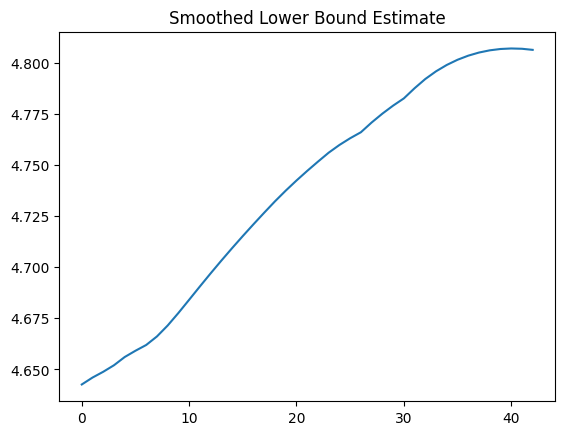

In [ ]:
lb_df = pd.DataFrame(np.array(LB_Smoothed[:43]))
plt.figure()
lb_df.plot(title = 'Smoothed Lower Bound Estimate', legend = False)

In [ ]:
# Transform from original validation using transformations
wass_val_n_summary_statistics = (val_n_summary_statistics - scaler_mean) / scaler_std
for i in range(len(Lambda_list)):
    wass_val_n_summary_statistics = transform_auto(Lambda_list[i], wass_val_n_summary_statistics)[0]
    transformed_val_n_summary_statistics = wass_val_n_summary_statistics

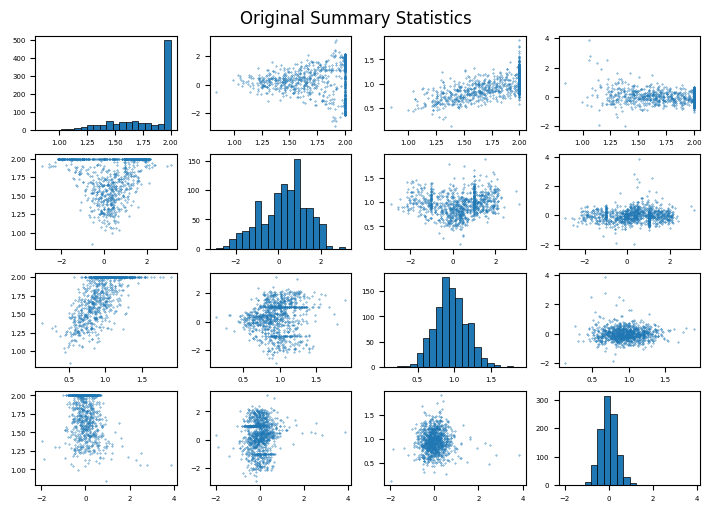

In [ ]:
# Initialise the subplot function using number of rows and columns
figure, axis = plt.subplots(4, 4, figsize=(7,5), constrained_layout=True)

# For Sine Function
for x in range(4):
    for y in range(4):
        if x != y:
            axis[x, y].scatter(val_n_summary_statistics[:1000,x], val_n_summary_statistics[:1000,y], s = 0.1)
            axis[x, y].tick_params(axis='both', which='major', labelsize=5)
        else:
            axis[x, y].hist(val_n_summary_statistics[:1000,x], bins = 20, edgecolor='black', linewidth=0.5)
            axis[x, y].tick_params(axis='both', which='major', labelsize=5)

# Combine all the operations and display
figure.suptitle('Original Summary Statistics')
plt.show()


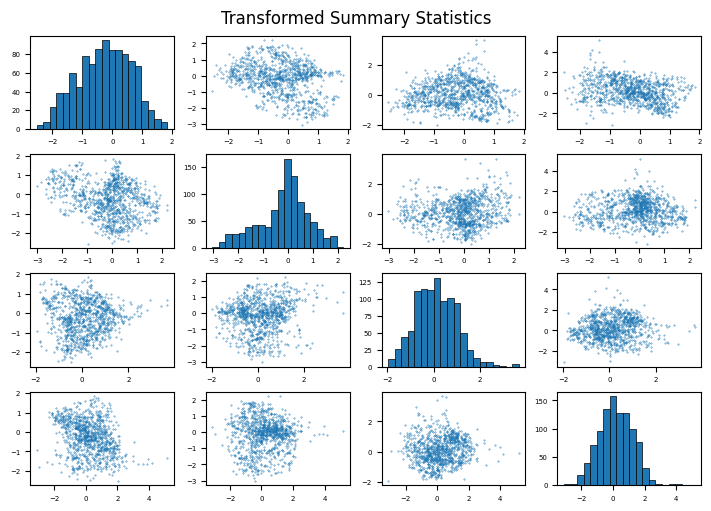

In [ ]:
# Initialise the subplot function using number of rows and columns
figure, axis = plt.subplots(4, 4, figsize=(7,5), constrained_layout=True)

# For Sine Function
for x in range(4):
    for y in range(4):
        if x != y:
            axis[x, y].scatter(wass_val_n_summary_statistics[:1000,x], wass_val_n_summary_statistics[:1000,y], s = 0.1)
            axis[x, y].tick_params(axis='both', which='major', labelsize=5)
        else:
            axis[x, y].hist(wass_val_n_summary_statistics[:1000,x], bins = 20, edgecolor='black', linewidth=0.5)
            axis[x, y].tick_params(axis='both', which='major', labelsize=5)

# Combine all the operations and display
figure.suptitle('Transformed Summary Statistics')
plt.show()

In [ ]:
# Save original data
np.save('alpha_original_without_tau.npy', val_n_summary_statistics)
np.save('alpha_transformed_without_tau.npy', wass_val_n_summary_statistics)
files.download('alpha_original_without_tau.npy')
files.download('alpha_transformed_without_tau.npy')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
# Load the array from the file
val_n_summary_statistics = np.load('toad_original_with_tau.npy')
wass_val_n_summary_statistics = np.load('toad_transformed_with_tau.npy')

In [ ]:
def nf_transform(Lambda_list, n_summary_statistics):
    n_summary_statistics = (n_summary_statistics - scaler_mean) / scaler_std
    for i in range(len(Lambda_list)):
        n_summary_statistics = transform_auto(Lambda_list[i], n_summary_statistics)[0]
    return n_summary_statistics

In [ ]:
## Transform actual data
transformed_actual_summary_statistics = nf_transform(Lambda_list, jnp.reshape(actual_summary_statistics, (1, len(actual_summary_statistics))))
transformed_actual_summary_statistics

Array([[-4.075626 , -1.8587439,  7.1461043, -0.8839911]], dtype=float32)

## FIND THE BEST THETA (COEFFICIENTS) USING VB

In [ ]:
def summary_statistics(theta, n_samples, n_datasets): ## EQ 6
    datasets = alpha_stable(theta[0], theta[1], theta[2], theta[3], n_samples, n_datasets)
    n_summary_statistics = jnp.array([alpha_stable_ss(datasets[i,:]) for i in range(n_datasets)])

    # Wasserstein transform
    transformed_summary_statistics = nf_transform(Lambda_list, n_summary_statistics)

    sample_mean = jnp.mean(transformed_summary_statistics, axis = 0)
    # cov = jnp.cov(transformed_summary_statistics.T)
    # sample_variance = cov + (jnp.eye(cov.shape[0]) * 5 * 1e-7)
    sample_precision = 1/eps_precision * jnp.eye(actual_summary_statistics.shape[0])
    for i in range(num_datasets): ## It will have i ranging from 0 to N-1
        diff = transformed_summary_statistics[i] - sample_mean
        sample_precision = sample_precision - ((1 + diff.T @ sample_precision @ diff)**(-1)) * (sample_precision @ diff.reshape(-1, 1) @ diff.reshape(1, -1) @ sample_precision)
    sample_precision = sample_precision * num_datasets ##### IS IT NEEDED??
    return sample_mean, sample_precision

In [ ]:
def mean_adjustment_summary_statistics(adjusted_theta, n_samples, n_datasets):
    theta = adjusted_theta[0:num_coeffs]
    Gamma = adjusted_theta[-num_latent:]
    sample_mean, sample_precision = summary_statistics(theta, n_samples, n_datasets)
    # inverse_sample_precision = 1/n_datasets * eps_precision * jnp.eye(sample_variance.shape[0]) + sample_variance ############# USING EQ 4 to find inversion
    # adjusted_sample_mean = sample_mean + jnp.diag(jnp.sqrt(inverse_sample_precision)) * Gamma ## EQ 4
    # adjusted_sample_mean = sample_mean + ((jnp.diag(sample_precision))**(-1/2)) * Gamma ## EQ 4
    adjusted_sample_mean = sample_mean + (jnp.zeros((num_latent, num_latent)).at[jnp.diag_indices_from(sample_precision)].set(jnp.diag(sample_precision)**(-1/2))) @ Gamma
    return adjusted_sample_mean, sample_precision

In [ ]:
@partial(jit, static_argnames=['sigma_theta','num_coeffs'])
def prior(theta, sigma_theta, num_coeffs):
    log_prior = multivariate_normal.logpdf(theta, mean = jnp.array([0] * num_coeffs), cov= sigma_theta * jnp.identity(num_coeffs))
    return log_prior

In [ ]:
def mean_adjustment_unbiased_log_likelihood(gs_adjusted_theta, actual_summary_statistics, n_samples, num_datasets):
    mean_adjust_ss = mean_adjustment_summary_statistics(gs_adjusted_theta, n_samples, num_datasets)
    adjusted_sample_mean = mean_adjust_ss[0]
    sample_precision = mean_adjust_ss[1]
    # u_est_log_likelihood = multivariate_normal.logpdf(actual_summary_statistics, mean = adjusted_sample_mean, cov= inverse_sample_precision)

    diff_mean_s = actual_summary_statistics - adjusted_sample_mean
    part1 = diff_mean_s.T @ sample_precision @ diff_mean_s
    u_est_log_likelihood = 1/2 * jnp.linalg.slogdet(sample_precision)[1] - 1/2 * part1
    return u_est_log_likelihood

In [ ]:
@jit
def nuissance_mean_adjustment_unbiased_log_likelihood(Gamma, mean_nuissance, variance_nuissance):
    nuissance_mean_u_est_log_likelihood = multivariate_normal.logpdf(Gamma, mean = mean_nuissance, cov= variance_nuissance)
    return nuissance_mean_u_est_log_likelihood

In [ ]:
@jit
def fun_log_q(theta, mu, l):
    log_q = multivariate_normal.logpdf(theta, mean = mu, cov= jnp.linalg.solve((l @ l.T), jnp.eye((l @ l.T).shape[0])))
    # log_q = scipy.stats.multivariate_normal.logpdf(np.array(theta), mean = np.array(mu), cov= np.array(jnp.linalg.solve((l @ l.T), jnp.eye((l @ l.T).shape[0]))), allow_singular = True)

    return log_q

In [ ]:
@partial(jit, static_argnames=['num_coeffs'])
def gradient_log_q(theta, mu, l, num_coeffs): #indep theta
    gradient_log_q_mu = l @ l.T @ (theta - mu)
    # gradient_log_q_l = (np.diag(np.linalg.inv(l)) - np.matmul(((np.reshape(theta - mu, (num_coeffs,1))) * theta - mu), l)).T[np.triu_indices(num_coeffs)] #use * because matmul gives scalar
    diag_inv_l = jnp.zeros_like(l, shape=(num_coeffs,num_coeffs)).at[jnp.diag_indices_from(l)].set(jnp.diag(l))
    gradient_log_q_l = (diag_inv_l - jnp.reshape(theta - mu, (num_coeffs,1)) @ jnp.reshape(theta - mu, (1,num_coeffs)) @ l).T[jnp.triu_indices(num_coeffs)] #use * because matmul gives scalar
    return gradient_log_q_mu, gradient_log_q_l

In [ ]:
@jit
def control_variates(Flat_grad_log_q, Flat_grad_lb):
    c = []
    stacked_gradient_lb = jnp.stack(Flat_grad_lb)
    stacked_gradient_log_q = jnp.stack(Flat_grad_log_q)
    for i in range(lambda_dim):
        sample_cov = jnp.cov(stacked_gradient_lb[:, i], stacked_gradient_log_q[:, i])
        c_i = sample_cov[0, 1] / sample_cov[1, 1]
        c.append(c_i)
    c_mu = jnp.array(c[0:num_coeffs])
    c_vech_l = jnp.array(c[num_coeffs:])
    return c_mu, c_vech_l

In [ ]:
class GVB:
    def __init__(self, samples, actual_summary_statistics, learning_rate, threshold, l_threshold, adaptive_lr_1, adaptive_lr_2, t_w, Patience):
        self.samples = samples
        self.actual_summary_statistics = actual_summary_statistics
        self.num_coeffs = len(true_theta) # number of coeffs
        self.learning_rate = learning_rate
        self.threshold = threshold
        self.l_threshold = l_threshold
        self.adaptive_lr_1 = adaptive_lr_1
        self.adaptive_lr_2 = adaptive_lr_2
        self.t_w = t_w
        self.Patience = Patience

    def fun_gradient_lb(self, theta_tilde_q, mu_q, l_q, c_mu, c_l):
        # Calculate theta from mu, l (lambda)
        alpha_q = (2 * jnp.exp(theta_tilde_q[0]) + 1.1) / (1 + jnp.exp(theta_tilde_q[0]))
        beta_q = (jnp.exp(theta_tilde_q[1]) - 1) / (jnp.exp(theta_tilde_q[1]) + 1)
        gamma_q = jnp.exp(theta_tilde_q[2])
        delta_q = theta_tilde_q[3]
        theta_q = jnp.array([alpha_q, beta_q, gamma_q, delta_q])

        ss_q = summary_statistics(theta_q, n_samples, num_datasets)
        sample_mean_q = ss_q[0]
        sample_precision_q = ss_q[1]
        # sample_variance_q = ss_q[2]
        # inverse_sample_precision_q = 1/num_datasets * eps_precision * jnp.eye(sample_variance_q.shape[0]) + sample_variance_q

        # Nuissance mean and variance: PAGE 9
        # diag_precision = jnp.zeros((num_latent, num_latent)).at[jnp.diag_indices_from(inverse_sample_precision_q)].set(jnp.diag(jnp.sqrt(inverse_sample_precision_q)))
        diag_precision = jnp.zeros((num_latent, num_latent)).at[jnp.diag_indices_from(sample_precision_q)].set(jnp.diag(sample_precision_q)**(-1/2))
        # mean_nuissance_p1_non_inv = jnp.identity(num_latent) / sigma_latent + jnp.diag(sample_variance_q).T @ jnp.linalg.solve(sample_variance_q, jnp.diag(sample_variance_q))
        mean_nuissance_p1_non_inv = jnp.identity(num_latent) / sigma_latent + diag_precision.T @ sample_precision_q @ diag_precision
        mean_nuissance_p1 = jnp.linalg.solve(mean_nuissance_p1_non_inv, jnp.eye(mean_nuissance_p1_non_inv.shape[0]))
        # mean_nuissance_p1 = jnp.linalg.solve(mean_nuissance_p1_non_inv, jnp.eye(mean_nuissance_p1_non_inv.shape[0]))

        diff_mean = self.actual_summary_statistics - sample_mean_q
        mean_nuissance_p2 = diag_precision @ sample_precision_q @ diff_mean
        mean_nuissance_q = mean_nuissance_p1 @ mean_nuissance_p2
        variance_nuissance_q = mean_nuissance_p1
        # print('var', variance_nuissance_q)
        # print('mean', mean_nuissance_q)

        # Generate Gamma

        Gamma = random.multivariate_normal(key2, mean = mean_nuissance_q, cov = variance_nuissance_q)
        adjusted_theta_q = jnp.concatenate((theta_q, Gamma))

        # Find gradient of LB
        llh = mean_adjustment_unbiased_log_likelihood(adjusted_theta_q, self.actual_summary_statistics, n_samples, num_datasets)
        llh_gamma = nuissance_mean_adjustment_unbiased_log_likelihood(Gamma, mean_nuissance_q, variance_nuissance_q)

        h_lambda = prior(theta_tilde_q, sigma_theta, num_coeffs) + prior(Gamma, sigma_latent, num_latent) + llh - fun_log_q(theta_tilde_q, mu_q, l_q) - llh_gamma

        # Find gradient of LB
        grad_log_q_mu, grad_log_q_l = gradient_log_q(theta_tilde_q, mu_q, l_q, num_coeffs)
        gradient_lb_mu = grad_log_q_mu * (h_lambda - c_mu)
        gradient_lb_l = grad_log_q_l * (h_lambda - c_l)
        # Calculate control variates
        flattened_gradient_log_q = jnp.concatenate((grad_log_q_mu, grad_log_q_l), axis = None)
        flattened_gradient_lb = jnp.concatenate((gradient_lb_mu, gradient_lb_l), axis = None)

        return gradient_lb_mu, gradient_lb_l, h_lambda, flattened_gradient_log_q, flattened_gradient_lb

    def vb_posterior(self, stop):
        # Initialize mu_0, L_0
        # mu_0 = np.array([np.log((self.actual_summary_statistics[0]-1.1)/(2-self.actual_summary_statistics[0])), np.log((1+self.actual_summary_statistics[1])/(1-self.actual_summary_statistics[1])), np.log(self.actual_summary_statistics[2]), self.actual_summary_statistics[3]])
        #mu_0 = np.array([1.5, 0.5, 3, 0])
        mu_0 = jnp.array([jnp.log((1.8-1.1)/(2-1.8)),jnp.log((0.5+1)/(1-0.5)),jnp.log(1),0])
        #mu_0 = np.array([self.actual_summary_statistics[0], self.actual_summary_statistics[1], self.actual_summary_statistics[2], self.actual_summary_statistics[3]])
        # mu_0 = np.array([0] * self.num_coeffs)
        l_0 = jnp.tril(jnp.identity(self.num_coeffs) * 10)
        Sigma_0_inv = l_0 @ l_0.T
        Sigma_0 = jnp.linalg.solve(Sigma_0_inv, jnp.eye(Sigma_0_inv.shape[0]))
        ### Change ways to get vech(l0)
        vech_l0 = l_0.T[jnp.triu_indices(self.num_coeffs)]

        # Initilize best lambda
        lambda_best_mu = mu_0
        lambda_best_l = vech_l0
        # List of calculations of LB
        LB_all = []
        LB_Smoothed = []
        patience = 0
        # List of flattened gradients
        Flattened_gradient_lb = []
        Flattened_gradient_log_q = []

        func_auto = vmap(self.fun_gradient_lb, in_axes=[0, None, None, None, None])

        for t in tqdm(range(stop)):
            if t == 0:
                # Draw samples of theta from  variational q
                # List of gradients
                theta_0_samples = random.multivariate_normal(subkeys[t], mean = mu_0, cov = Sigma_0, shape = (self.samples,))
                gradient_lb_mu_0, gradient_lb_l_0, lb_0, Flattened_gradient_log_q, Flattened_gradient_lb = func_auto(theta_0_samples, mu_0, l_0, 0, 0)
                # Calculate control variates using all samples
                c_mu, c_vech_l = control_variates(Flattened_gradient_log_q, Flattened_gradient_lb)
                # Update lambda_q
                self.g_mu_init = jnp.mean(gradient_lb_mu_0, axis = 0)
                self.g_vech_l_init = jnp.mean(gradient_lb_l_0, axis = 0)
                # Gradient clipping
                if jnp.linalg.norm(jnp.concatenate((self.g_mu_init, self.g_vech_l_init), axis = None)) > self.l_threshold:
                    self.g_mu_init = self.l_threshold * self.g_mu_init / jnp.linalg.norm(jnp.concatenate((self.g_mu_init, self.g_vech_l_init), axis = None))
                    self.g_vech_l_init = self.l_threshold * self.g_vech_l_init / jnp.linalg.norm(jnp.concatenate((self.g_mu_init, self.g_vech_l_init), axis = None))
                self.v_mu_init = self.g_mu_init ** 2
                self.v_vech_l_init = self.g_vech_l_init ** 2
                # Calculate lower bound
                LB_all.append(jnp.mean(lb_0))
                print('LB', (jnp.mean(lb_0)))
                lambda_q_mu = mu_0
                lambda_q_l = vech_l0

            if t > 0:
                # From lambda_q find mu_q and L_q
                mu_q = lambda_q_mu

                ### Change ways to convert from vech_l0 to l0
                vech_lq = list(lambda_q_l)
                l_q = jnp.zeros((self.num_coeffs, self.num_coeffs))
                # l_q[:, 0] = lambda_q[1][0:self.num_coeffs]
                # l_q[1:self.num_coeffs, 1] = lambda_q[1][4:7]
                # l_q[2:self.num_coeffs, 2] = lambda_q[1][7:9]
                # l_q[3:self.num_coeffs, 3] = lambda_q[1][9:10]
                for i in range(self.num_coeffs):
                    l_q = l_q.at[i:self.num_coeffs,i].set(vech_lq[:self.num_coeffs - i])
                    del vech_lq[:self.num_coeffs-i]

                Sigma_q_inv = l_q @ l_q.T
                Sigma_q =  jnp.linalg.solve(Sigma_q_inv, jnp.eye(Sigma_q_inv.shape[0]))
                l_q_inv =  jnp.linalg.solve(l_q, jnp.eye(l_q.shape[0]))
                # List of gradients
                Gradient_lb = []
                lb_t = []
                theta_q_samples = random.multivariate_normal(subkeys[t], mean = mu_q, cov = Sigma_q, shape = (self.samples,))
                gradient_lb_mu, gradient_lb_l, lb_t, Flattened_gradient_log_q, Flattened_gradient_lb = func_auto(theta_q_samples, mu_q, l_q, c_mu, c_vech_l)

                # Update control variates
                c_mu, c_vech_l = control_variates(Flattened_gradient_log_q, Flattened_gradient_lb)
                # Update lambda_q
                g_mu_t = jnp.mean(gradient_lb_mu, axis = 0)
                g_vech_l_t = jnp.mean(gradient_lb_l, axis = 0)
                # Gradient clipping
                if jnp.linalg.norm(jnp.concatenate((g_mu_t, g_vech_l_t), axis = None)) > self.l_threshold:
                    g_mu_t = self.l_threshold * g_mu_t / jnp.linalg.norm(jnp.concatenate((g_mu_t, g_vech_l_t), axis = None))
                    g_vech_l_t = self.l_threshold * g_vech_l_t / jnp.linalg.norm(jnp.concatenate((g_mu_t, g_vech_l_t), axis = None))
                v_mu_t = g_mu_t ** 2
                v_vech_l_t = g_vech_l_t ** 2
                #---- Update lambda
                self.g_mu_init = self.adaptive_lr_1 * self.g_mu_init + (1 - self.adaptive_lr_1) * g_mu_t
                self.g_vech_l_init = self.adaptive_lr_1 * self.g_vech_l_init + (1 - self.adaptive_lr_1) * g_vech_l_t

                self.v_mu_init = self.adaptive_lr_2 * self.v_mu_init + (1 - self.adaptive_lr_2) * v_mu_t
                self.v_vech_l_init = self.adaptive_lr_2 * self.v_vech_l_init + (1 - self.adaptive_lr_2) * v_vech_l_t

                if t >= self.threshold:
                    update_t = self.learning_rate * self.threshold / t
                else:
                    update_t = self.learning_rate

                lambda_q_mu = lambda_q_mu + update_t * self.g_mu_init / (self.v_mu_init ** 0.5)
                lambda_q_l = lambda_q_l + update_t * self.g_vech_l_init / (self.v_vech_l_init ** 0.5)
                # Calculate lower bound
                LB_all.append(jnp.mean(lb_t))

                if t < self.t_w:
                    print('LB', jnp.mean(lb_t))

                if t >= self.t_w:
                    LB_smoothed = jnp.mean(jnp.array(LB_all[t - self.t_w + 1 : t]))
                    print('LB Smoothed', LB_smoothed)
                    LB_Smoothed.append(LB_smoothed)
                    if LB_smoothed >= jnp.max(jnp.array(LB_Smoothed)):
                        patience = 0
                        lambda_best_mu = lambda_q_mu
                        lambda_best_l = lambda_q_l
                    else:
                        patience += 1
                        if patience > self.Patience:
                            print("Stop at", t)
                            break

        return LB_all, LB_Smoothed, lambda_best_mu, lambda_best_l

In [ ]:
# Set hyperparameters
stop = 4000

In [ ]:
vb = GVB(500, transformed_actual_summary_statistics[0], 0.0001, 2500, 100, 0.9, 0.9, 100, 20)
LB_estimate, smoothed_LB_estimate, best_lambda_mu, best_lambda_l = vb.vb_posterior(stop)

  0%|          | 1/4000 [00:19<21:17:11, 19.16s/it]

LB -16.823677


  0%|          | 2/4000 [00:35<19:41:54, 17.74s/it]

LB -16.980396


  0%|          | 3/4000 [00:52<19:15:24, 17.34s/it]

LB -16.949383


  0%|          | 4/4000 [01:09<19:05:17, 17.20s/it]

LB -16.918722


  0%|          | 5/4000 [01:26<19:05:29, 17.20s/it]

LB -16.87827


  0%|          | 6/4000 [01:43<18:56:30, 17.07s/it]

LB -16.925713


  0%|          | 7/4000 [02:00<18:50:00, 16.98s/it]

LB -16.94204


  0%|          | 8/4000 [02:17<18:56:01, 17.07s/it]

LB -16.939892


  0%|          | 9/4000 [02:34<18:50:03, 16.99s/it]

LB -16.8919


  0%|          | 10/4000 [02:51<18:47:23, 16.95s/it]

LB -16.975363


  0%|          | 11/4000 [03:08<18:43:02, 16.89s/it]

LB -16.990646


  0%|          | 12/4000 [03:25<18:42:56, 16.89s/it]

LB -16.976309


  0%|          | 13/4000 [03:41<18:40:09, 16.86s/it]

LB -16.8292


  0%|          | 14/4000 [03:58<18:37:43, 16.82s/it]

LB -16.992065


  0%|          | 15/4000 [04:16<18:48:48, 17.00s/it]

LB -16.834352


  0%|          | 16/4000 [04:33<18:47:06, 16.97s/it]

LB -16.819004


  0%|          | 17/4000 [04:49<18:43:38, 16.93s/it]

LB -16.950407


  0%|          | 18/4000 [05:07<18:50:30, 17.03s/it]

LB -16.911325


  0%|          | 19/4000 [05:24<18:53:10, 17.08s/it]

LB -17.027685


  0%|          | 20/4000 [05:41<18:49:43, 17.03s/it]

LB -16.912153


  1%|          | 21/4000 [05:57<18:43:35, 16.94s/it]

LB -16.97118


  1%|          | 22/4000 [06:14<18:41:38, 16.92s/it]

LB -16.982183


  1%|          | 23/4000 [06:31<18:36:29, 16.84s/it]

LB -16.969416


  1%|          | 24/4000 [06:48<18:35:39, 16.84s/it]

LB -16.782784


  1%|          | 25/4000 [07:04<18:30:10, 16.76s/it]

LB -16.923067


  1%|          | 26/4000 [07:21<18:26:50, 16.71s/it]

LB -16.99442


  1%|          | 27/4000 [07:38<18:29:51, 16.76s/it]

LB -16.948822


  1%|          | 28/4000 [07:55<18:31:44, 16.79s/it]

LB -16.875473


  1%|          | 29/4000 [08:12<18:33:20, 16.82s/it]

LB -16.887402


  1%|          | 30/4000 [08:28<18:30:35, 16.78s/it]

LB -16.806234


  1%|          | 31/4000 [08:45<18:28:33, 16.76s/it]

LB -17.028563


  1%|          | 32/4000 [09:02<18:31:32, 16.81s/it]

LB -16.933575


  1%|          | 33/4000 [09:19<18:28:42, 16.77s/it]

LB -16.985014


  1%|          | 34/4000 [09:36<18:33:20, 16.84s/it]

LB -16.997093


  1%|          | 35/4000 [09:52<18:29:45, 16.79s/it]

LB -16.96838


  1%|          | 36/4000 [10:09<18:30:02, 16.80s/it]

LB -16.930855


  1%|          | 37/4000 [10:26<18:33:56, 16.87s/it]

LB -16.802706


  1%|          | 38/4000 [10:43<18:32:55, 16.85s/it]

LB -16.855537


  1%|          | 39/4000 [11:00<18:31:23, 16.83s/it]

LB -16.951794


  1%|          | 40/4000 [11:16<18:29:03, 16.80s/it]

LB -16.994972


  1%|          | 41/4000 [11:33<18:31:55, 16.85s/it]

LB -17.035423


  1%|          | 42/4000 [11:50<18:30:18, 16.83s/it]

LB -16.966227


  1%|          | 43/4000 [12:07<18:28:58, 16.82s/it]

LB -16.920334


  1%|          | 44/4000 [12:24<18:26:14, 16.78s/it]

LB -16.985472


  1%|          | 45/4000 [12:40<18:23:19, 16.74s/it]

LB -16.972717


  1%|          | 46/4000 [12:57<18:29:07, 16.83s/it]

LB -16.904446


  1%|          | 47/4000 [13:14<18:27:14, 16.81s/it]

LB -16.80891


  1%|          | 48/4000 [13:31<18:24:34, 16.77s/it]

LB -16.974892


  1%|          | 49/4000 [13:48<18:23:34, 16.76s/it]

LB -17.00145


  1%|▏         | 50/4000 [14:04<18:18:58, 16.69s/it]

LB -16.948563


  1%|▏         | 51/4000 [14:21<18:19:01, 16.70s/it]

LB -16.889349


  1%|▏         | 52/4000 [14:38<18:19:14, 16.71s/it]

LB -16.891672


  1%|▏         | 53/4000 [14:54<18:16:39, 16.67s/it]

LB -16.98621


  1%|▏         | 54/4000 [15:11<18:17:40, 16.69s/it]

LB -16.99424


  1%|▏         | 55/4000 [15:28<18:21:26, 16.75s/it]

LB -17.067799


  1%|▏         | 56/4000 [15:45<18:21:47, 16.76s/it]

LB -16.914474


  1%|▏         | 57/4000 [16:01<18:20:56, 16.75s/it]

LB -16.794407


  1%|▏         | 58/4000 [16:18<18:20:13, 16.75s/it]

LB -16.974087


  1%|▏         | 59/4000 [16:35<18:21:11, 16.77s/it]

LB -16.973509


  2%|▏         | 60/4000 [16:52<18:20:48, 16.76s/it]

LB -16.95054


  2%|▏         | 61/4000 [17:08<18:18:06, 16.73s/it]

LB -17.077986


  2%|▏         | 62/4000 [17:25<18:18:32, 16.74s/it]

LB -16.89096


  2%|▏         | 63/4000 [17:42<18:18:50, 16.75s/it]

LB -16.97459


  2%|▏         | 64/4000 [17:58<18:17:11, 16.73s/it]

LB -16.920055


  2%|▏         | 65/4000 [18:15<18:17:42, 16.74s/it]

LB -16.951818


  2%|▏         | 66/4000 [18:32<18:13:57, 16.68s/it]

LB -16.850063


  2%|▏         | 67/4000 [18:49<18:16:00, 16.72s/it]

LB -16.979706


  2%|▏         | 68/4000 [19:06<18:20:45, 16.80s/it]

LB -17.008898


  2%|▏         | 69/4000 [19:22<18:21:16, 16.81s/it]

LB -16.843197


  2%|▏         | 70/4000 [19:39<18:20:13, 16.80s/it]

LB -16.84669


  2%|▏         | 71/4000 [19:56<18:24:08, 16.86s/it]

LB -16.939621


  2%|▏         | 72/4000 [20:13<18:26:21, 16.90s/it]

LB -16.862349


  2%|▏         | 73/4000 [20:30<18:34:30, 17.03s/it]

LB -16.965754


  2%|▏         | 74/4000 [20:48<18:38:04, 17.09s/it]

LB -16.877134


  2%|▏         | 75/4000 [21:05<18:40:04, 17.12s/it]

LB -16.943445


  2%|▏         | 76/4000 [21:22<18:42:40, 17.17s/it]

LB -16.862757


  2%|▏         | 77/4000 [21:39<18:37:00, 17.08s/it]

LB -17.081404


  2%|▏         | 78/4000 [21:56<18:36:43, 17.08s/it]

LB -16.93436


  2%|▏         | 79/4000 [22:13<18:33:34, 17.04s/it]

LB -16.918394


  2%|▏         | 80/4000 [22:30<18:32:35, 17.03s/it]

LB -16.70432


  2%|▏         | 81/4000 [22:47<18:35:11, 17.07s/it]

LB -16.937641


  2%|▏         | 82/4000 [23:05<18:40:14, 17.16s/it]

LB -16.923922


  2%|▏         | 83/4000 [23:22<18:36:44, 17.11s/it]

LB -16.937145


  2%|▏         | 84/4000 [23:39<18:35:30, 17.09s/it]

LB -17.060106


  2%|▏         | 85/4000 [23:56<18:37:45, 17.13s/it]

LB -16.971895


  2%|▏         | 86/4000 [24:13<18:38:10, 17.14s/it]

LB -16.937494


  2%|▏         | 87/4000 [24:30<18:42:26, 17.21s/it]

LB -16.956047


  2%|▏         | 88/4000 [24:48<18:42:41, 17.22s/it]

LB -16.921322


  2%|▏         | 89/4000 [25:05<18:43:27, 17.24s/it]

LB -16.898252


  2%|▏         | 90/4000 [25:22<18:44:25, 17.25s/it]

LB -16.859106


  2%|▏         | 91/4000 [25:40<18:46:54, 17.30s/it]

LB -16.956501


  2%|▏         | 92/4000 [25:57<18:49:41, 17.34s/it]

LB -16.89942


  2%|▏         | 93/4000 [26:14<18:43:26, 17.25s/it]

LB -17.06111


  2%|▏         | 94/4000 [26:31<18:44:33, 17.27s/it]

LB -16.942118


  2%|▏         | 95/4000 [26:48<18:35:25, 17.14s/it]

LB -16.91947


  2%|▏         | 96/4000 [27:05<18:32:32, 17.10s/it]

LB -16.941574


  2%|▏         | 97/4000 [27:22<18:22:30, 16.95s/it]

LB -16.96207


  2%|▏         | 98/4000 [27:39<18:21:10, 16.93s/it]

LB -16.976395


  2%|▏         | 99/4000 [27:56<18:22:11, 16.95s/it]

LB -16.962097


  2%|▎         | 100/4000 [28:13<18:22:27, 16.96s/it]

LB -16.922796


  3%|▎         | 101/4000 [28:30<18:23:23, 16.98s/it]

LB Smoothed -16.93504


  3%|▎         | 102/4000 [28:47<18:20:49, 16.94s/it]

LB Smoothed -16.93399


  3%|▎         | 103/4000 [29:03<18:17:36, 16.90s/it]

LB Smoothed -16.933432


  3%|▎         | 104/4000 [29:20<18:16:02, 16.88s/it]

LB Smoothed -16.933653


  3%|▎         | 105/4000 [29:37<18:16:47, 16.90s/it]

LB Smoothed -16.934294


  3%|▎         | 106/4000 [29:54<18:16:15, 16.89s/it]

LB Smoothed -16.934275


  3%|▎         | 107/4000 [30:11<18:17:45, 16.92s/it]

LB Smoothed -16.934175


  3%|▎         | 108/4000 [30:28<18:14:49, 16.88s/it]

LB Smoothed -16.9343


  3%|▎         | 109/4000 [30:45<18:26:32, 17.06s/it]

LB Smoothed -16.934269


  3%|▎         | 110/4000 [31:02<18:27:42, 17.09s/it]

LB Smoothed -16.932611


  3%|▎         | 111/4000 [31:20<18:27:00, 17.08s/it]

LB Smoothed -16.931213


  3%|▎         | 112/4000 [31:36<18:21:14, 16.99s/it]

LB Smoothed -16.92963


  3%|▎         | 113/4000 [31:53<18:20:34, 16.99s/it]

LB Smoothed -16.930368


  3%|▎         | 114/4000 [32:10<18:22:23, 17.02s/it]

LB Smoothed -16.92874


  3%|▎         | 115/4000 [32:28<18:23:51, 17.05s/it]

LB Smoothed -16.929132


  3%|▎         | 116/4000 [32:45<18:25:52, 17.08s/it]

LB Smoothed -16.930387


  3%|▎         | 117/4000 [33:02<18:21:35, 17.02s/it]

LB Smoothed -16.93035


  3%|▎         | 118/4000 [33:19<18:21:40, 17.03s/it]

LB Smoothed -16.930769


  3%|▎         | 119/4000 [33:36<18:20:30, 17.01s/it]

LB Smoothed -16.929941


  3%|▎         | 120/4000 [33:53<18:21:02, 17.03s/it]

LB Smoothed -16.9298


  3%|▎         | 121/4000 [34:10<18:21:44, 17.04s/it]

LB Smoothed -16.930275


  3%|▎         | 122/4000 [34:27<18:18:02, 16.99s/it]

LB Smoothed -16.928988


  3%|▎         | 123/4000 [34:43<18:16:04, 16.96s/it]

LB Smoothed -16.927473


  3%|▎         | 124/4000 [35:01<18:18:23, 17.00s/it]

LB Smoothed -16.930115


  3%|▎         | 125/4000 [35:18<18:27:26, 17.15s/it]

LB Smoothed -16.929537


  3%|▎         | 126/4000 [35:35<18:24:28, 17.11s/it]

LB Smoothed -16.929504


  3%|▎         | 127/4000 [35:52<18:23:47, 17.10s/it]

LB Smoothed -16.928923


  3%|▎         | 128/4000 [36:10<18:28:19, 17.17s/it]

LB Smoothed -16.930622


  3%|▎         | 129/4000 [36:27<18:26:36, 17.15s/it]

LB Smoothed -16.931227


  3%|▎         | 130/4000 [36:44<18:26:01, 17.15s/it]

LB Smoothed -16.932598


  3%|▎         | 131/4000 [37:01<18:24:36, 17.13s/it]

LB Smoothed -16.931099


  3%|▎         | 132/4000 [37:18<18:20:31, 17.07s/it]

LB Smoothed -16.930836


  3%|▎         | 133/4000 [37:35<18:17:55, 17.04s/it]

LB Smoothed -16.931263


  3%|▎         | 134/4000 [37:52<18:20:40, 17.08s/it]

LB Smoothed -16.93134


  3%|▎         | 135/4000 [38:09<18:18:24, 17.05s/it]

LB Smoothed -16.931389


  3%|▎         | 136/4000 [38:26<18:18:28, 17.06s/it]

LB Smoothed -16.931524


  3%|▎         | 137/4000 [38:43<18:16:15, 17.03s/it]

LB Smoothed -16.932636


  3%|▎         | 138/4000 [39:00<18:13:10, 16.98s/it]

LB Smoothed -16.932734


  3%|▎         | 139/4000 [39:17<18:09:37, 16.93s/it]

LB Smoothed -16.931768


  4%|▎         | 140/4000 [39:33<18:06:47, 16.89s/it]

LB Smoothed -16.930748


  4%|▎         | 141/4000 [39:50<18:07:25, 16.91s/it]

LB Smoothed -16.929445


  4%|▎         | 142/4000 [40:08<18:13:24, 17.00s/it]

LB Smoothed -16.930176


  4%|▎         | 143/4000 [40:25<18:18:02, 17.08s/it]

LB Smoothed -16.930058


  4%|▎         | 143/4000 [40:42<18:17:55, 17.08s/it]

LB Smoothed -16.93059
Stop at 143


<Axes: title={'center': 'Lower Bound Estimate'}>

<Figure size 640x480 with 0 Axes>

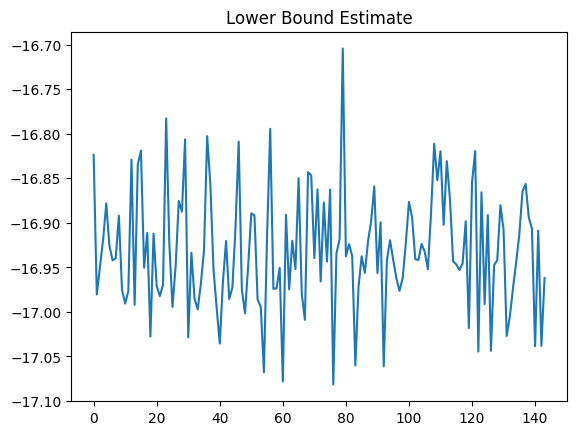

In [ ]:
lb_df = pd.DataFrame(np.array(LB_estimate))
plt.figure()
lb_df.plot(title = 'Lower Bound Estimate', legend = False)

<Axes: title={'center': 'Smoothed Lower Bound Estimate'}>

<Figure size 640x480 with 0 Axes>

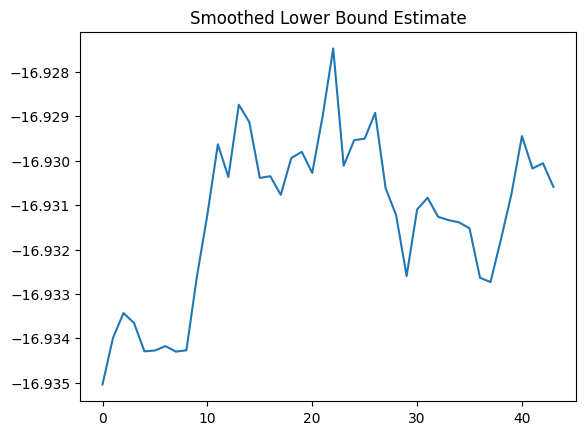

In [ ]:
lb_df = pd.DataFrame(np.array(smoothed_LB_estimate))
plt.figure()
lb_df.plot(title = 'Smoothed Lower Bound Estimate', legend = False)

In [ ]:
best_lambda_mu = jnp.array([1.2520645 ,  1.0964104 , -0.00194312, -0.001822])

In [ ]:
best_lambda_l = jnp.array([1.0000392e+01, -1.1230488e-03,  2.4190396e-03, -1.0683411e-03,
        9.9984140e+00, -3.6717164e-03,  1.7733632e-04,  1.0001250e+01,
       -2.2548139e-03,  1.0001479e+01])

In [ ]:
best_mu = best_lambda_mu
best_vech_l = list(best_lambda_l)
best_l = np.zeros((num_coeffs, num_coeffs))
for i in range(num_coeffs):
    best_l[i:num_coeffs,i] = best_vech_l[:num_coeffs - i]
    del best_vech_l[:num_coeffs-i]
best_Sigma_inv = best_l @ best_l.T
best_Sigma =  np.linalg.inv(best_Sigma_inv)

best_theta_tilde = ss_multivariate_normal.rvs(mean = best_mu, cov = best_Sigma, size = 1000)
best_alpha = (2 * np.exp(best_theta_tilde[:,0]) + 1.1) / (1 + np.exp(best_theta_tilde[:,0]))
best_beta = (np.exp(best_theta_tilde[:,1]) - 1) / (np.exp(best_theta_tilde[:,1]) + 1)
best_gamma = np.exp(best_theta_tilde[:,2])
best_delta = best_theta_tilde[:,3]
best_theta = np.array([best_alpha, best_beta, best_gamma, best_delta])
posterior_mean_estimate = np.mean(best_theta, axis = 1)
posterior_mean_estimate

array([ 1.79926592,  0.49691752,  1.00843163, -0.0024456 ])

In [ ]:
np.linalg.norm(posterior_mean_estimate - true_theta)

0.009333516